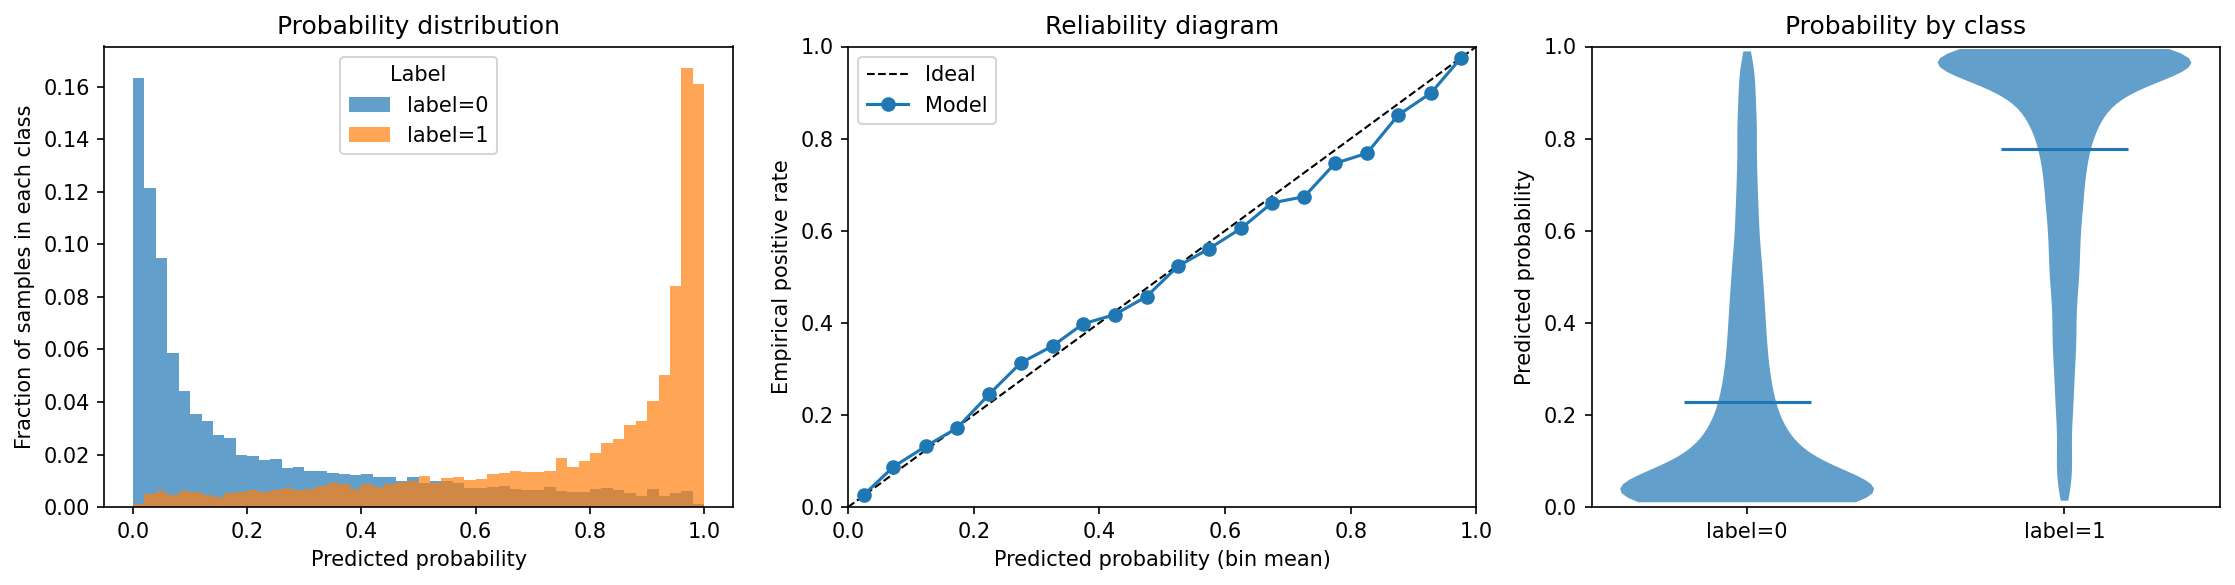

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


df = pd.read_csv("result/test_predictions_methynano_rice.csv")

probs = df["prob_pos"].values
labels = df["label_true"].values.astype(int)

probs_0 = probs[labels == 0]
probs_1 = probs[labels == 1]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax1, ax2, ax3 = axes


bins = np.linspace(0, 1, 51)

weights_0 = np.ones_like(probs_0) / len(probs_0)
weights_1 = np.ones_like(probs_1) / len(probs_1)

ax1.hist(
    probs_0,
    bins=bins,
    weights=weights_0,
    alpha=0.7,
    label="label=0",
    edgecolor="none",
)
ax1.hist(
    probs_1,
    bins=bins,
    weights=weights_1,
    alpha=0.7,
    label="label=1",
    edgecolor="none",
)

ax1.set_xlabel("Predicted probability")
ax1.set_ylabel("Fraction of samples in each class")
ax1.set_title("Probability distribution")
ax1.legend(title="Label")


n_bins = 20
bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
bin_ids = np.digitize(probs, bin_edges) - 1  # 0..n_bins-1

bin_centers = []
bin_pred_mean = []
bin_pos_rate = []

for b in range(n_bins):
    mask = bin_ids == b
    if not np.any(mask):
        continue
    p_bin = probs[mask]
    y_bin = labels[mask]

    bin_centers.append(0.5 * (bin_edges[b] + bin_edges[b + 1]))
    bin_pred_mean.append(p_bin.mean())
    bin_pos_rate.append(y_bin.mean()) 

bin_centers = np.array(bin_centers)
bin_pred_mean = np.array(bin_pred_mean)
bin_pos_rate = np.array(bin_pos_rate)


ax2.plot([0, 1], [0, 1], "k--", linewidth=1, label="Ideal")


ax2.plot(bin_pred_mean, bin_pos_rate, marker="o", linewidth=1.5, label="Model")

ax2.set_xlabel("Predicted probability (bin mean)")
ax2.set_ylabel("Empirical positive rate")
ax2.set_title("Reliability diagram")
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.legend()


data_for_violin = [probs_0, probs_1]
positions = [0, 1]

vp = ax3.violinplot(
    data_for_violin,
    positions=positions,
    widths=0.8,
    showmeans=True,
    showextrema=False,
    showmedians=False,
)

for body in vp['bodies']:
    body.set_alpha(0.7)

ax3.set_xticks(positions)
ax3.set_xticklabels(["label=0", "label=1"])
ax3.set_ylabel("Predicted probability")
ax3.set_title("Probability by class")
ax3.set_ylim(0, 1)

plt.tight_layout()
plt.show()



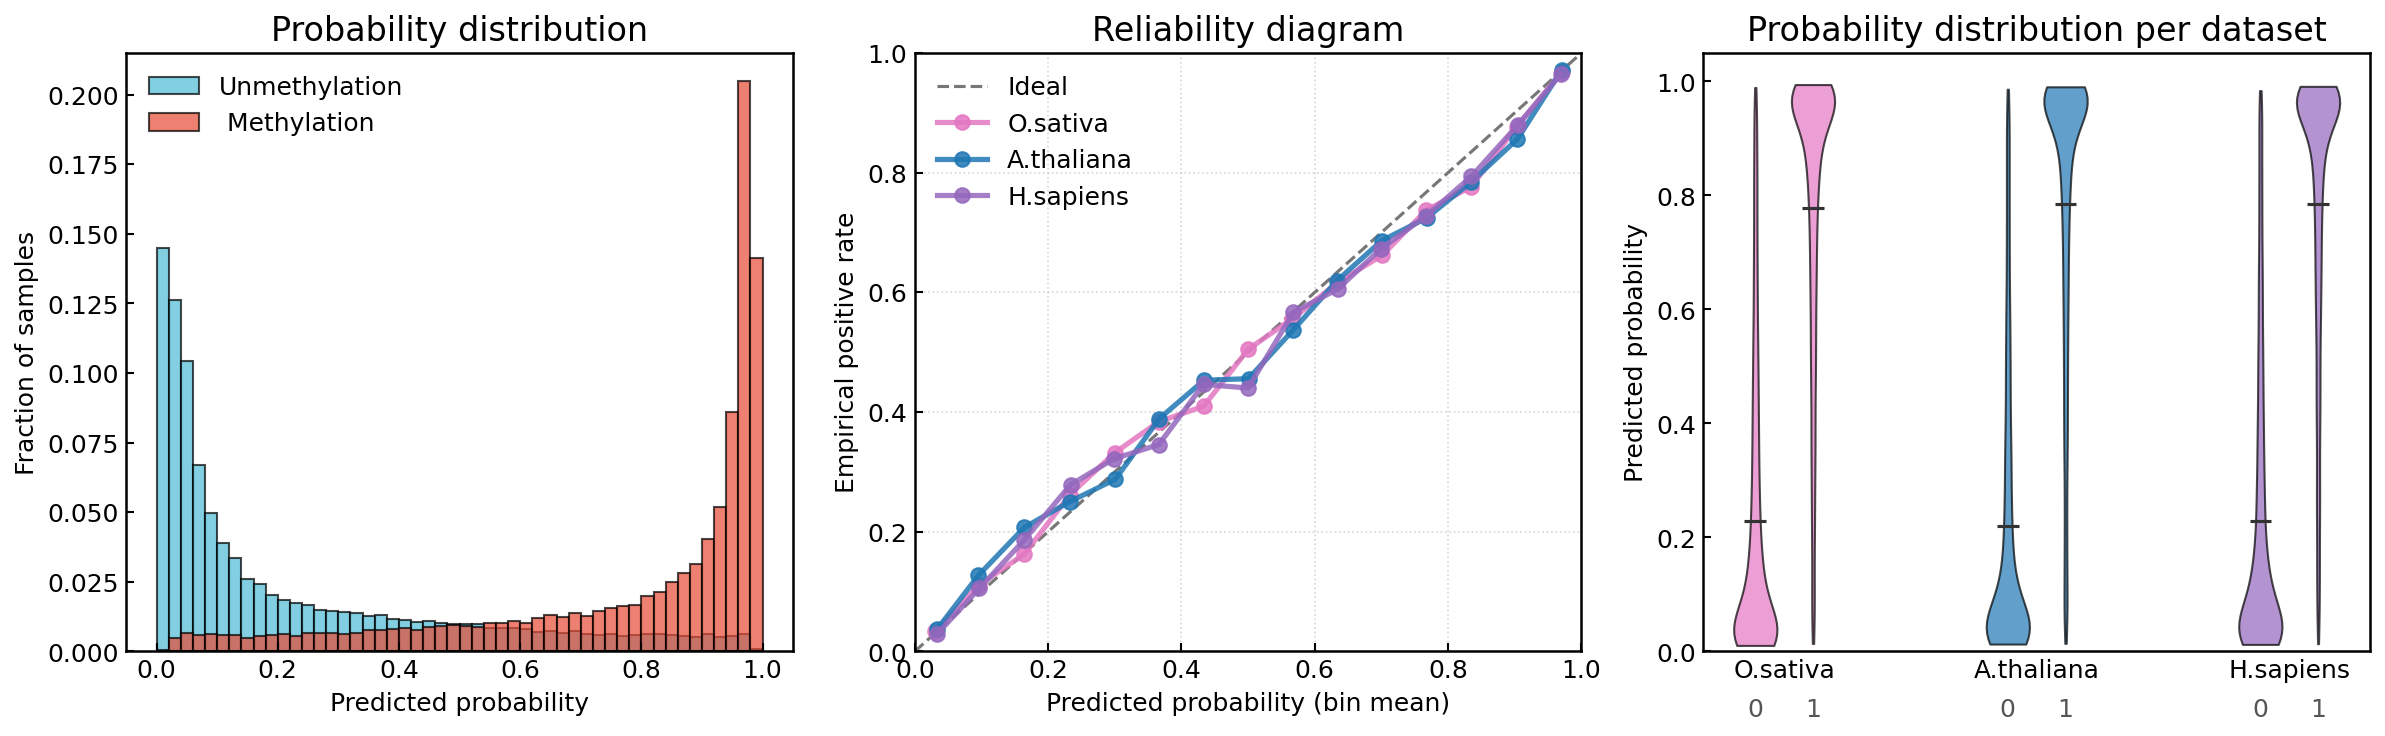

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os


def generate_dummy_data(n=200, seed=42):
    np.random.seed(seed)
    probs = np.random.beta(a=2, b=2, size=n)
    labels = np.random.binomial(1, probs)
    return pd.DataFrame({"prob_pos": probs, "label_true": labels})

files = {
    "O.sativa":   "result/test_predictions_methynano_rice.csv",
    "A.thaliana": "result/test_predictions_methynano_ninanjie.csv",
    "H.sapiens":  "result/test_predictions_methynano_people.csv",
}

dfs = {}
for name, path in files.items():
    if os.path.exists(path):
        dfs[name] = pd.read_csv(path)
    else:
        dfs[name] = generate_dummy_data(seed=len(name))


dataset_colors = {
    "O.sativa":   "#e377c2",
    "A.thaliana": "#1f77b4",
    "H.sapiens":  "#9467bd",
}

# 准备合并数据用于图 A
df_all = pd.concat(dfs.values(), ignore_index=True)
probs_all = df_all["prob_pos"].values
labels_all = df_all["label_true"].values.astype(int)
probs_0_all = probs_all[labels_all == 0]
probs_1_all = probs_all[labels_all == 1]


fig, axes = plt.subplots(1, 3, figsize=(16, 5))
ax1, ax2, ax3 = axes

for ax in axes:
    for spine in ax.spines.values():
        spine.set_edgecolor("black")
        spine.set_linewidth(1.2)
    ax.tick_params(direction='in', length=4, width=1, labelsize=12)  # ★ 刻度字体 12


bins = np.linspace(0, 1, 51)
weights_0 = np.ones_like(probs_0_all) / len(probs_0_all)
weights_1 = np.ones_like(probs_1_all) / len(probs_1_all)

ax1.hist(
    probs_0_all, bins=bins, weights=weights_0, alpha=0.7,
    label="Unmethylation", edgecolor="black", color="#4DBBD5"
)
ax1.hist(
    probs_1_all, bins=bins, weights=weights_1, alpha=0.7,
    label=" Methylation", edgecolor="black", color="#E64B35"
)

ax1.set_xlabel("Predicted probability", fontsize=12)    
ax1.set_ylabel("Fraction of samples", fontsize=12)          
ax1.set_title("Probability distribution", fontsize=16)   
ax1.legend(frameon=False, fontsize=12)                    

# ------------------------------------------------
# (b) Reliability diagram
# ------------------------------------------------
def reliability_curve(df, n_bins=20):
    probs = df["prob_pos"].values
    labels = df["label_true"].values.astype(int)
    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(probs, bin_edges) - 1
    
    bin_pred_mean = []
    bin_pos_rate = []
    
    for b in range(n_bins):
        mask = bin_ids == b
        if not np.any(mask):
            continue
        bin_pred_mean.append(probs[mask].mean())
        bin_pos_rate.append(labels[mask].mean())
        
    return np.array(bin_pred_mean), np.array(bin_pos_rate)


ax2.plot([0, 1], [0, 1], linestyle="--", color="#777777", linewidth=1.5, label="Ideal")


for name, df in dfs.items():
    x, y = reliability_curve(df, n_bins=15)
    c = dataset_colors.get(name, "black")
    ax2.plot(x, y, marker="o", markersize=7, linewidth=2.5, label=name, color=c, alpha=0.85)

ax2.set_xlabel("Predicted probability (bin mean)", fontsize=12)  # ★
ax2.set_ylabel("Empirical positive rate", fontsize=12)           # ★
ax2.set_title("Reliability diagram", fontsize=16)                # ★
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.grid(True, linestyle=':', alpha=0.5)
ax2.legend(frameon=False, fontsize=12)                           # ★


violin_data = []
positions = []
violin_colors_list = []
tick_locs_major = []
tick_labels_major = []

group_gap = 3.5
bar_gap = 0.8
start_pos = 1
current_pos = start_pos

for name, df in dfs.items():
    probs = df["prob_pos"].values
    labels = df["label_true"].values.astype(int)
    
    p0 = probs[labels == 0]
    p1 = probs[labels == 1]
    
    pos_0 = current_pos
    pos_1 = current_pos + bar_gap
    
    violin_data.extend([p0, p1])
    positions.extend([pos_0, pos_1])
    
    c = dataset_colors.get(name, "gray")
    violin_colors_list.extend([c, c])
    
    center_pos = (pos_0 + pos_1) / 2
    tick_locs_major.append(center_pos)
    tick_labels_major.append(name)
    
    ax3.text(pos_0, -0.08, "0", ha='center', va='top', fontsize=12, color='#555555')  # ★ 改 12
    ax3.text(pos_1, -0.08, "1", ha='center', va='top', fontsize=12, color='#555555')  # ★ 改 12

    current_pos += group_gap

vp = ax3.violinplot(
    violin_data,
    positions=positions,
    widths=0.6,
    showmeans=True,
    showextrema=False,
    showmedians=False,
)

for i, body in enumerate(vp["bodies"]):
    c = violin_colors_list[i]
    body.set_facecolor(c)
    body.set_edgecolor("black")
    body.set_linewidth(1)
    body.set_alpha(0.7)

if 'cmeans' in vp:
    vp['cmeans'].set_color('#333333')
    vp['cmeans'].set_linewidth(1.5)


ax3.set_xticks(tick_locs_major)
ax3.set_xticklabels(tick_labels_major, fontsize=12, fontweight='medium') 

ax3.set_ylabel("Predicted probability", fontsize=12)                     
ax3.set_title("Probability distribution per dataset", fontsize=16)    
ax3.set_ylim(0, 1.05)
ax3.tick_params(axis='x', length=0)   
ax3.tick_params(axis='y', labelsize=12)  

plt.tight_layout()
plt.show()


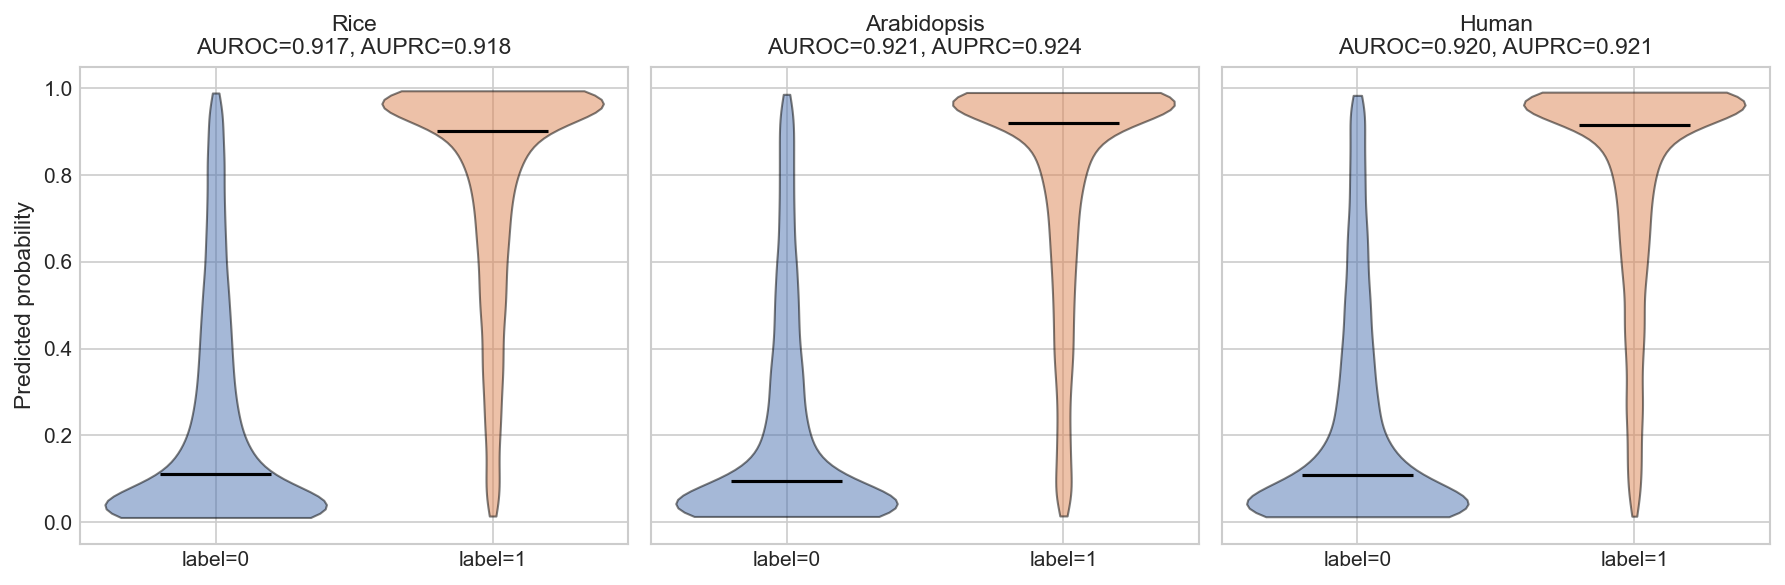

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

files = {
    "Rice":        "result/test_predictions_methynano_rice.csv",
    "Arabidopsis": "result/test_predictions_methynano_ninanjie.csv",
    "Human":       "result/test_predictions_methynano_people.csv",
}

metrics = {
    "Rice":        {"auroc": 0.917, "auprc": 0.918},
    "Arabidopsis": {"auroc": 0.921, "auprc": 0.924},
    "Human":       {"auroc": 0.920, "auprc": 0.921},
}

plt.style.use("seaborn-v0_8-whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
axes = np.atleast_1d(axes)

for ax, (name, path) in zip(axes, files.items()):
    df = pd.read_csv(path)

    p0 = df.loc[df["label_true"] == 0, "prob_pos"].values
    p1 = df.loc[df["label_true"] == 1, "prob_pos"].values

    p0 = p0 if len(p0) > 0 else np.array([np.nan])
    p1 = p1 if len(p1) > 0 else np.array([np.nan])

    data = [p0, p1]

    parts = ax.violinplot(
        data,
        positions=[0, 1],
        showmeans=False,
        showmedians=True, 
        showextrema=False,
        widths=0.8,
    )


    colors = ["#4C72B0", "#DD8452"]
    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(colors[i])
        pc.set_edgecolor("black")
        pc.set_alpha(0.5)


    if "cmedians" in parts:
        parts["cmedians"].set_color("black")
        parts["cmedians"].set_linewidth(1.5)

 
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["label=0", "label=1"])

    ax.set_ylim(-0.05, 1.05)

    if name in metrics:
        m = metrics[name]
        title = f"{name}\nAUROC={m['auroc']:.3f}, AUPRC={m['auprc']:.3f}"
    else:
        title = name
    ax.set_title(title, fontsize=11)

    if ax is axes[0]:
        ax.set_ylabel("Predicted probability", fontsize=11)
    else:
        ax.set_ylabel("")

plt.tight_layout()
plt.show()



Processed DeepPlant: AUROC=0.9163, AUPRC=0.9198
Processed MethyNano: AUROC=0.9208, AUPRC=0.9239
Processed NanoCon: AUROC=0.8243, AUPRC=0.8285
Processed remora: AUROC=0.8446, AUPRC=0.8457
Processed rockfish: AUROC=0.8875, AUPRC=0.8867


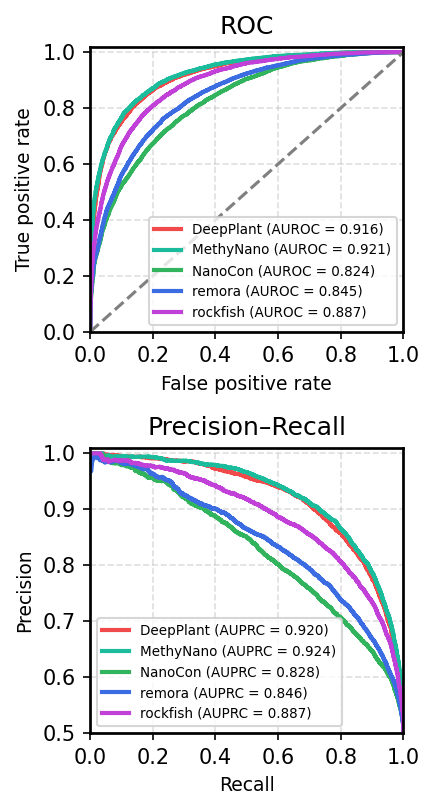

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['figure.dpi'] = 150

files = {
    'DeepPlant': 'result/test_predictions_bilstm_ninanjie.csv',
    'MethyNano': 'result/test_predictions_methynano_ninanjie.csv',
    'NanoCon':  'result/test_predictions_nanocon_ninanjie.csv',
    'remora':   'result/test_predictions_remora_ninanjie.csv',
    'rockfish': 'result/test_predictions_rockfish_ninanjie.csv'
}

colors = [
    '#F04A4A', 
    '#1ABC9C', 
    '#32B45F',
    '#3B6CE1',  
    '#C040D8', 
]


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(3, 5.5))


for (name, filepath), color in zip(files.items(), colors):
    try:
        df = pd.read_csv(filepath)

        if 'label_true' in df.columns and 'prob_pos' in df.columns:
            y_true = df['label_true']
            y_scores = df['prob_pos']
        else:
            y_true = df.iloc[:, 1]
            y_scores = df.iloc[:, 3]

        # ROC
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        ax1.plot(fpr, tpr, color=color, lw=2,
                 label=f'{name} (AUROC = {roc_auc:.3f})')

        # PRC
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        auprc = average_precision_score(y_true, y_scores)
        ax2.plot(recall, precision, color=color, lw=2,
                 label=f'{name} (AUPRC = {auprc:.3f})')

        print(f"Processed {name}: AUROC={roc_auc:.4f}, AUPRC={auprc:.4f}")

    except Exception as e:
        print(f"Error processing {name} at {filepath}: {e}")


ax1.plot([0, 1], [0, 1], color='grey', lw=1.5, linestyle='--')
ax1.set_xlim(0.0, 1.0)
ax1.set_ylim(0.0, 1.02)
ax1.set_xlabel('False positive rate', fontsize=9)
ax1.set_ylabel('True positive rate', fontsize=9)
ax1.set_title('ROC', fontsize=12)
ax1.legend(loc="lower right", fontsize=6.5)
ax1.grid(True, linestyle='--', alpha=0.4)

ax2.set_xlim(0.0, 1.0)

ax2.set_ylim(0.5, 1.01)
ax2.set_xlabel('Recall', fontsize=9)
ax2.set_ylabel('Precision', fontsize=9)
ax2.set_title('Precision–Recall', fontsize=12)
ax2.legend(loc="lower left", fontsize=6.5)
ax2.grid(True, linestyle='--', alpha=0.4)

for ax in (ax1, ax2):
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.3)

plt.tight_layout()
plt.savefig('comparison_curves.png', dpi=300, bbox_inches='tight')
plt.show()


Processed DeepPlant: AUROC=0.9135, AUPRC=0.9148
Processed MethyNano: AUROC=0.9201, AUPRC=0.9209
Processed NanoCon: AUROC=0.8222, AUPRC=0.8251
Processed remora: AUROC=0.8438, AUPRC=0.8451
Processed rockfish: AUROC=0.8865, AUPRC=0.8844


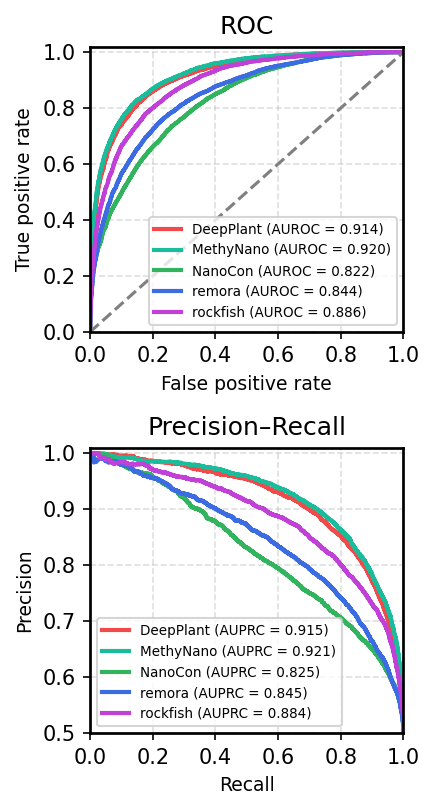

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['figure.dpi'] = 150

files = {
    'DeepPlant': 'result/test_predictions_bilstm_people.csv',
    'MethyNano': 'result/test_predictions_methynano_people.csv',
    'NanoCon':  'result/test_predictions_nanocon_people.csv',
    'remora':   'result/test_predictions_remora_people.csv',
    'rockfish': 'result/test_predictions_rockfish_people.csv'
}

colors = [
    '#F04A4A', 
    '#1ABC9C', 
    '#32B45F', 
    '#3B6CE1',
    '#C040D8',  
]


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(3, 5.5))


for (name, filepath), color in zip(files.items(), colors):
    try:
        df = pd.read_csv(filepath)

        if 'label_true' in df.columns and 'prob_pos' in df.columns:
            y_true = df['label_true']
            y_scores = df['prob_pos']
        else:
            y_true = df.iloc[:, 1]
            y_scores = df.iloc[:, 3]

        # ROC
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        ax1.plot(fpr, tpr, color=color, lw=2,
                 label=f'{name} (AUROC = {roc_auc:.3f})')

        # PRC
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        auprc = average_precision_score(y_true, y_scores)
        ax2.plot(recall, precision, color=color, lw=2,
                 label=f'{name} (AUPRC = {auprc:.3f})')

        print(f"Processed {name}: AUROC={roc_auc:.4f}, AUPRC={auprc:.4f}")

    except Exception as e:
        print(f"Error processing {name} at {filepath}: {e}")


ax1.plot([0, 1], [0, 1], color='grey', lw=1.5, linestyle='--')
ax1.set_xlim(0.0, 1.0)
ax1.set_ylim(0.0, 1.02)
ax1.set_xlabel('False positive rate', fontsize=9)
ax1.set_ylabel('True positive rate', fontsize=9)
ax1.set_title('ROC', fontsize=12)
ax1.legend(loc="lower right", fontsize=6.5)
ax1.grid(True, linestyle='--', alpha=0.4)


ax2.set_xlim(0.0, 1.0)

ax2.set_ylim(0.5, 1.01)
ax2.set_xlabel('Recall', fontsize=9)
ax2.set_ylabel('Precision', fontsize=9)
ax2.set_title('Precision–Recall', fontsize=12)
ax2.legend(loc="lower left", fontsize=6.5)
ax2.grid(True, linestyle='--', alpha=0.4)

for ax in (ax1, ax2):
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.3)

plt.tight_layout()
plt.savefig('comparison_curves.png', dpi=300, bbox_inches='tight')
plt.show()


Processed DeepPlant: AUROC=0.9150, AUPRC=0.9159
Processed MethyNano: AUROC=0.9167, AUPRC=0.9179
Processed NanoCon: AUROC=0.8263, AUPRC=0.8295
Processed remora: AUROC=0.8426, AUPRC=0.8427
Processed rockfish: AUROC=0.8882, AUPRC=0.8866


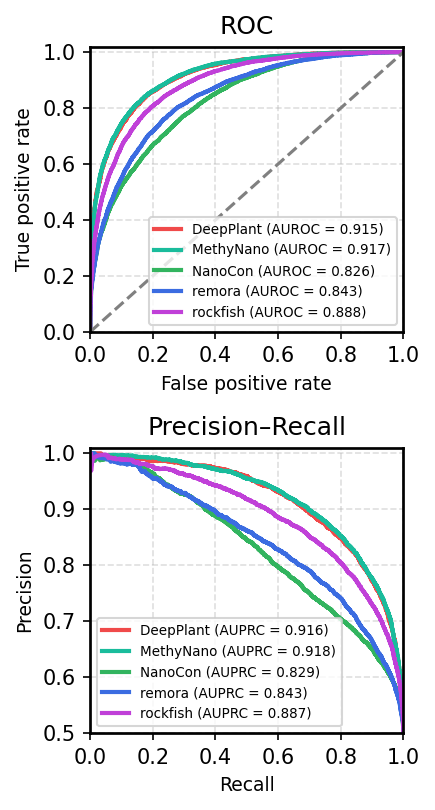

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['figure.dpi'] = 150

files = {
    'DeepPlant': 'result/test_predictions_bilstm_rice.csv',
    'MethyNano': 'result/test_predictions_methynano_rice.csv',
    'NanoCon':  'result/test_predictions_nanocon_rice.csv',
    'remora':   'result/test_predictions_remora_rice.csv',
    'rockfish': 'result/test_predictions_rockfish_rice.csv'
}


colors = [
    '#F04A4A', 
    '#1ABC9C',  
    '#32B45F',  
    '#3B6CE1', 
    '#C040D8',  
]


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(3, 5.5))


for (name, filepath), color in zip(files.items(), colors):
    try:
        df = pd.read_csv(filepath)

        if 'label_true' in df.columns and 'prob_pos' in df.columns:
            y_true = df['label_true']
            y_scores = df['prob_pos']
        else:
            y_true = df.iloc[:, 1]
            y_scores = df.iloc[:, 3]

        # ROC
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        ax1.plot(fpr, tpr, color=color, lw=2,
                 label=f'{name} (AUROC = {roc_auc:.3f})')

        # PRC
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        auprc = average_precision_score(y_true, y_scores)
        ax2.plot(recall, precision, color=color, lw=2,
                 label=f'{name} (AUPRC = {auprc:.3f})')

        print(f"Processed {name}: AUROC={roc_auc:.4f}, AUPRC={auprc:.4f}")

    except Exception as e:
        print(f"Error processing {name} at {filepath}: {e}")


ax1.plot([0, 1], [0, 1], color='grey', lw=1.5, linestyle='--')
ax1.set_xlim(0.0, 1.0)
ax1.set_ylim(0.0, 1.02)
ax1.set_xlabel('False positive rate', fontsize=9)
ax1.set_ylabel('True positive rate', fontsize=9)
ax1.set_title('ROC', fontsize=12)
ax1.legend(loc="lower right", fontsize=6.5)
ax1.grid(True, linestyle='--', alpha=0.4)

ax2.set_xlim(0.0, 1.0)

ax2.set_ylim(0.5, 1.01)
ax2.set_xlabel('Recall', fontsize=9)
ax2.set_ylabel('Precision', fontsize=9)
ax2.set_title('Precision–Recall', fontsize=12)
ax2.legend(loc="lower left", fontsize=6.5)
ax2.grid(True, linestyle='--', alpha=0.4)


for ax in (ax1, ax2):
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.3)

plt.tight_layout()
plt.savefig('comparison_curves.png', dpi=300, bbox_inches='tight')
plt.show()


成功读取文件: result/test_predictions_bilstm_ninanjie.csv, 共 20000 行数据
Spearman Correlation: 0.9971


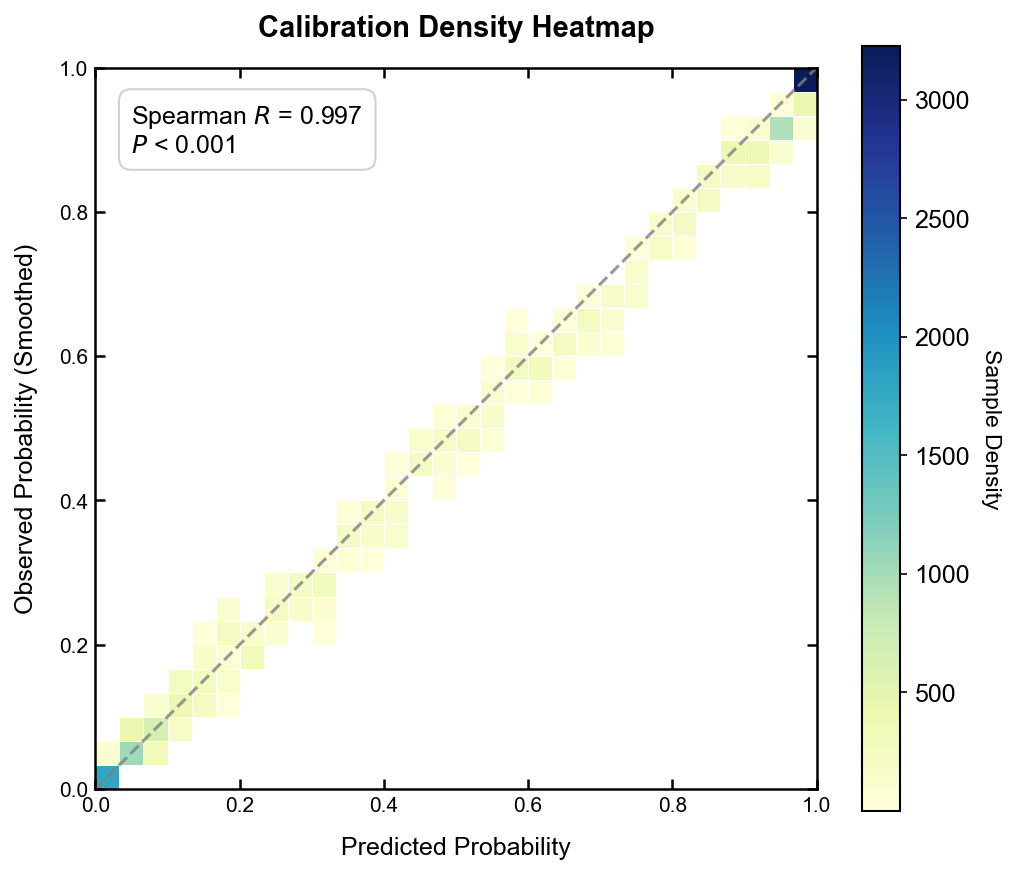

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import spearmanr
import matplotlib.cm as cm


file_path = "result/test_predictions_bilstm_ninanjie.csv"

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    print(f"Successfully loaded file: {file_path}, with {len(df)} rows of data")
else:
    print("No file found, generating simulated data for demonstration...")
    np.random.seed(42)
    n = 2000
    probs = np.random.beta(2, 2, n)
    labels = np.random.binomial(1, probs)
    df = pd.DataFrame({"label_true": labels, "prob_pos": probs})

y_true = df["label_true"].values
y_prob = df["prob_pos"].values

sorted_indices = np.argsort(y_prob)
y_prob_sorted = y_prob[sorted_indices]
y_true_sorted = y_true[sorted_indices]

window_size = max(int(len(df) * 0.015), 15) 
y_true_smoothed = pd.Series(y_true_sorted).rolling(
    window=window_size, center=True, min_periods=1
).mean()


mask = ~np.isnan(y_true_smoothed)
X = y_prob_sorted[mask]
Y = y_true_smoothed[mask]

rho, p_val = spearmanr(X, Y)
print(f"Spearman Correlation: {rho:.4f}")

fig, ax = plt.subplots(figsize=(7, 6))

plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif', 'font.sans-serif': ['Arial', 'DejaVu Sans']})

h = ax.hist2d(
    X, Y, 
    bins=30, 
    cmap="YlGnBu",
    range=[[0, 1], [0, 1]],
    cmin=1
)

quadmesh = h[3]
quadmesh.set_edgecolor('white')
quadmesh.set_linewidth(0.3)

cbar = plt.colorbar(h[3], ax=ax)
cbar.set_label('Sample Density', rotation=270, labelpad=15, fontsize=11)
cbar.outline.set_linewidth(1) # colorbar 边框

ax.plot([0, 1], [0, 1], linestyle="--", color="gray", linewidth=1.5, alpha=0.8, label="Ideal")

stats_text = f"Spearman $R$ = {rho:.3f}\n$P$ < 0.001"
ax.text(
    0.05, 0.95, stats_text, 
    transform=ax.transAxes, 
    fontsize=12, 
    fontweight='medium',
    verticalalignment='top',
    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='#CCCCCC')
)

ax.set_xlabel("Predicted Probability", fontsize=12, labelpad=10)
ax.set_ylabel("Observed Probability (Smoothed)", fontsize=12, labelpad=10)
ax.set_title("Calibration Density Heatmap", fontsize=14, fontweight='bold', pad=15)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect('equal') 

for spine in ax.spines.values():
    spine.set_linewidth(1.2)
    spine.set_edgecolor('black')
ax.tick_params(direction='in', length=5, width=1.2, top=True, right=True)

plt.tight_layout()
plt.show()

成功读取文件: result/test_predictions_bilstm_ninanjie.csv, 共 20000 行数据


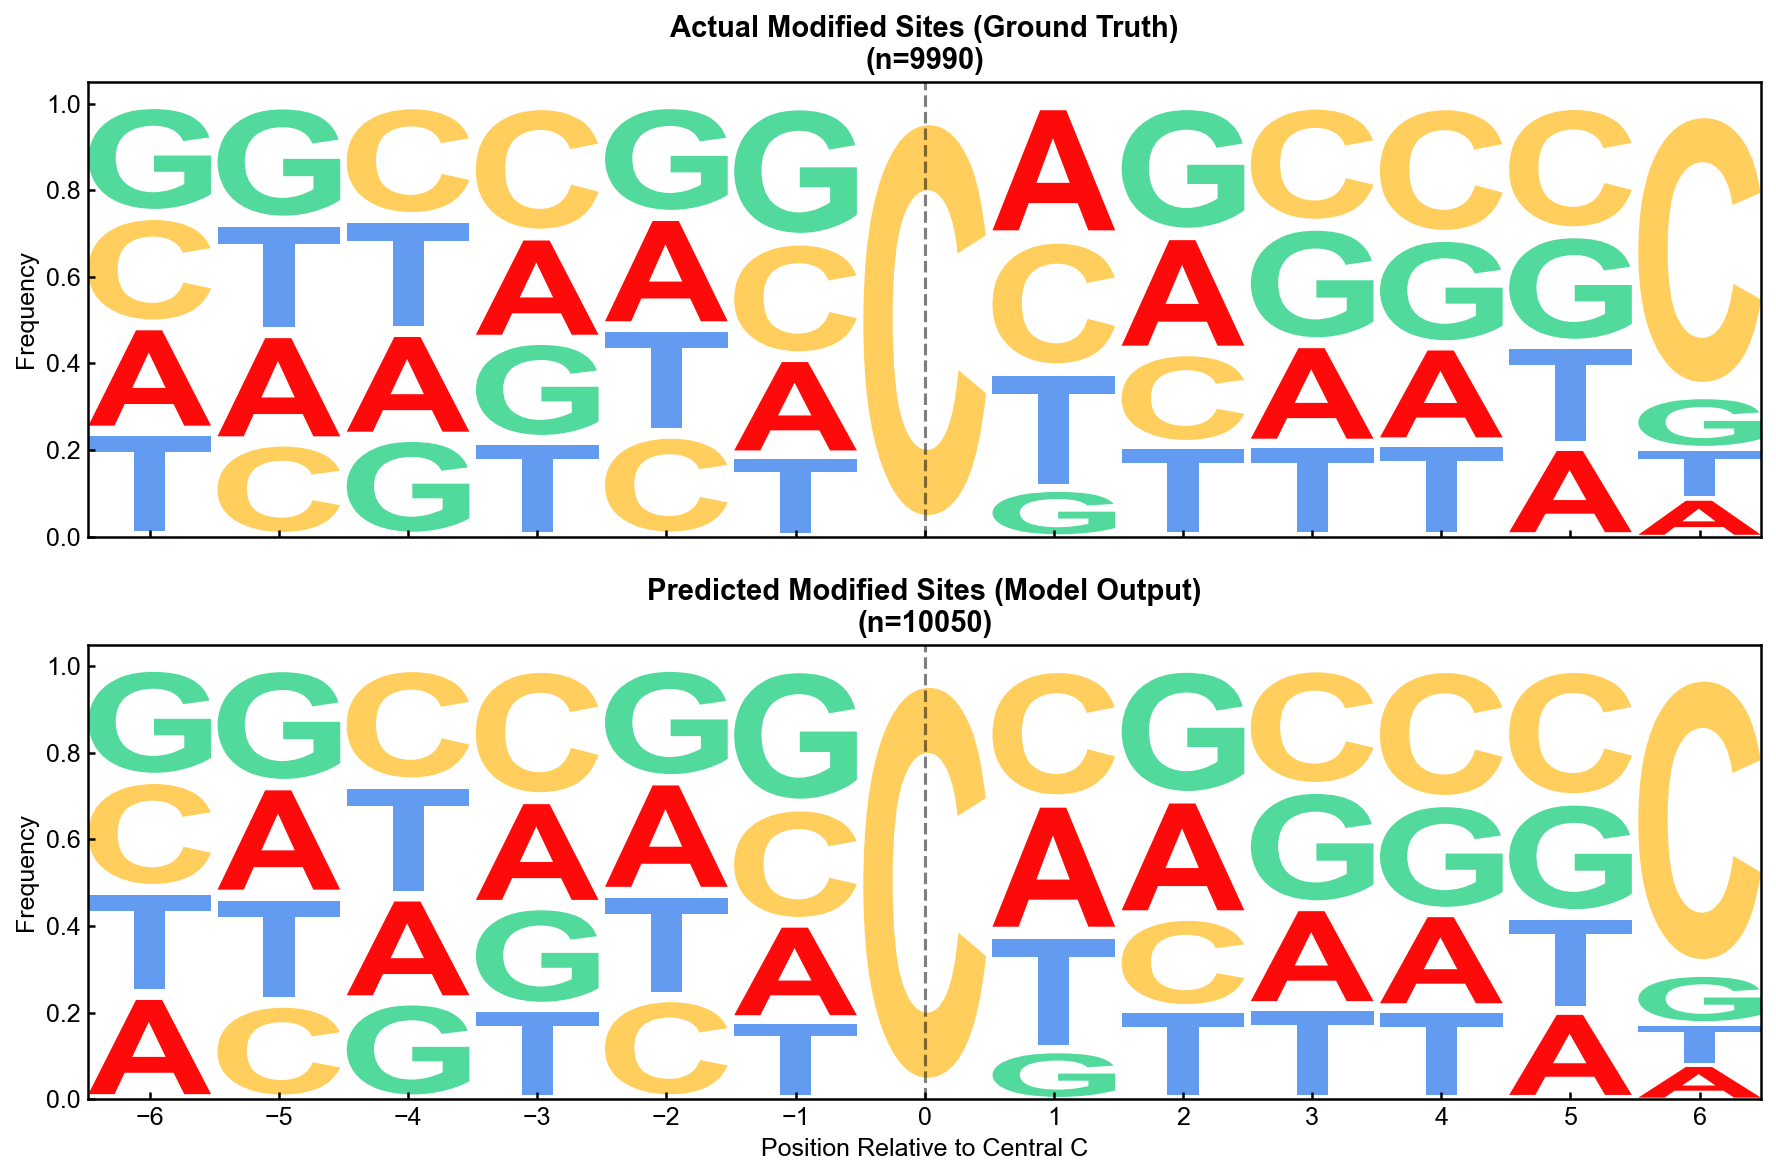

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import logomaker
import numpy as np
import os

file_path = "result/test_predictions_bilstm_ninanjie.csv"

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    print(f"Successfully loaded file: {file_path}, with {len(df)} rows of data")
else:
    print(f"Error: File not found {file_path}. Please ensure the file is in the current directory.")
    exit()

# Check required columns
required_cols = ['seq_13mer', 'label_true', 'label_pred']
if not all(col in df.columns for col in required_cols):
    print(f"Error: Required columns missing in CSV file: {required_cols}")
    exit()


def calculate_pfm(sequences):

    if len(sequences) == 0:
        return None
 
    seq_matrix = np.array([list(seq) for seq in sequences])

    pfm = pd.DataFrame(0, index=range(-6, 7), columns=['A', 'C', 'G', 'T'])
    
    for i, pos in enumerate(range(-6, 7)):
        counts = pd.Series(seq_matrix[:, i]).value_counts()
        for base in ['A', 'C', 'G', 'T']:
            pfm.loc[pos, base] = counts.get(base, 0)

    pfm = pfm.div(pfm.sum(axis=1), axis=0).fillna(0)
    return pfm

seqs_true = df[df["label_true"] == 1]["seq_13mer"]
pfm_true = calculate_pfm(seqs_true)

seqs_pred = df[df["label_pred"] == 1]["seq_13mer"]
pfm_pred = calculate_pfm(seqs_pred)

color_scheme = {
    'A': '#FF0A0A', 
    'C': '#FFCE5C', 
    'G': '#52D99C', 
    'T': '#629BEF'  
}

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True, sharey=True)

if pfm_true is not None:
    logo_true = logomaker.Logo(pfm_true,
                               ax=axes[0],
                               color_scheme=color_scheme,
                               vpad=.1,
                               stack_order='big_on_top')
    axes[0].set_title(f"Actual Modified Sites (Ground Truth)\n(n={len(seqs_true)})", fontsize=14, fontweight='bold')
    axes[0].set_ylabel("Frequency", fontsize=12)
    axes[0].axvline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.5) 

if pfm_pred is not None:
    logo_pred = logomaker.Logo(pfm_pred,
                               ax=axes[1],
                               color_scheme=color_scheme,
                               vpad=.1,
                               stack_order='big_on_top')
    axes[1].set_title(f"Predicted Modified Sites (Model Output)\n(n={len(seqs_pred)})", fontsize=14, fontweight='bold')
    axes[1].set_xlabel("Position Relative to Central C", fontsize=12)
    axes[1].set_ylabel("Frequency", fontsize=12)
    axes[1].axvline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.5) 


for ax in axes:
    ax.set_xticks(range(-6, 7))
    ax.set_ylim(0, 1.05)

    for spine in ax.spines.values():
        spine.set_linewidth(1.2)
    ax.tick_params(direction='in', width=1.2)

plt.tight_layout()
plt.show()

成功读取文件: result/test_predictions_bilstm_people.csv, 共 20000 行数据


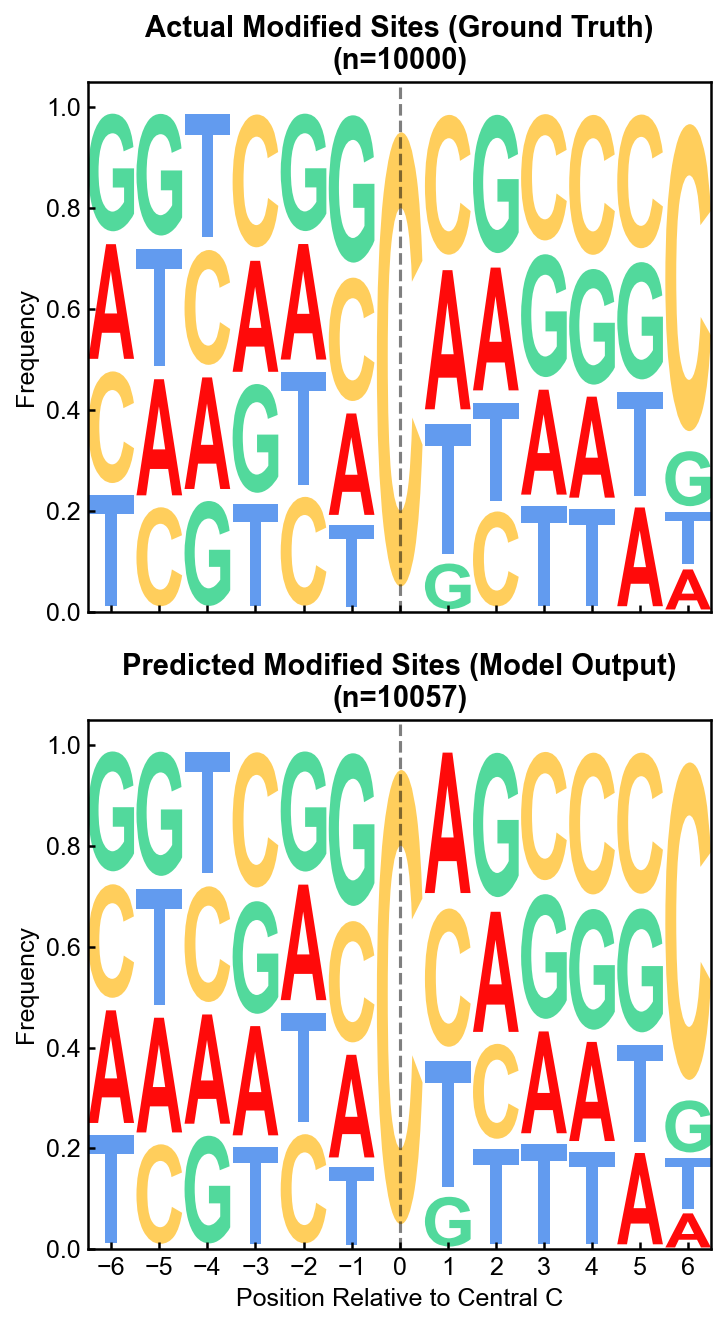

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import logomaker
import numpy as np
import os

file_path = "result/test_predictions_bilstm_people.csv"

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    print(f"Successfully loaded file: {file_path}, with {len(df)} rows of data")
else:
    print(f"Error: File not found {file_path}. Please ensure the file is in the current directory.")
    exit()

required_cols = ['seq_13mer', 'label_true', 'label_pred']
if not all(col in df.columns for col in required_cols):
    print(f"Error: Required columns missing in CSV file: {required_cols}")
    exit()

def calculate_pfm(sequences):
 
    if len(sequences) == 0:
        return None
    
 
    seq_matrix = np.array([list(seq) for seq in sequences])

    pfm = pd.DataFrame(0, index=range(-6, 7), columns=['A', 'C', 'G', 'T'])

    for i, pos in enumerate(range(-6, 7)):
        counts = pd.Series(seq_matrix[:, i]).value_counts()
        for base in ['A', 'C', 'G', 'T']:
            pfm.loc[pos, base] = counts.get(base, 0)

    pfm = pfm.div(pfm.sum(axis=1), axis=0).fillna(0)
    return pfm


seqs_true = df[df["label_true"] == 1]["seq_13mer"]
pfm_true = calculate_pfm(seqs_true)

seqs_pred = df[df["label_pred"] == 1]["seq_13mer"]
pfm_pred = calculate_pfm(seqs_pred)


color_scheme = {
    'A': '#FF0A0A', 
    'C': '#FFCE5C', 
    'G': '#52D99C', 
    'T': '#629BEF'  
}

fig, axes = plt.subplots(2, 1, figsize=(5, 9), sharex=True, sharey=True)


if pfm_true is not None:
    logo_true = logomaker.Logo(pfm_true,
                               ax=axes[0],
                               color_scheme=color_scheme,
                               vpad=.1,
                               stack_order='big_on_top')
    axes[0].set_title(f"Actual Modified Sites (Ground Truth)\n(n={len(seqs_true)})", fontsize=14, fontweight='bold')
    axes[0].set_ylabel("Frequency", fontsize=12)
    axes[0].axvline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.5) 

if pfm_pred is not None:
    logo_pred = logomaker.Logo(pfm_pred,
                               ax=axes[1],
                               color_scheme=color_scheme,
                               vpad=.1,
                               stack_order='big_on_top')
    axes[1].set_title(f"Predicted Modified Sites (Model Output)\n(n={len(seqs_pred)})", fontsize=14, fontweight='bold')
    axes[1].set_xlabel("Position Relative to Central C", fontsize=12)
    axes[1].set_ylabel("Frequency", fontsize=12)
    axes[1].axvline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.5) # 标记中心位置

for ax in axes:
    ax.set_xticks(range(-6, 7))
    ax.set_ylim(0, 1.05) 

    for spine in ax.spines.values():
        spine.set_linewidth(1.2)
    ax.tick_params(direction='in', width=1.2)

plt.tight_layout()
plt.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_56004\1313782459.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


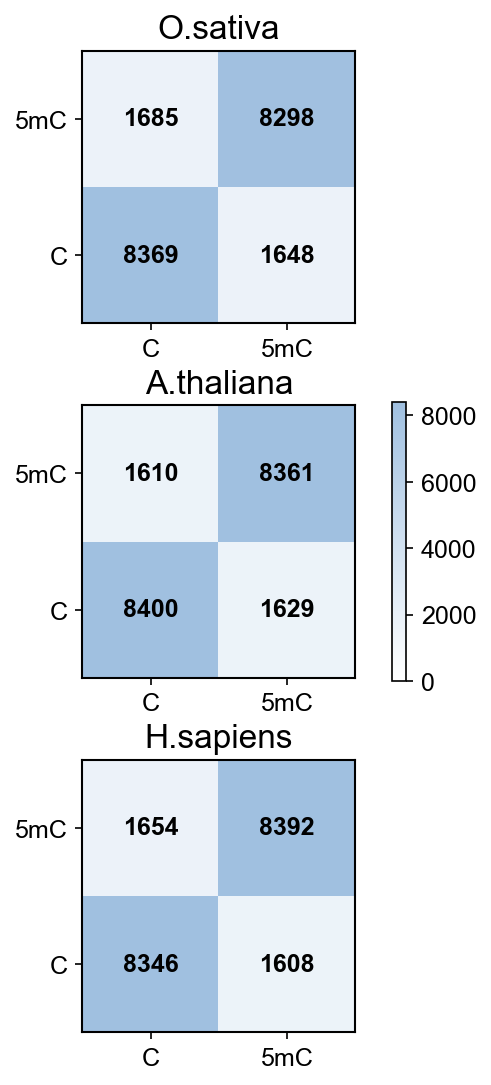

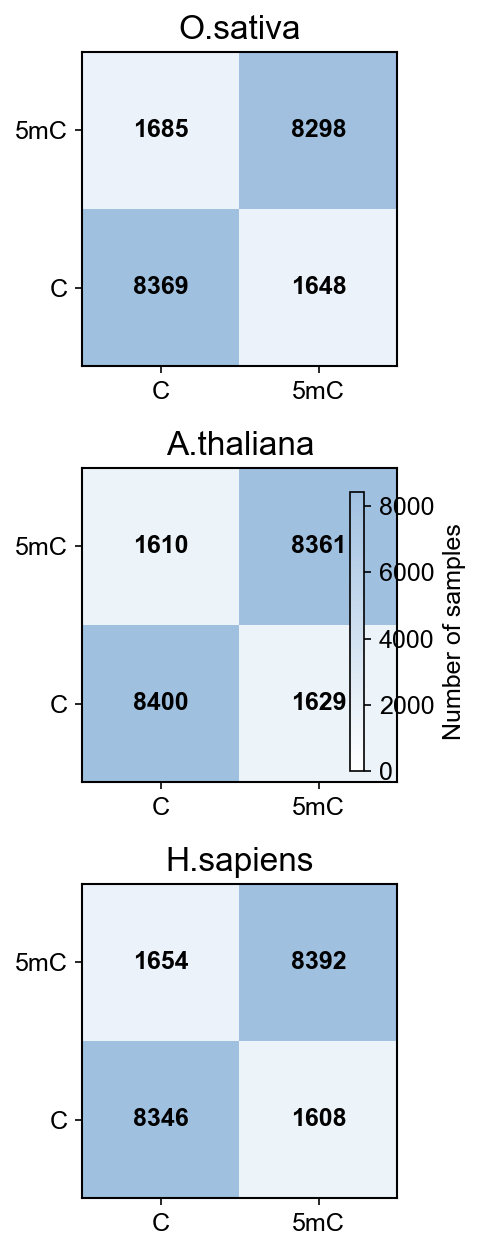

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize

files = {
    "O.sativa":   "result/test_predictions_methynano_rice.csv",
    "A.thaliana": "result/test_predictions_methynano_ninanjie.csv",
    "H.sapiens":  "result/test_predictions_methynano_people.csv",
}

label_names = {0: "C", 1: "5mC"}

def load_and_confmat(path, thresh=0.5):
    df = pd.read_csv(path)

    if "label_true" in df.columns:
        y_true = df["label_true"].astype(int).values
    else:
        y_true = df.iloc[:, 1].astype(int).values

    if "prob_pos" in df.columns:
        y_score = df["prob_pos"].values
    else:
        y_score = df.iloc[:, 3].values

    y_pred = (y_score >= thresh).astype(int)

    cm = np.zeros((2, 2), dtype=int)
    for t, p in zip(y_true, y_pred):
        if t in (0, 1) and p in (0, 1):
            cm[p, t] += 1
    return cm

confmats = {name: load_and_confmat(path) for name, path in files.items()}
vmax = max(cm.max() for cm in confmats.values())


colors = ["#FFFFFF", "#D0E0F0", "#A0C0E0"]
soft_blue_cyan = LinearSegmentedColormap.from_list(
    "soft_blue_cyan", colors, N=256
)
norm = Normalize(vmin=0, vmax=vmax)

fig, axes = plt.subplots(3, 1, figsize=(4, 8.5))
plt.subplots_adjust(hspace=0.3)

for ax, (name, cm) in zip(axes, confmats.items()):
    im = ax.imshow(
        cm,
        cmap=soft_blue_cyan,  
        norm=norm,
        origin="lower",
        aspect="equal",
    )

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels([label_names[0], label_names[1]])
    ax.set_yticklabels([label_names[0], label_names[1]])
    ax.set_title(name, fontsize=16)

    for i in range(2):
        for j in range(2):
            val = cm[i, j]
            ax.text(
                j, i, str(val),
                ha="center", va="center",
                color="black",  
                fontsize=12,
                fontweight="bold",
            )


    for spine in ax.spines.values():
        spine.set_edgecolor("black")
        spine.set_linewidth(1.0)


cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.03, pad=0.08)
cbar.set_label("Number of samples")

plt.tight_layout()
plt.show()




Cross-species table (train on A.thaliana):
Dataset    A.thaliana  H.sapiens  O.sativa
Metric                                    
Precision      0.8384     0.8041    0.8101
Accuracy       0.8363     0.7963    0.8044
Recall         0.8321     0.8052    0.7963
F1-score       0.8352     0.7871    0.7970
AUROC          0.9202     0.8741    0.8821
AUPRC          0.9215     0.8730    0.8870


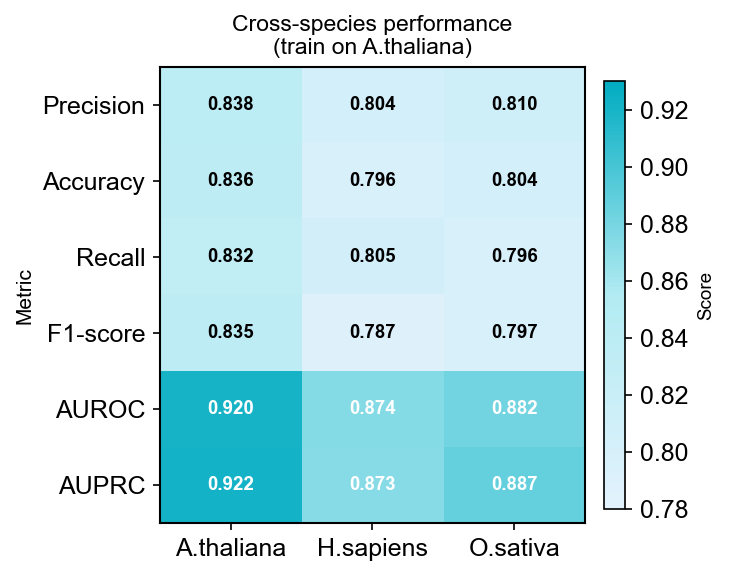

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


data = {
    "Metric": [
        "Precision", "Precision", "Precision",
        "Accuracy",  "Accuracy",  "Accuracy",
        "Recall",    "Recall",    "Recall",
        "F1-score",  "F1-score",  "F1-score",
        "AUROC",     "AUROC",     "AUROC",
        "AUPRC",     "AUPRC",     "AUPRC",
    ],
    "Dataset": [
        "A.thaliana", "H.sapiens", "O.sativa",
        "A.thaliana", "H.sapiens", "O.sativa",
        "A.thaliana", "H.sapiens", "O.sativa",
        "A.thaliana", "H.sapiens", "O.sativa",
        "A.thaliana", "H.sapiens", "O.sativa",
        "A.thaliana", "H.sapiens", "O.sativa",
    ],
    "MethyNano": [
        0.838385369, 0.8041,      0.8101,   # Precision
        0.836325,    0.7963,      0.8044,   # Accuracy
        0.832121546, 0.8052,      0.7963,   # Recall
        0.835241714, 0.7871,      0.7970,   # F1-score
        0.920211492, 0.8741,      0.8821,   # AUROC
        0.921528327, 0.8730,      0.8870,   # AUPRC
    ],
}

df = pd.DataFrame(data)


pivot = df.pivot(index="Metric", columns="Dataset", values="MethyNano")

pivot = pivot.loc[["Precision", "Accuracy", "Recall", "F1-score", "AUROC", "AUPRC"]]

print("Cross-species table (train on A.thaliana):")
print(pivot.round(4))

cmap = LinearSegmentedColormap.from_list(
    "blue_cyan_soft",
    [
        "#E3F2FD", 
        "#B2EBF2", 
        "#00ACC1", 
    ]
)


vmin = 0.78
vmax = 0.93


fig, ax = plt.subplots(figsize=(5, 4))

im = ax.imshow(pivot.values, cmap=cmap, vmin=vmin, vmax=vmax, aspect="auto")

ax.set_xticks(np.arange(pivot.shape[1]))
ax.set_yticks(np.arange(pivot.shape[0]))
ax.set_xticklabels(pivot.columns)
ax.set_yticklabels(pivot.index)

ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)

for i in range(pivot.shape[0]):
    for j in range(pivot.shape[1]):
        val = pivot.values[i, j]
        text_color = "black" if val < (vmin + vmax) / 2 else "white"
        ax.text(
            j, i,
            f"{val:.3f}",
            ha="center", va="center",
            color=text_color,
            fontsize=9,
            fontweight="bold",
        )

for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.0)


ax.set_ylabel("Metric", fontsize=10)
ax.set_title("Cross-species performance\n(train on A.thaliana)", fontsize=11)

cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Score", fontsize=9)

plt.tight_layout()
plt.show()


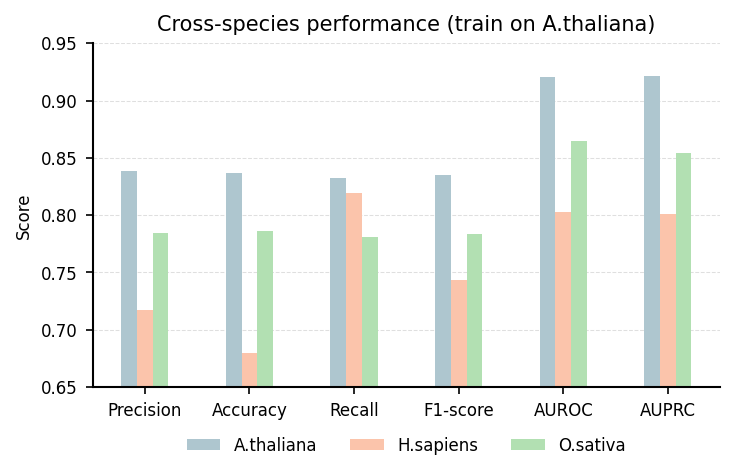

In [86]:
import numpy as np
import matplotlib.pyplot as plt


metrics = ["Precision", "Accuracy", "Recall", "F1-score", "AUROC", "AUPRC"]
datasets = ["A.thaliana", "H.sapiens", "O.sativa"]


vals_ath = [0.838385369, 0.836325,    0.832121546, 0.835241714, 0.920211492, 0.921528327]
vals_hum = [0.7169,      0.68,      0.8194,      0.7432,      0.8028,      0.801]
vals_rice= [0.7843,      0.7863,      0.7807,      0.7835,      0.8643,      0.8546]

vals = np.array([vals_ath, vals_hum, vals_rice])  # shape (3, 6)

x = np.arange(len(metrics))         

bar_width = 0.15 


colors = ["#AEC6CF", "#FBC4AB", "#B2E0B2"]

fig, ax = plt.subplots(figsize=(5, 3.3))

ax.bar(x - bar_width,     vals[0], width=bar_width, color=colors[0], label="A.thaliana")
ax.bar(x,                 vals[1], width=bar_width, color=colors[1], label="H.sapiens")
ax.bar(x + bar_width,     vals[2], width=bar_width, color=colors[2], label="O.sativa")

ax.set_ylim(0.65, 0.95)
plt.yticks([0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95], fontsize=8)

ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=0, fontsize=8)

ax.set_ylabel("Score", fontsize=8)
ax.set_title("Cross-species performance (train on A.thaliana)", fontsize=10)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
for spine in ["left", "bottom"]:
    ax.spines[spine].set_linewidth(1.0)
    ax.spines[spine].set_edgecolor("black")

ax.yaxis.grid(True, linestyle="--", linewidth=0.5, alpha=0.4)
ax.set_axisbelow(True)

ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1),
          ncol=3, frameon=False, fontsize=8)

plt.tight_layout()
# plt.savefig("cross_species_bar_thin.png", dpi=300, bbox_inches="tight")
plt.show()

✅ 成功加载 4999 个样本
📊 数据形状: nano=torch.Size([4999, 13, 103]), label=torch.Size([4999])
✅ 成功加载 4999 个样本
📊 数据形状: nano=torch.Size([4999, 13, 103]), label=torch.Size([4999])
✅ 成功加载 20000 个样本
📊 数据形状: nano=torch.Size([20000, 13, 103]), label=torch.Size([20000])


C:\Users\Administrator\AppData\Local\Temp\ipykernel_56004\2233360404.py:86: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(all_data, labels=all_labels,


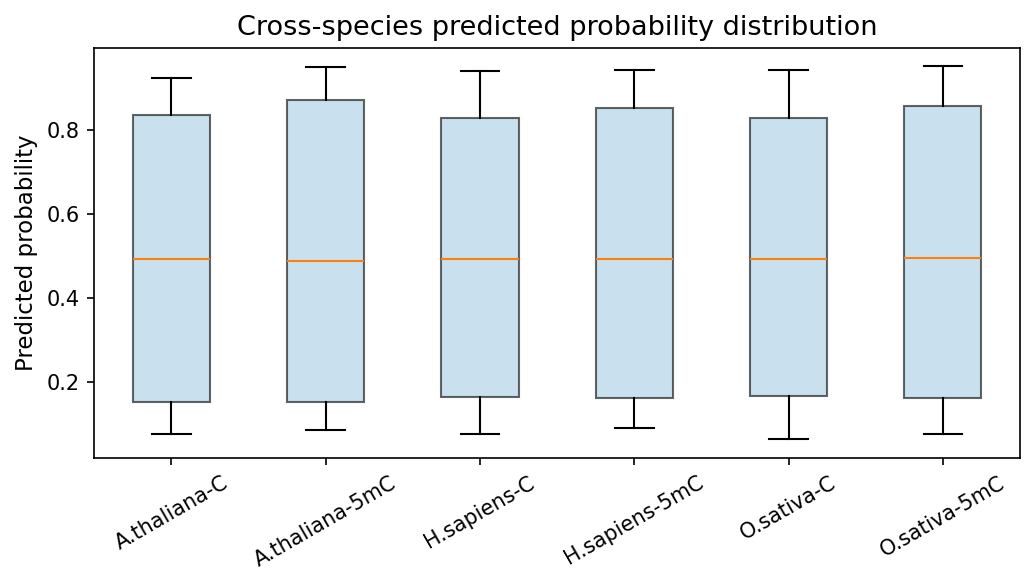

Processed A.thaliana: AUROC=0.9208, AUPRC=0.9239
Processed H.sapiens: AUROC=0.8028, AUPRC=0.8010
Processed O.sativa: AUROC=0.8669, AUPRC=0.8577


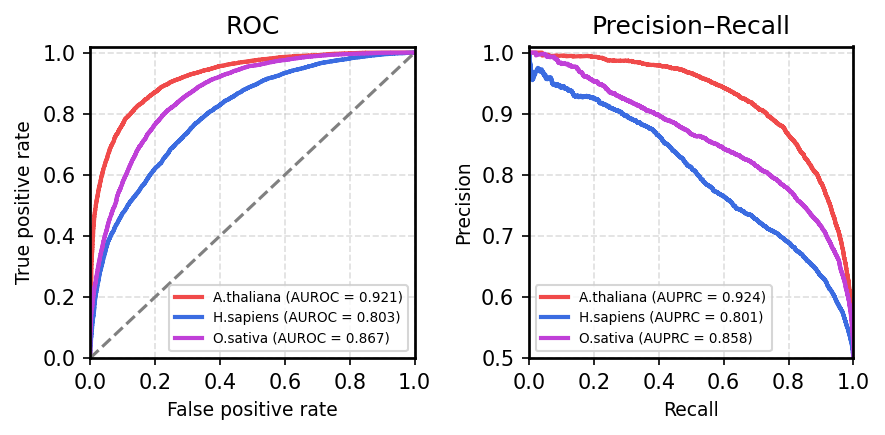

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['figure.dpi'] = 150

files = {
    'A.thaliana': r'C:\Users\Administrator\Desktop\720_based\MethyNano-v5\result\cross-species\test_predictions_methynano_ninanjie.csv',
    'H.sapiens':  r'C:\Users\Administrator\Desktop\720_based\MethyNano-v5\result\cross-species\test_predictions_methynano_people.csv',
    'O.sativa': r'C:\Users\Administrator\Desktop\720_based\MethyNano-v5\result\cross-species\test_predictions_methynano_rice.csv'
}


colors = [
    '#F04A4A', 
    '#3B6CE1',  
    '#C040D8', 
]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
for (name, filepath), color in zip(files.items(), colors):
    try:
        df = pd.read_csv(filepath)

        if 'label_true' in df.columns and 'prob_pos' in df.columns:
            y_true = df['label_true']
            y_scores = df['prob_pos']
        else:
            y_true = df.iloc[:, 1]
            y_scores = df.iloc[:, 3]

        # ROC
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        ax1.plot(fpr, tpr, color=color, lw=2,
                 label=f'{name} (AUROC = {roc_auc:.3f})')

        # PRC
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        auprc = average_precision_score(y_true, y_scores)
        ax2.plot(recall, precision, color=color, lw=2,
                 label=f'{name} (AUPRC = {auprc:.3f})')

        print(f"Processed {name}: AUROC={roc_auc:.4f}, AUPRC={auprc:.4f}")

    except Exception as e:
        print(f"Error processing {name} at {filepath}: {e}")

# 4. ROC 图设置
ax1.plot([0, 1], [0, 1], color='grey', lw=1.5, linestyle='--')
ax1.set_xlim(0.0, 1.0)
ax1.set_ylim(0.0, 1.02)
ax1.set_xlabel('False positive rate', fontsize=9)
ax1.set_ylabel('True positive rate', fontsize=9)
ax1.set_title('ROC', fontsize=12)
ax1.legend(loc="lower right", fontsize=6.5)
ax1.grid(True, linestyle='--', alpha=0.4)

# 5. PRC 图设置（y 轴不从 0 开始）
ax2.set_xlim(0.0, 1.0)
# 这里根据所有 precision 的最小值略微下放一点，比如 0.5；你可以按需要调整
ax2.set_ylim(0.5, 1.01)
ax2.set_xlabel('Recall', fontsize=9)
ax2.set_ylabel('Precision', fontsize=9)
ax2.set_title('Precision–Recall', fontsize=12)
ax2.legend(loc="lower left", fontsize=6.5)
ax2.grid(True, linestyle='--', alpha=0.4)

# 6. 统一设置黑色边框（四个方向）
for ax in (ax1, ax2):
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.3)

plt.tight_layout()
plt.savefig('comparison_curves.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_29608\3593804220.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.0)


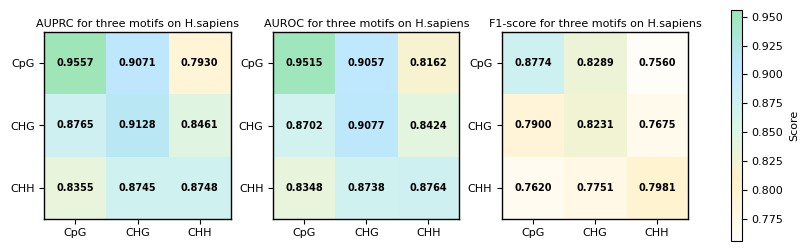

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# =========================
# 1. 手动录入矩阵（H.sapiens 训练）
#    行：train motif = CpG / CHG / CHH
#    列：test motif  = CpG / CHG / CHH
# =========================
motifs = ["CpG", "CHG", "CHH"]

# F1-score
F1 = np.array([
    [0.8774, 0.8289, 0.7560],
    [0.7900, 0.8231, 0.7675],
    [0.7620, 0.7751, 0.7981],
])

# AUROC
AUROC = np.array([
    [0.9515, 0.9057, 0.8162],
    [0.8702, 0.9077, 0.8424],
    [0.8348, 0.8738, 0.8764],
])

# AUPRC
AUPRC = np.array([
    [0.9557, 0.9071, 0.7930],
    [0.8765, 0.9128, 0.8461],
    [0.8355, 0.8745, 0.8748],
])

metrics = {
    "AUPRC": AUPRC,
    "AUROC": AUROC,
    "F1-score": F1,
}

# 统一颜色范围，便于对比
all_vals = np.concatenate([m.ravel() for m in metrics.values()])
vmin, vmax = all_vals.min(), all_vals.max()
mid = (vmin + vmax) / 2.0

# =========================
# ✅ 更漂亮的连续色带（深蓝→青绿→亮黄）
# =========================

cmap = LinearSegmentedColormap.from_list(
    "lemon_soda",
    ["#FFFDF7", "#FFF1C9", "#D9F7E8", "#BFE8FF", "#9EE6B8"]
)


# =========================
# 画 1×3 热图 + 右侧共用 colorbar（缩小字号版）
# =========================
fig = plt.figure(figsize=(9, 3))
gs = fig.add_gridspec(
    1, 4,
    width_ratios=[1, 1, 1, 0.06],
    wspace=0.3
)

axes = [fig.add_subplot(gs[0, i]) for i in range(3)]
cax   = fig.add_subplot(gs[0, 3])

last_im = None

for ax, (title, mat) in zip(axes, metrics.items()):
    im = ax.imshow(mat, cmap=cmap, vmin=vmin, vmax=vmax, origin="upper")
    last_im = im

    ax.set_xticks(np.arange(len(motifs)))
    ax.set_yticks(np.arange(len(motifs)))
    ax.set_xticklabels(motifs, fontsize=8)
    ax.set_yticklabels(motifs, fontsize=8)

    ax.set_title(f"{title} for three motifs on H.sapiens", fontsize=8, pad=4)

    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            val = mat[i, j]
            ax.text(
                j, i, f"{val:.4f}",
                ha="center", va="center",
                fontsize=7,
                color="black",
                fontweight="bold"
            )

    for spine in ax.spines.values():
        spine.set_edgecolor("black")
        spine.set_linewidth(1.0)

cbar = fig.colorbar(last_im, cax=cax)
cbar.set_label("Score", fontsize=8)
cbar.ax.tick_params(labelsize=8)

plt.tight_layout(pad=1.0)
plt.show()



Loading CHH from: C:\Users\Administrator\Desktop\720_based\MethyNano-v5\data\singletype\CHH.csv
Loading CHG from: C:\Users\Administrator\Desktop\720_based\MethyNano-v5\data\singletype\CHG.csv
Loading CpG from: C:\Users\Administrator\Desktop\720_based\MethyNano-v5\data\singletype\CpG.csv
  motif  position  label   mean    std
0   CHH         0      1  0.191  0.182
1   CHH         1      1 -0.004  0.149
2   CHH         2      1 -1.657  0.258
3   CHH         3      1 -0.477  0.450
4   CHH         4      1  0.144  0.099
Total records: 837200
Motif counts:
 motif
CHH    520000
CHG    234000
CpG     83200
Name: count, dtype: int64


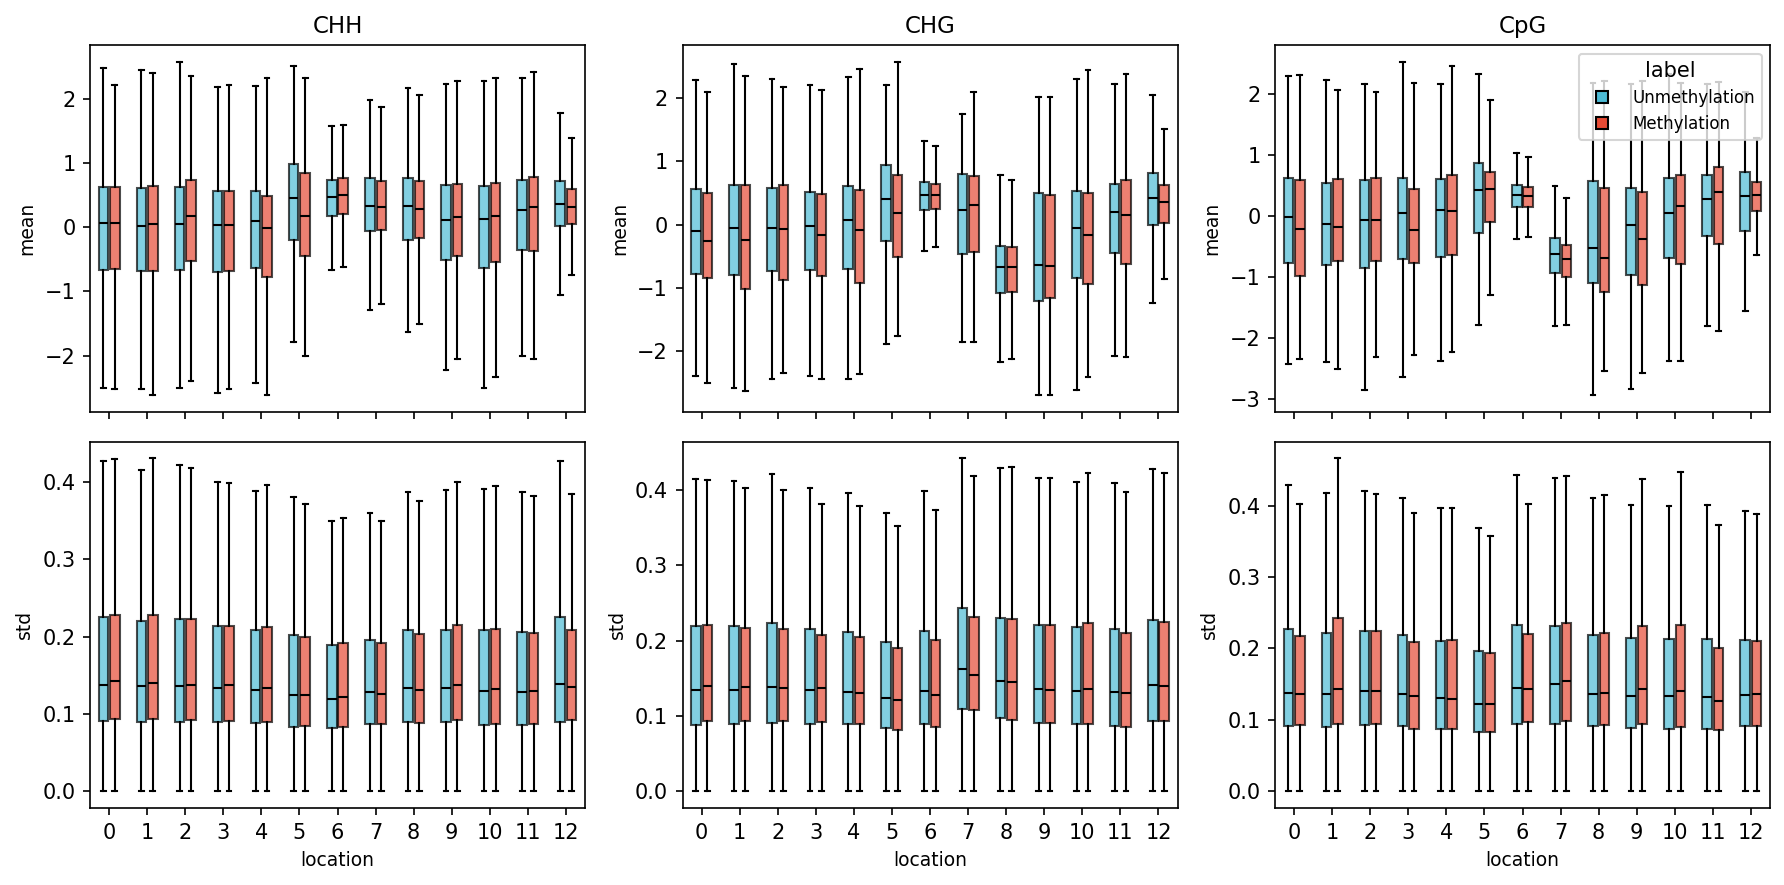

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# =======================
# 1. 三个 CSV 的路径（按实际修改）
# =======================
CSV_FILES = {
    "CHH": r"C:\Users\Administrator\Desktop\720_based\MethyNano-v5\data\singletype\CHH.csv",
    "CHG": r"C:\Users\Administrator\Desktop\720_based\MethyNano-v5\data\singletype\CHG.csv",
    "CpG": r"C:\Users\Administrator\Desktop\720_based\MethyNano-v5\data\singletype\CpG.csv",
}

CENTER_IDX = 6   # 13-mer 中心 C 的下标（如果你一直用 13-mer，这里不用改）

# =======================
# 2. 读入三个 CSV，展开 mean / std
# =======================
records = []

for motif_name, path in CSV_FILES.items():
    print(f"Loading {motif_name} from: {path}")
    df_raw = pd.read_csv(path)

    for _, row in df_raw.iterrows():
        label = int(row["methy_lable"])

        means = [float(x) for x in str(row["signal_means"]).split(",")]
        stds  = [float(x) for x in str(row["signal_stds"]).split(",")]

        # 防止有不是 13-mer 的脏数据
        if len(means) != 13 or len(stds) != 13:
            continue

        for pos in range(13):
            records.append({
                "motif": motif_name,   # 直接用文件对应的 motif
                "position": pos,       # 0 ~ 12
                "label": label,        # 0 / 1
                "mean": means[pos],
                "std":  stds[pos],
            })

df = pd.DataFrame(records)
print(df.head())
print("Total records:", len(df))
print("Motif counts:\n", df["motif"].value_counts())

# =======================
# 3. 2×3 箱线图：上排 mean，下排 std
# =======================
motif_order = ["CHH", "CHG", "CpG"]         # 图中的列顺序
colors = {0: "#4DBBD5", 1: "#E64B35"}      # 0/1 两类的颜色

fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=True)

for col_idx, motif in enumerate(motif_order):
    sub = df[df["motif"] == motif]

    # ================= 上排：mean =================
    ax_mean = axes[0, col_idx]

    for label_val, offset in [(0, -0.15), (1, 0.15)]:
        data = [
            sub[(sub["position"] == pos) & (sub["label"] == label_val)]["mean"].values
            for pos in range(13)
        ]
        positions = [pos + offset for pos in range(13)]

        bp = ax_mean.boxplot(
            data,
            positions=positions,
            widths=0.25,
            patch_artist=True,
            showfliers=False,
        )
        # 盒子填色+线条
        for box in bp["boxes"]:
            box.set_facecolor(colors[label_val])
            box.set_edgecolor("black")
            box.set_alpha(0.7)
        for elem in ["whiskers", "caps", "medians"]:
            for item in bp[elem]:
                item.set_color("black")
                item.set_linewidth(1.0)

    ax_mean.set_title(motif, fontsize=11)
    ax_mean.set_ylabel("mean", fontsize=9)
    ax_mean.set_xticks(range(13))
    ax_mean.set_xticklabels(range(13))
    ax_mean.set_xlim(-0.5, 12.5)

    # ================= 下排：std =================
    ax_std = axes[1, col_idx]

    for label_val, offset in [(0, -0.15), (1, 0.15)]:
        data = [
            sub[(sub["position"] == pos) & (sub["label"] == label_val)]["std"].values
            for pos in range(13)
        ]
        positions = [pos + offset for pos in range(13)]

        bp = ax_std.boxplot(
            data,
            positions=positions,
            widths=0.25,
            patch_artist=True,
            showfliers=False,
        )
        for box in bp["boxes"]:
            box.set_facecolor(colors[label_val])
            box.set_edgecolor("black")
            box.set_alpha(0.7)
        for elem in ["whiskers", "caps", "medians"]:
            for item in bp[elem]:
                item.set_color("black")
                item.set_linewidth(1.0)

    ax_std.set_ylabel("std", fontsize=9)
    ax_std.set_xlabel("location", fontsize=9)
    ax_std.set_xticks(range(13))
    ax_std.set_xticklabels(range(13))
    ax_std.set_xlim(-0.5, 12.5)

# ================= 图例 =================
legend_handles = [
    Line2D([0], [0], marker="s", linestyle="none",
           markerfacecolor=colors[0], markeredgecolor="black", label="Unmethylation"),
    Line2D([0], [0], marker="s", linestyle="none",
           markerfacecolor=colors[1], markeredgecolor="black", label="Methylation"),
]

axes[0, 2].legend(
    handles=legend_handles,
    title="label",
    loc="upper right",
    frameon=True,
    fontsize=8
)

plt.tight_layout()
plt.show()




C:\Users\Administrator\AppData\Local\Temp\ipykernel_29608\2046096139.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.0)


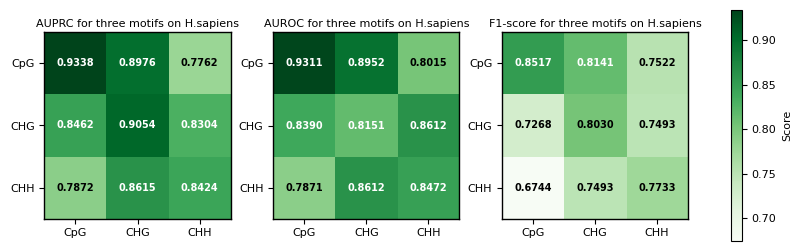

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 1. 手动录入矩阵（H.sapiens 训练）
#    行：train motif = CpG / CHG / CHH
#    列：test motif  = CpG / CHG / CHH
# =========================

motifs = ["CpG", "CHG", "CHH"]

# F1-score
F1 = np.array([
    [0.8517, 0.8141, 0.7522],  # train CpG -> test CpG/CHG/CHH
    [0.7268, 0.8030, 0.7493],  # train CHG -> ...
    [0.6744, 0.7493, 0.7733],  # train CHH -> ...
])

# AUROC
AUROC = np.array([
    [0.9311, 0.8952, 0.8015],
    [0.8390, 0.8151, 0.8612],
    [0.7871, 0.8612, 0.8472],
])

# AUPRC
AUPRC = np.array([
    [0.9338, 0.8976, 0.7762],
    [0.8462, 0.9054, 0.8304],
    [0.7872, 0.8615, 0.8424],
])

metrics = {
    "AUPRC": AUPRC,
    "AUROC": AUROC,
    "F1-score": F1,
}

# 统一颜色范围，便于对比
all_vals = np.concatenate([m.ravel() for m in metrics.values()])
vmin, vmax = all_vals.min(), all_vals.max()
mid = (vmin + vmax) / 2.0

# =========================
# 画 1×3 热图 + 右侧共用 colorbar（缩小字号版）
# =========================
fig = plt.figure(figsize=(9, 3))  # 稍微窄一点也可以
gs = fig.add_gridspec(
    1, 4,
    width_ratios=[1, 1, 1, 0.06],
    wspace=0.3
)

axes = [fig.add_subplot(gs[0, i]) for i in range(3)]
cax   = fig.add_subplot(gs[0, 3])

cmap = plt.get_cmap("Greens")
last_im = None

for ax, (title, mat) in zip(axes, metrics.items()):
    im = ax.imshow(mat, cmap=cmap, vmin=vmin, vmax=vmax, origin="upper")
    last_im = im

    ax.set_xticks(np.arange(len(motifs)))
    ax.set_yticks(np.arange(len(motifs)))
    ax.set_xticklabels(motifs, fontsize=8)
    ax.set_yticklabels(motifs, fontsize=8)

    # 标题字号调小一点
    ax.set_title(
        f"{title} for three motifs on H.sapiens",
        fontsize=8, pad=4
    )

    # 每个格子的数值字号也略微缩小
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            val = mat[i, j]
            ax.text(
                j, i, f"{val:.4f}",
                ha="center", va="center",
                fontsize=7,
                color="white",
                fontweight="bold"
            )

    for spine in ax.spines.values():
        spine.set_edgecolor("black")
        spine.set_linewidth(1.0)

# 共用 colorbar，字号也减一点
cbar = fig.colorbar(last_im, cax=cax)
cbar.set_label("Score", fontsize=8)
cbar.ax.tick_params(labelsize=8)

plt.tight_layout(pad=1.0)
plt.show()


MethyNano - Sheet1 columns: ['Unnamed: 0', 'CpG', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6']
MethyNano - Sheet2 columns: ['CHG', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5']
MethyNano - Sheet3 columns: ['CHH', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5']
NanoCon - Sheet1 columns: ['Unnamed: 0', 'CpG', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6']
NanoCon - Sheet2 columns: ['CHG', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5']
NanoCon - Sheet3 columns: ['CHH', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5']
DeepPlant - Sheet1 columns: ['Unnamed: 0', 'CpG', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6']
DeepPlant - Sheet2 columns: ['CHG', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5']
DeepPlant - Sheet3 columns: ['CHH', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5']
remora - S

KeyError: 'AUROC'

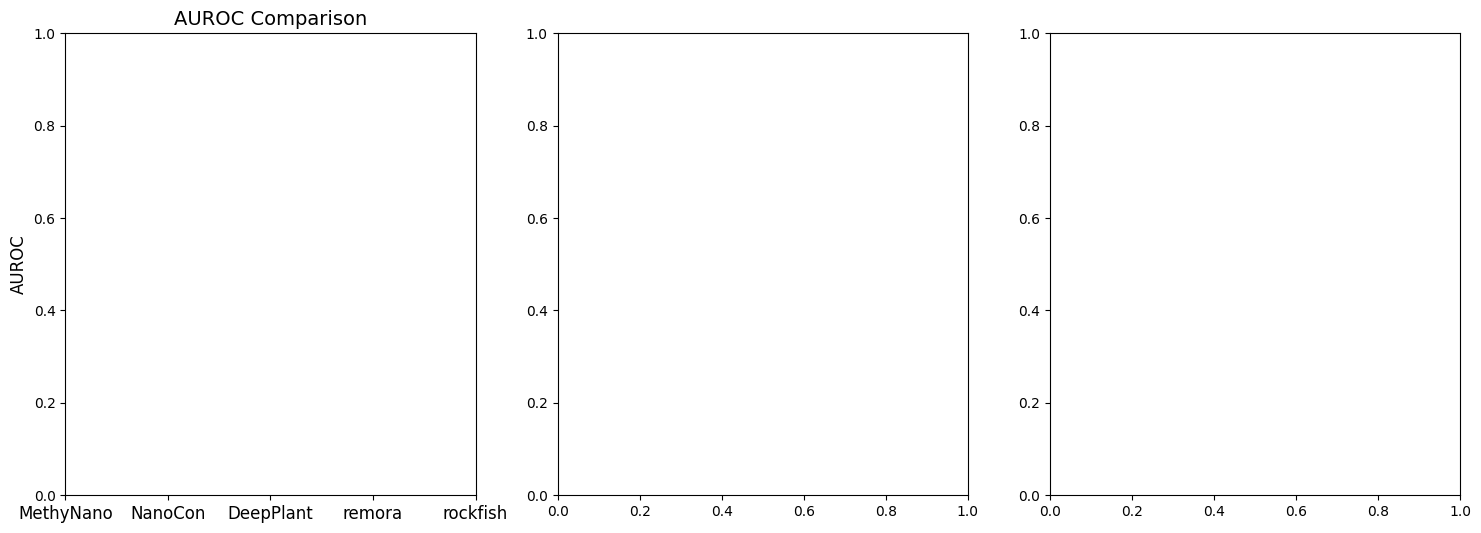

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取每个模型的结果
files = {
    "MethyNano": r"C:\Users\Administrator\Desktop\720_based\MethyNano-v5\result\differentTypes\MethyNano.xlsx",  # 请替换为文件路径
    "NanoCon": r"C:\Users\Administrator\Desktop\720_based\MethyNano-v5\result\differentTypes\NanoCon.xlsx",
    "DeepPlant": r"C:\Users\Administrator\Desktop\720_based\MethyNano-v5\result\differentTypes\DeepPlant.xlsx",
    "remora": r"C:\Users\Administrator\Desktop\720_based\MethyNano-v5\result\differentTypes\remora.xlsx",
    "rockfish": r"C:\Users\Administrator\Desktop\720_based\MethyNano-v5\result\differentTypes\rockfish.xlsx"
}
# 加载数据
models = list(files.keys())
data = {}

for model in models:
    data[model] = {}
    for sheet in ['Sheet1', 'Sheet2', 'Sheet3']:  # Sheet1: CpG, Sheet2: CHG, Sheet3: CHH
        df = pd.read_excel(files[model], sheet_name=sheet)
        data[model][sheet] = df
        print(f"{model} - {sheet} columns: {df.columns.tolist()}")  # 打印列名，检查是否包含 AUROC、AUPRC、F1

# 设置指标
metrics = ['AUROC', 'AUPRC', 'F1']
base_idx = ['CpG', 'CHG', 'CHH']
metric_values = {}

# 获取每个模型在每个基序的指标值
for model in models:
    metric_values[model] = {}
    for metric in metrics:
        for sheet_name, base in zip(['Sheet1', 'Sheet2', 'Sheet3'], base_idx):
            # 获取每个模型在对应基序的指标
            data_sheet = data[model][sheet_name]
            print(f"Checking {metric} in {model} - {sheet_name} columns")
            
            if metric in data_sheet.columns:
                metric_values[model][metric] = {
                    base: data_sheet.loc[data_sheet.index == base, metric].values[0]
                }
            else:
                print(f"Warning: {metric} not found in {model} - {sheet_name} columns.")

# 开始生成绘图
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    ax.set_title(f"{metric} Comparison", fontsize=14)
    ax.set_xticks(np.arange(len(models)))
    ax.set_xticklabels(models, fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    
    # 绘制每个模型在不同基序下的指标
    for i, model in enumerate(models):
        values = [metric_values[model][metric].get(key, np.nan) for key in base_idx]
        ax.plot(base_idx, values, label=model, marker='o')

    ax.legend(loc='best', fontsize=10)

# 自动调整布局
plt.tight_layout()
plt.show()

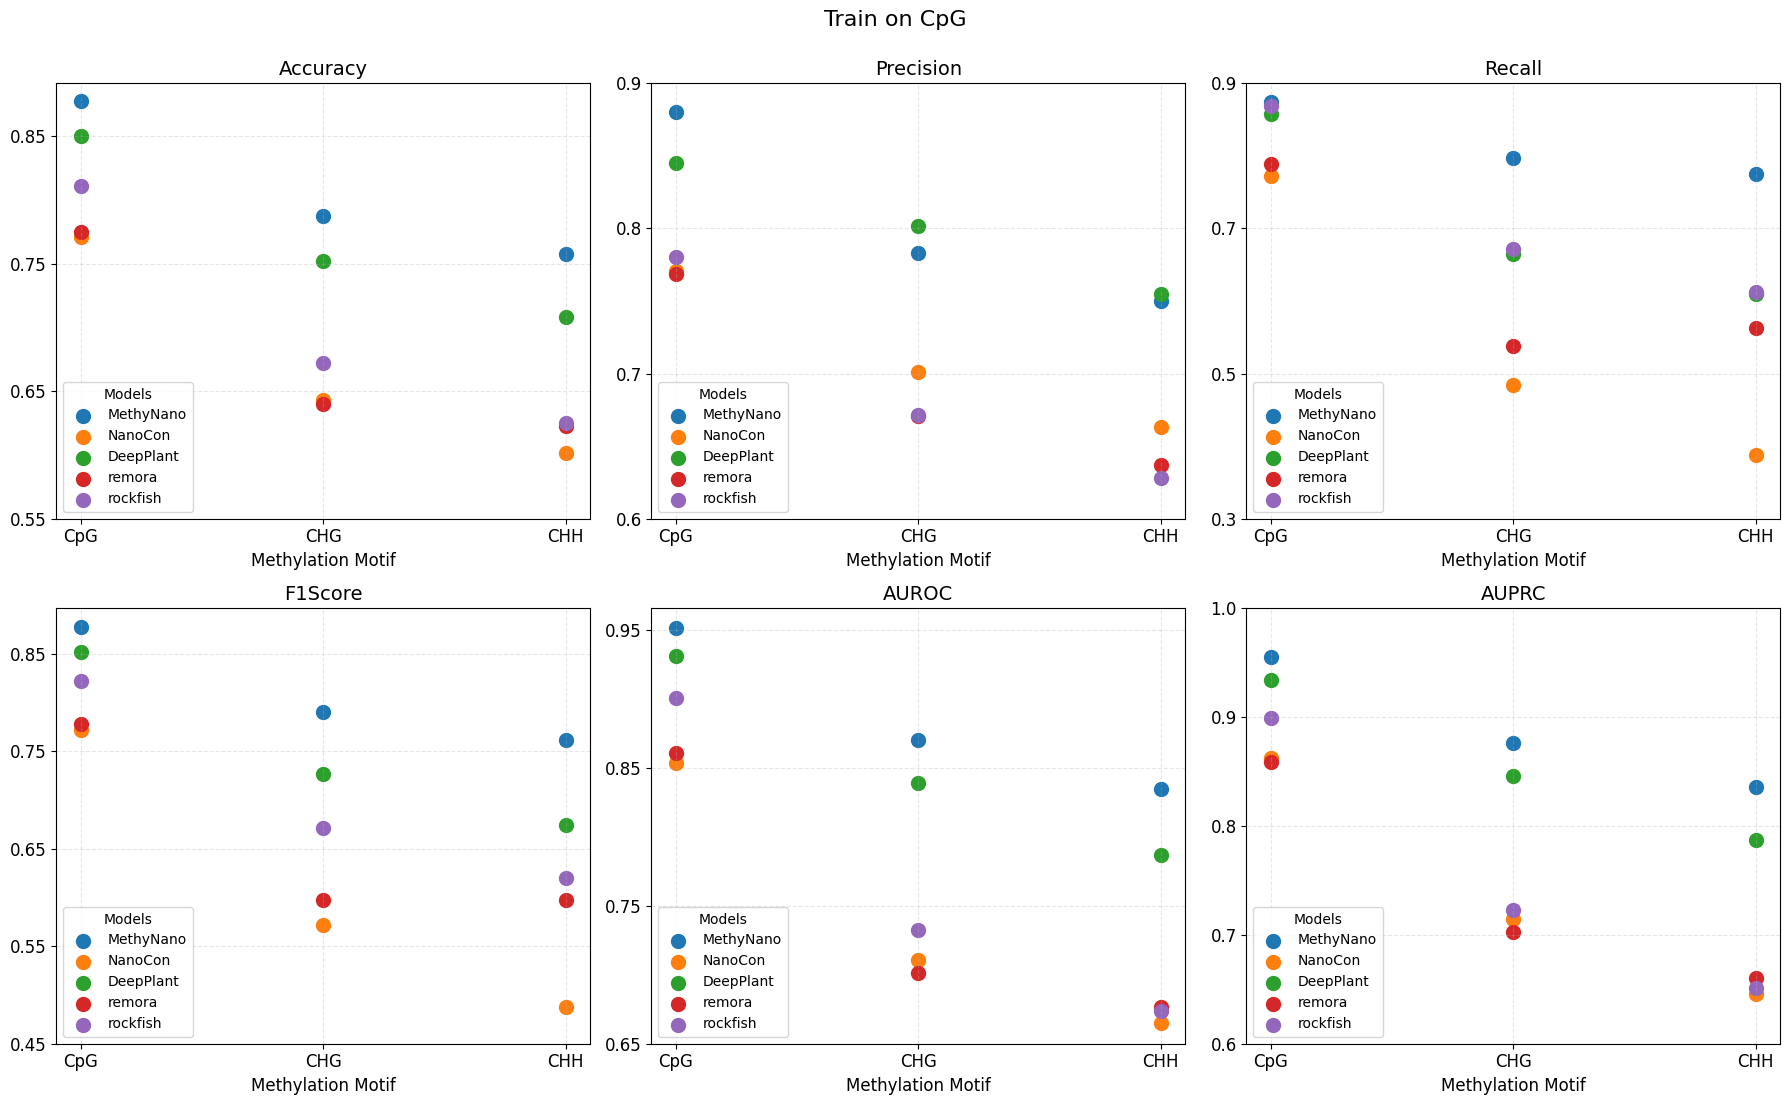

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取上传的Excel文件
files = {
    "MethyNano": r"C:\Users\Administrator\Desktop\720_based\MethyNano-v5\result\differentTypes\MethyNano.xlsx",  # 请替换为文件路径
    "NanoCon": r"C:\Users\Administrator\Desktop\720_based\MethyNano-v5\result\differentTypes\NanoCon.xlsx",
    "DeepPlant": r"C:\Users\Administrator\Desktop\720_based\MethyNano-v5\result\differentTypes\DeepPlant.xlsx",
    "remora": r"C:\Users\Administrator\Desktop\720_based\MethyNano-v5\result\differentTypes\remora.xlsx",
    "rockfish": r"C:\Users\Administrator\Desktop\720_based\MethyNano-v5\result\differentTypes\rockfish.xlsx"
}

# 提取Sheet1的数据
data = {}
for model, file_path in files.items():
    data[model] = pd.read_excel(file_path, sheet_name='Sheet1')

# 清洗数据，提取有效的数值部分
cleaned_data = {}
for model, df in data.items():
    # 选取需要的数据列（去掉无关列）
    df_cleaned = df.iloc[1:, 1:]  # 跳过第一行（标题行），取从第二行开始的内容
    df_cleaned.columns = ["ACC", "PRE", "RECALL", "F1", "AUROC", "AUPRC"]  # 设置列名
    df_cleaned = df_cleaned.reset_index(drop=True)  # 重置索引
    cleaned_data[model] = df_cleaned.astype(float)  # 转换数据为浮动型

# 基序标签
motifs = ["CpG", "CHG", "CHH"]

# 指标名称映射
metric_mapping = {
    "ACC": "Accuracy",
    "PRE": "Precision",
    "RECALL": "Recall",
    "F1": "F1Score",
    "AUROC": "AUROC",
    "AUPRC": "AUPRC"
}

metrics = ["ACC", "PRE", "RECALL", "F1", "AUROC", "AUPRC"]
models = list(cleaned_data.keys())

# 创建2x3的图表布局
fig, axes = plt.subplots(2, 3, figsize=(18, 11))

# 为每个指标绘制对比图
for i, metric in enumerate(metrics):
    ax = axes[i // 3, i % 3]  # 计算位置 (2x3布局)
    for model in models:
        # 绘制实际数据点
        ax.scatter(motifs, cleaned_data[model][metric], label=model, s=100)  # 增加点的大小，便于可视化
    ax.set_title(metric_mapping[metric], fontsize=14)  # 使用映射后的标签
    ax.set_xlabel('Methylation Motif', fontsize=12)  # X轴标签
        
    # 设置X轴分度
    ax.set_xticks(range(len(motifs)))  # 设置X轴刻度为基序数量
    ax.set_xticklabels(motifs)  # 设置X轴刻度标签为基序名称

    # 设置Y轴分度（根据数据范围调整）
    y_ticks = ax.get_yticks()
    ax.set_yticks(y_ticks[::2])  # 示例：每隔一个显示Y轴刻度
    
    ax.legend(title="Models", loc='lower left')  # 添加图例
    ax.tick_params(axis='both', labelsize=12)  # 设置X轴和Y轴刻度标签的字体大小为14
    # 添加半透明的网格线
    ax.grid(True, linestyle='--', alpha=0.3)  # 半透明虚线网格
# 为整个图表添加大标题
fig.suptitle('Train on CpG', fontsize=16, y=1.0)  # 设置标题并调整位置
# 调整图表间距
plt.tight_layout()
#dpi要350

plt.dpi = 350
plt.show()




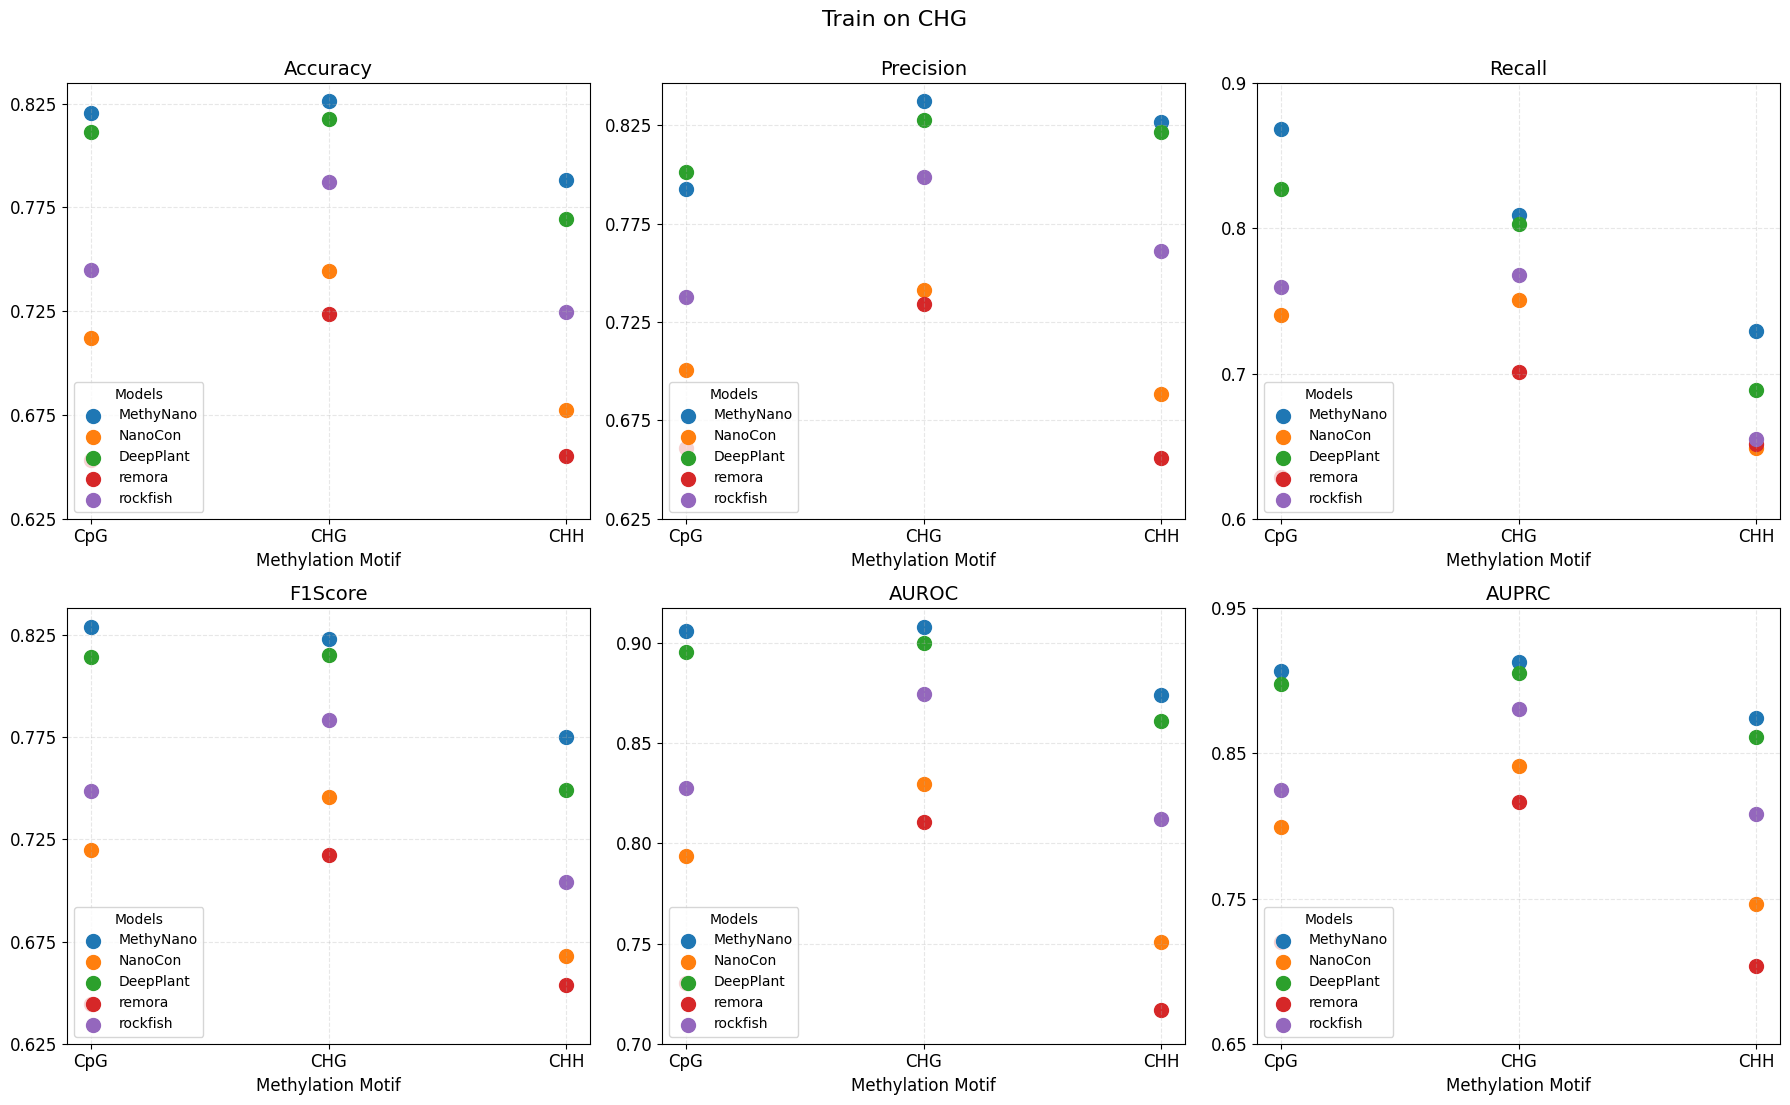

In [2]:

import pandas as pd
import matplotlib.pyplot as plt

# 读取上传的Excel文件
files = {
    "MethyNano": r"C:\Users\Administrator\Desktop\720_based\MethyNano-v5\result\differentTypes\MethyNano.xlsx",
    # 请替换为文件路径
    "NanoCon": r"C:\Users\Administrator\Desktop\720_based\MethyNano-v5\result\differentTypes\NanoCon.xlsx",
    "DeepPlant": r"C:\Users\Administrator\Desktop\720_based\MethyNano-v5\result\differentTypes\DeepPlant.xlsx",
    "remora": r"C:\Users\Administrator\Desktop\720_based\MethyNano-v5\result\differentTypes\remora.xlsx",
    "rockfish": r"C:\Users\Administrator\Desktop\720_based\MethyNano-v5\result\differentTypes\rockfish.xlsx"
}

# 提取Sheet1的数据
data = {}
for model, file_path in files.items():
    data[model] = pd.read_excel(file_path, sheet_name='Sheet2')

# 清洗数据，提取有效的数值部分
cleaned_data = {}
for model, df in data.items():
    # 选取需要的数据列（去掉无关列）
    df_cleaned = df.iloc[1:, 1:]  # 跳过第一行（标题行），取从第二行开始的内容
    df_cleaned.columns = ["ACC", "PRE", "RECALL", "F1", "AUROC", "AUPRC"]  # 设置列名
    df_cleaned = df_cleaned.reset_index(drop=True)  # 重置索引
    cleaned_data[model] = df_cleaned.astype(float)  # 转换数据为浮动型

# 基序标签
motifs = ["CpG", "CHG", "CHH"]

# 指标名称映射
metric_mapping = {
    "ACC": "Accuracy",
    "PRE": "Precision",
    "RECALL": "Recall",
    "F1": "F1Score",
    "AUROC": "AUROC",
    "AUPRC": "AUPRC"
}

metrics = ["ACC", "PRE", "RECALL", "F1", "AUROC", "AUPRC"]
models = list(cleaned_data.keys())

# 创建2x3的图表布局
fig, axes = plt.subplots(2, 3, figsize=(18, 11))

# 为每个指标绘制对比图
for i, metric in enumerate(metrics):
    ax = axes[i // 3, i % 3]  # 计算位置 (2x3布局)
    for model in models:
        # 绘制实际数据点
        ax.scatter(motifs, cleaned_data[model][metric], label=model, s=100)  # 增加点的大小，便于可视化
    ax.set_title(metric_mapping[metric], fontsize=14)  # 使用映射后的标签
    ax.set_xlabel('Methylation Motif', fontsize=12)  # X轴标签

    # 设置X轴分度
    ax.set_xticks(range(len(motifs)))  # 设置X轴刻度为基序数量
    ax.set_xticklabels(motifs)  # 设置X轴刻度标签为基序名称

    # 设置Y轴分度（根据数据范围调整）
    y_ticks = ax.get_yticks()
    ax.set_yticks(y_ticks[::2])  # 示例：每隔一个显示Y轴刻度

    ax.legend(title="Models", loc='lower left')  # 添加图例
    ax.tick_params(axis='both', labelsize=12)  # 设置X轴和Y轴刻度标签的字体大小为14
    # 添加半透明的网格线
    ax.grid(True, linestyle='--', alpha=0.3)  # 半透明虚线网格
# 为整个图表添加大标题
fig.suptitle('Train on CHG', fontsize=16, y=1.0)  # 设置标题并调整位置
# 调整图表间距
plt.tight_layout()
plt.dpi = 350
plt.show()


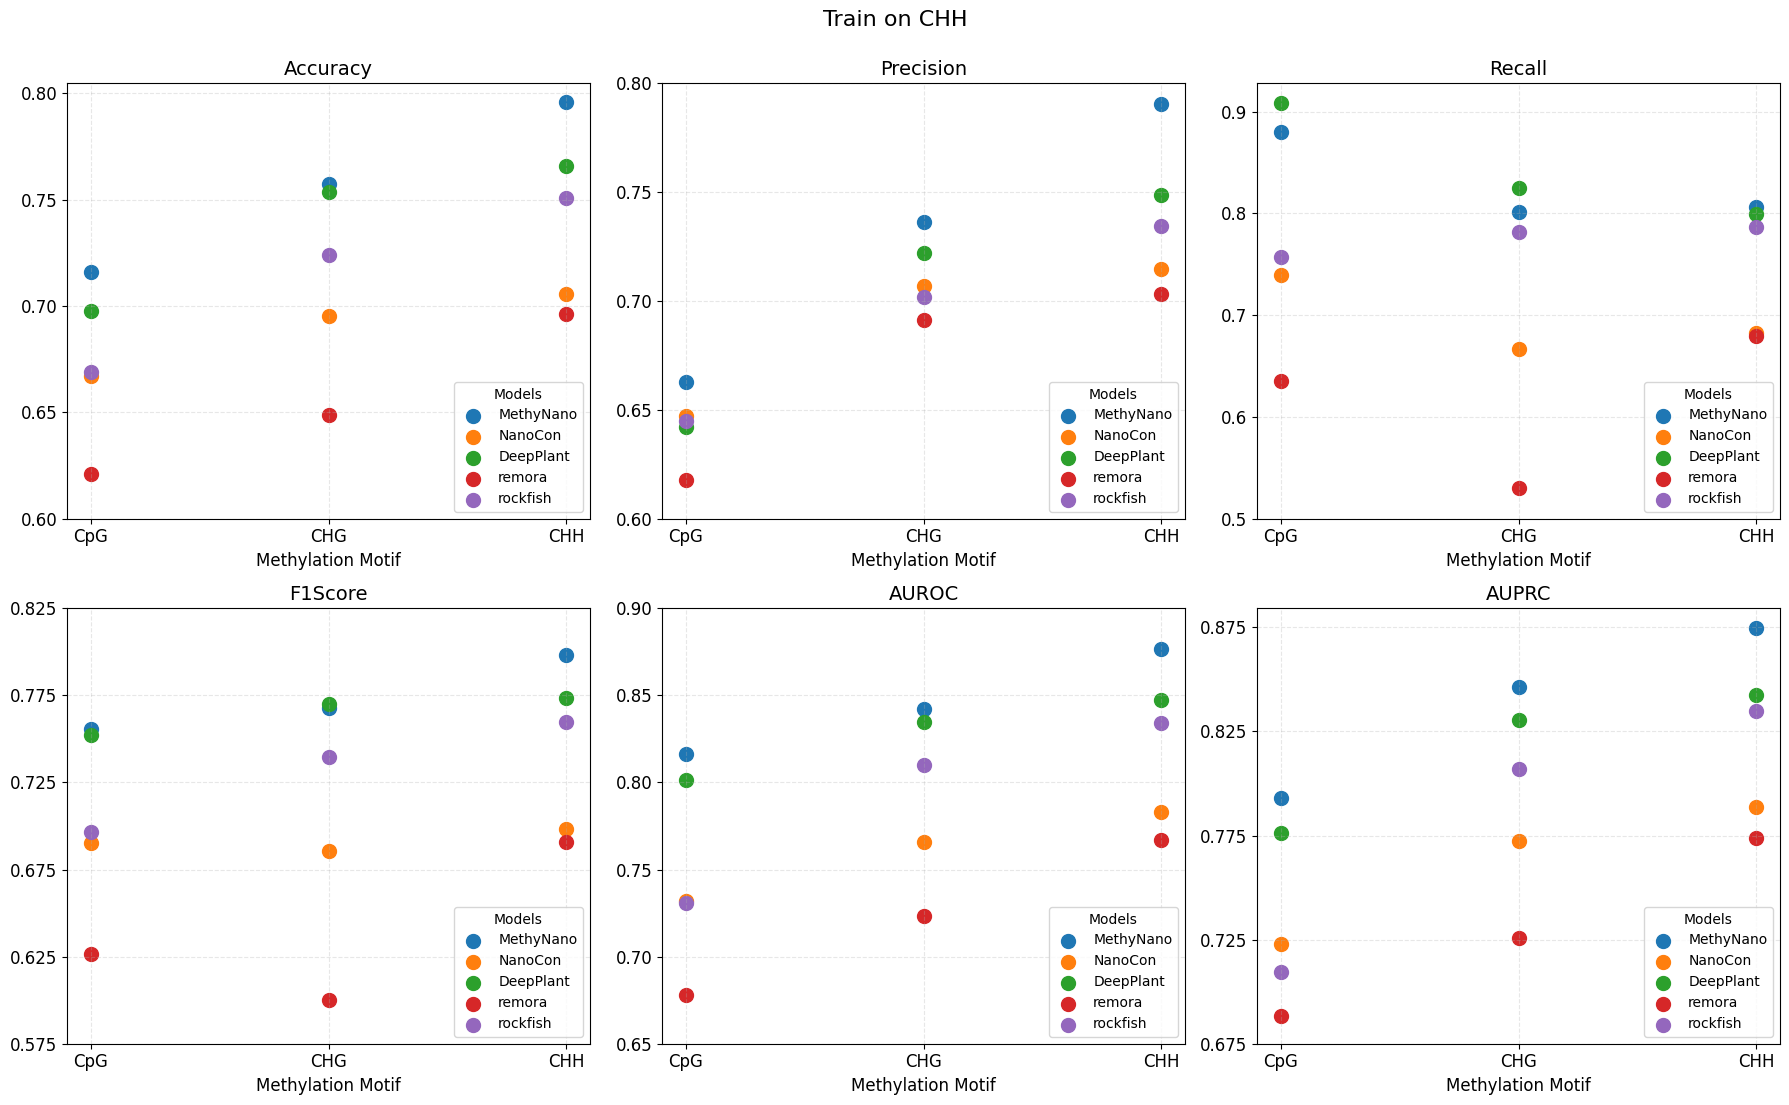

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取上传的Excel文件
files = {
    "MethyNano": r"C:\Users\Administrator\Desktop\720_based\MethyNano-v5\result\differentTypes\MethyNano.xlsx",
    # 请替换为文件路径
    "NanoCon": r"C:\Users\Administrator\Desktop\720_based\MethyNano-v5\result\differentTypes\NanoCon.xlsx",
    "DeepPlant": r"C:\Users\Administrator\Desktop\720_based\MethyNano-v5\result\differentTypes\DeepPlant.xlsx",
    "remora": r"C:\Users\Administrator\Desktop\720_based\MethyNano-v5\result\differentTypes\remora.xlsx",
    "rockfish": r"C:\Users\Administrator\Desktop\720_based\MethyNano-v5\result\differentTypes\rockfish.xlsx"
}

# 提取Sheet1的数据
data = {}
for model, file_path in files.items():
    data[model] = pd.read_excel(file_path, sheet_name='Sheet3')

# 清洗数据，提取有效的数值部分
cleaned_data = {}
for model, df in data.items():
    # 选取需要的数据列（去掉无关列）
    df_cleaned = df.iloc[1:, 1:]  # 跳过第一行（标题行），取从第二行开始的内容
    df_cleaned.columns = ["ACC", "PRE", "RECALL", "F1", "AUROC", "AUPRC"]  # 设置列名
    df_cleaned = df_cleaned.reset_index(drop=True)  # 重置索引
    cleaned_data[model] = df_cleaned.astype(float)  # 转换数据为浮动型

# 基序标签
motifs = ["CpG", "CHG", "CHH"]

# 指标名称映射
metric_mapping = {
    "ACC": "Accuracy",
    "PRE": "Precision",
    "RECALL": "Recall",
    "F1": "F1Score",
    "AUROC": "AUROC",
    "AUPRC": "AUPRC"
}

metrics = ["ACC", "PRE", "RECALL", "F1", "AUROC", "AUPRC"]
models = list(cleaned_data.keys())

# 创建2x3的图表布局
fig, axes = plt.subplots(2, 3, figsize=(18, 11))

# 为每个指标绘制对比图
for i, metric in enumerate(metrics):
    ax = axes[i // 3, i % 3]  # 计算位置 (2x3布局)
    for model in models:
        # 绘制实际数据点
        ax.scatter(motifs, cleaned_data[model][metric], label=model, s=100)  # 增加点的大小，便于可视化
    ax.set_title(metric_mapping[metric], fontsize=14)  # 使用映射后的标签
    ax.set_xlabel('Methylation Motif', fontsize=12)  # X轴标签

    # 设置X轴分度
    ax.set_xticks(range(len(motifs)))  # 设置X轴刻度为基序数量
    ax.set_xticklabels(motifs)  # 设置X轴刻度标签为基序名称

    # 设置Y轴分度（根据数据范围调整）
    y_ticks = ax.get_yticks()
    ax.set_yticks(y_ticks[::2])  # 示例：每隔一个显示Y轴刻度

    ax.legend(title="Models", loc='lower right')  # 添加图例
    ax.tick_params(axis='both', labelsize=12)  # 设置X轴和Y轴刻度标签的字体大小为14
    # 添加半透明的网格线
    ax.grid(True, linestyle='--', alpha=0.3)  # 半透明虚线网格
# 为整个图表添加大标题
fig.suptitle('Train on CHH', fontsize=16, y=1.0)  # 设置标题并调整位置
# 调整图表间距
plt.tight_layout()
plt.dpi = 350
plt.show()

Top motifs: [('CTGCCTCAGCCTC', 4526), ('AGGTTGCAGTGAG', 3526), ('GCTACTCAGGAGG', 2774), ('GATCACCTGAGGT', 2012), ('TGAACCCGGGAGG', 1977)]
pos_scale=0.0114, neg_scale=0.0336, raw_pos_max=0.8763, raw_neg_min=-0.4460


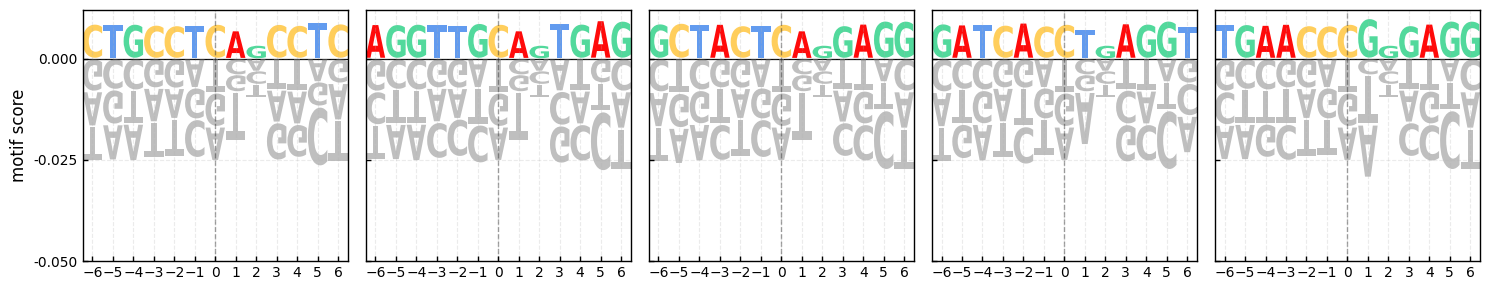

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import logomaker
import numpy as np
import os
import matplotlib.ticker as mticker

# =======================
# 0. 配置
# =======================
file_path = r"D:\my_code\data\CHG_C.csv"

USE_POSITIVE_ONLY = False   # True: 只用 methy_lable==1 来找Top5并作图；False: 全部
TOPK = 5
MOTIF_MODE = "kmer13"      # "kmer13" 或 "center5"

# 目标显示范围（模仿你截图：0线靠上）
TARGET_POS_MAX = 0.010     # 上面彩色最高到 0.01 左右
TARGET_NEG_MIN = -0.015    # 下面灰色最低到 -0.05 左右
YMIN, YMAX = TARGET_NEG_MIN - 0.01, TARGET_POS_MAX + 0.002
YTICKS = [0.000, -0.025, -0.050]
YFMT = "%.3f"

# logomaker 配色
pos_color_scheme = {'A': '#FF0A0A', 'C': '#FFCE5C', 'G': '#52D99C', 'T': '#629BEF'}
neg_color_scheme = {b: (0.75, 0.75, 0.75, 0.55) for b in "ACGT"}  # 灰+半透明

# =======================
# 1. 读数据
# =======================
if not os.path.exists(file_path):
    raise FileNotFoundError(f"未找到文件: {file_path}")

df_all = pd.read_csv(file_path, usecols=["k_mer", "methy_lable"])
df_all["k_mer"] = df_all["k_mer"].astype(str)

# 只保留标准13-mer（A/C/G/T）
df_all = df_all[df_all["k_mer"].str.fullmatch(r"[ACGT]{13}", na=False)].copy()
# 推荐：确保中心位点是 C（index=6 对应位置0）
df_all = df_all[df_all["k_mer"].str[6] == "C"].copy()

if len(df_all) == 0:
    raise ValueError("数据里没有合法的 13-mer (ACGT) 或中心不是C。")

# 作图用的数据（可选只取阳性）
df_use = df_all.copy()
if USE_POSITIVE_ONLY:
    df_use = df_use[df_use["methy_lable"] == 1].copy()

if len(df_use) == 0:
    raise ValueError("过滤后没有可用序列（可能正样本为空）。")

# =======================
# 2. motif 分组 + Top5
# =======================
if MOTIF_MODE == "kmer13":
    df_use["motif"] = df_use["k_mer"]
elif MOTIF_MODE == "center5":
    df_use["motif"] = df_use["k_mer"].str.slice(4, 9)  # 中心5-mer（-2..+2）
else:
    raise ValueError("MOTIF_MODE 只能是 'kmer13' 或 'center5'")

top = df_use["motif"].value_counts().head(TOPK)
top_motifs = top.index.tolist()
top_counts = top.values.tolist()
print("Top motifs:", list(zip(top_motifs, top_counts)))

# =======================
# 3. 计算 PFM（13位置：-6..6）
# =======================
def calculate_pfm(sequences):
    seq_matrix = np.array([list(s) for s in sequences])
    pfm = pd.DataFrame(0.0, index=list(range(-6, 7)), columns=list("ACGT"))
    for i, pos in enumerate(range(-6, 7)):
        counts = pd.Series(seq_matrix[:, i]).value_counts()
        for b in "ACGT":
            pfm.loc[pos, b] = counts.get(b, 0)
    pfm = pfm.div(pfm.sum(axis=1), axis=0).fillna(0)
    return pfm

# 背景建议用全体数据（更稳定）
bg_pfm = calculate_pfm(df_all["k_mer"].tolist())

# ✅ 关键：中心位点背景设为均匀，中心C就不会被抵消成0
bg_pfm.loc[0, :] = 0.25
bg_pfm = bg_pfm.div(bg_pfm.sum(axis=1), axis=0).fillna(0)

# =======================
# 4. 先预计算所有 motif 的 score，用于统一缩放到目标高度
# =======================
scores = {}
global_pos_max = 0.0
global_neg_min = 0.0  # 负数

for motif in top_motifs:
    group_seqs = df_use.loc[df_use["motif"] == motif, "k_mer"].tolist()
    fg_pfm = calculate_pfm(group_seqs)
    score = fg_pfm - bg_pfm
    scores[motif] = score

    pos_max = score.clip(lower=0).to_numpy().max()
    neg_min = score.clip(upper=0).to_numpy().min()  # 最负

    global_pos_max = max(global_pos_max, pos_max)
    global_neg_min = min(global_neg_min, neg_min)

# 分别缩放正/负到目标范围（这一步就是你截图效果的关键）
pos_scale = (TARGET_POS_MAX / global_pos_max) if global_pos_max > 0 else 1.0
neg_scale = (abs(TARGET_NEG_MIN) / abs(global_neg_min)) if global_neg_min < 0 else 1.0

print(f"pos_scale={pos_scale:.4f}, neg_scale={neg_scale:.4f}, "
      f"raw_pos_max={global_pos_max:.4f}, raw_neg_min={global_neg_min:.4f}")

# =======================
# 5. 画 1×5
# =======================
fig, axes = plt.subplots(1, TOPK, figsize=(15, 3), sharey=True)

for j, (motif, cnt) in enumerate(zip(top_motifs, top_counts)):
    ax = axes[j]
    score = scores[motif]

    score_pos = score.clip(lower=0) * pos_scale
    score_neg = score.clip(upper=0) * neg_scale

    # 先画阴影，再画彩色
    logomaker.Logo(score_neg, ax=ax, color_scheme=neg_color_scheme, vpad=.05, stack_order="big_on_top")
    logomaker.Logo(score_pos, ax=ax, color_scheme=pos_color_scheme, vpad=.05, stack_order="big_on_top")

    # 0线（分割线）+ 中心虚线
    ax.axhline(0, color="black", linewidth=1.0, alpha=0.6)
    ax.axvline(0, color="black", linestyle="--", linewidth=1.0, alpha=0.35)

    # 轴设置（模仿截图）
 

    ax.set_xticks(range(-6, 7))
    ax.set_ylim(YMIN, YMAX)
    ax.set_yticks(YTICKS)
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter(YFMT))
    ax.tick_params(axis="both", labelsize=10, direction="in", width=1.0)

    ax.grid(True, linestyle="--", alpha=0.25)
    for spine in ax.spines.values():
        spine.set_linewidth(1.0)

    if j == 0:
        ax.set_ylabel("motif score", fontsize=12)


plt.tight_layout()
plt.show()



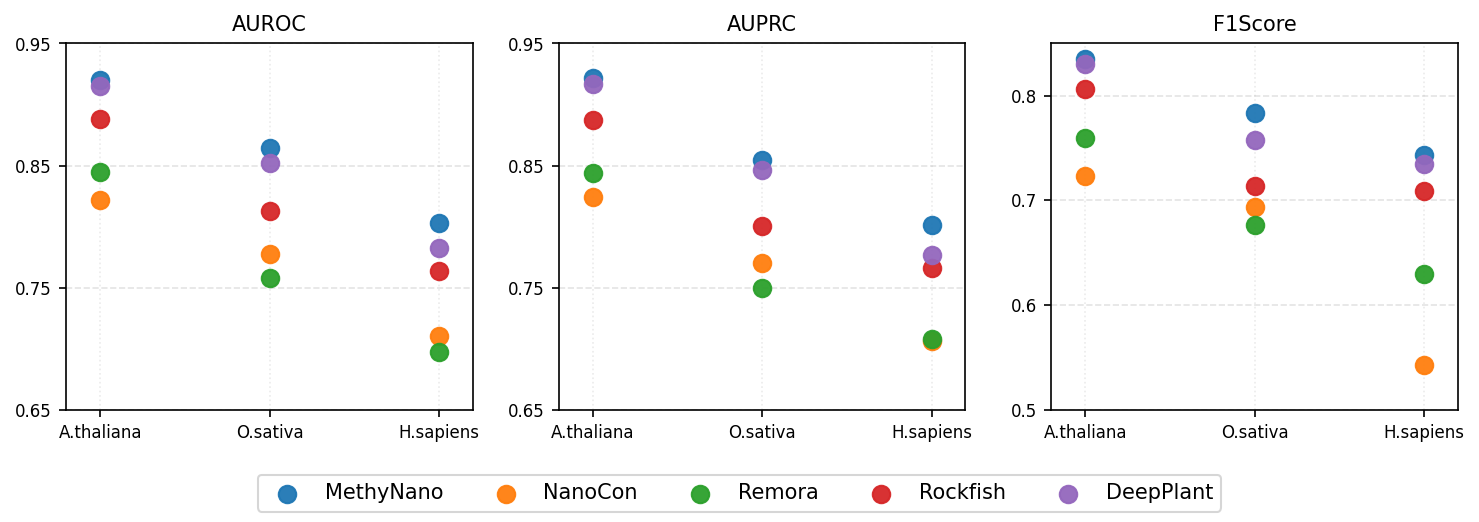

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =======================
# 1) 你的表格数据（直接写死）
# =======================
rows = [
    # A.thaliana
    {"Dataset":"A.thaliana","Metric":"accuracy","MethyNano":0.836325,"NanoCon":0.732199,"Remora":0.7607,"Rockfish":0.80235,"DeepPlant":0.8309},
    {"Dataset":"A.thaliana","Metric":"precision","MethyNano":0.838385369,"NanoCon":0.744467,"Remora":0.7605,"Rockfish":0.788229,"DeepPlant":0.831647},
    {"Dataset":"A.thaliana","Metric":"recall","MethyNano":0.832121546,"NanoCon":0.70369,"Remora":0.759,"Rockfish":0.825302,"DeepPlant":0.828561},
    {"Dataset":"A.thaliana","Metric":"f1score","MethyNano":0.835241714,"NanoCon":0.723095,"Remora":0.7598,"Rockfish":0.806339,"DeepPlant":0.830101},
    {"Dataset":"A.thaliana","Metric":"AUROC","MethyNano":0.920211492,"NanoCon":0.821754,"Remora":0.8444,"Rockfish":0.888343,"DeepPlant":0.914896},
    {"Dataset":"A.thaliana","Metric":"AUPRC","MethyNano":0.921528327,"NanoCon":0.824298,"Remora":0.8437,"Rockfish":0.887319,"DeepPlant":0.916543},

    # O.sativa
    {"Dataset":"O.sativa","Metric":"accuracy","MethyNano":0.7863,"NanoCon":0.6952,"Remora":0.6827,"Rockfish":0.7234,"DeepPlant":0.7717},
    {"Dataset":"O.sativa","Metric":"precision","MethyNano":0.7843,"NanoCon":0.6973,"Remora":0.6812,"Rockfish":0.7346,"DeepPlant":0.7621},
    {"Dataset":"O.sativa","Metric":"recall","MethyNano":0.7807,"NanoCon":0.69,"Remora":0.6703,"Rockfish":0.6948,"DeepPlant":0.7443},
    {"Dataset":"O.sativa","Metric":"f1score","MethyNano":0.7835,"NanoCon":0.6936,"Remora":0.6765,"Rockfish":0.7141,"DeepPlant":0.7578},
    {"Dataset":"O.sativa","Metric":"AUROC","MethyNano":0.8643,"NanoCon":0.7772,"Remora":0.7578,"Rockfish":0.8129,"DeepPlant":0.8519},
    {"Dataset":"O.sativa","Metric":"AUPRC","MethyNano":0.8546,"NanoCon":0.7702,"Remora":0.7494,"Rockfish":0.8007,"DeepPlant":0.8466},

    # H.sapiens
    {"Dataset":"H.sapiens","Metric":"accuracy","MethyNano":0.68,"NanoCon":0.6296,"Remora":0.6337,"Rockfish":0.6504,"DeepPlant":0.7016},
    {"Dataset":"H.sapiens","Metric":"precision","MethyNano":0.7169,"NanoCon":0.703,"Remora":0.632,"Rockfish":0.6804,"DeepPlant":0.6617},
    {"Dataset":"H.sapiens","Metric":"recall","MethyNano":0.8194,"NanoCon":0.4417,"Remora":0.6256,"Rockfish":0.78,"DeepPlant":0.825},
    {"Dataset":"H.sapiens","Metric":"f1score","MethyNano":0.7432,"NanoCon":0.5425,"Remora":0.6296,"Rockfish":0.7093,"DeepPlant":0.7344},
    {"Dataset":"H.sapiens","Metric":"AUROC","MethyNano":0.8028,"NanoCon":0.7102,"Remora":0.6974,"Rockfish":0.7633,"DeepPlant":0.7829},
    {"Dataset":"H.sapiens","Metric":"AUPRC","MethyNano":0.801,"NanoCon":0.7067,"Remora":0.708,"Rockfish":0.7664,"DeepPlant":0.7764},
]

df = pd.DataFrame(rows)

# 模型顺序（按你表头）
models = ["MethyNano", "NanoCon", "Remora", "Rockfish", "DeepPlant"]

# 横坐标：数据集
datasets = ["A.thaliana", "O.sativa", "H.sapiens"]
x = np.arange(len(datasets))

# 只画这三个指标
metrics_to_plot = [("AUROC", "AUROC"), ("AUPRC", "AUPRC"), ("f1score", "F1Score")]

# 给每个模型一个小偏移，避免重叠
offsets = np.linspace(-0.22, 0.22, len(models))

# =======================
# 2) 画 1×3（点不偏移：同一dataset落同一列；加细线增强可读性）
# =======================
fig, axes = plt.subplots(1, 3, figsize=(10, 3.5), sharex=True)

for ax, (metric_key, metric_title) in zip(axes, metrics_to_plot):
    sub = df[df["Metric"] == metric_key].set_index("Dataset").reindex(datasets)

    # 每个模型一条线 + 点（点不做x偏移，严格在同一列上）
    for m in models:
        yvals = sub[m].values.astype(float)
        ax.scatter(
        x, yvals,
        s=70,          # 点大小
        alpha=0.95,
        label=m
    )

    ax.set_title(metric_title, fontsize=10)

    ax.set_xticks(x)
    ax.set_xticklabels(datasets, fontsize=8)

    # 网格线：y主网格 + x辅网格
    ax.set_axisbelow(True)
    ax.grid(True, axis="y", linestyle="--", alpha=0.35, linewidth=0.8)
    ax.grid(True, axis="x", linestyle=":",  alpha=0.25, linewidth=0.8)

    # 让y刻度别太密
    y_ticks = ax.get_yticks()
    if len(y_ticks) > 6:
        ax.set_yticks(y_ticks[::2])
    ax.tick_params(axis="y", labelsize=8)

    # 轻微收紧左右边界
    ax.set_xlim(-0.2, len(datasets) - 1 + 0.2)

# 只放一个公共 legend（底部）
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=5, frameon=True)

plt.tight_layout(rect=[0, 0.10, 1, 1])
plt.show()


[A.thaliana] AUROC=0.9208, AUPRC=0.9239
[H.sapiens] AUROC=0.8028, AUPRC=0.8010
[O.sativa] AUROC=0.8669, AUPRC=0.8577


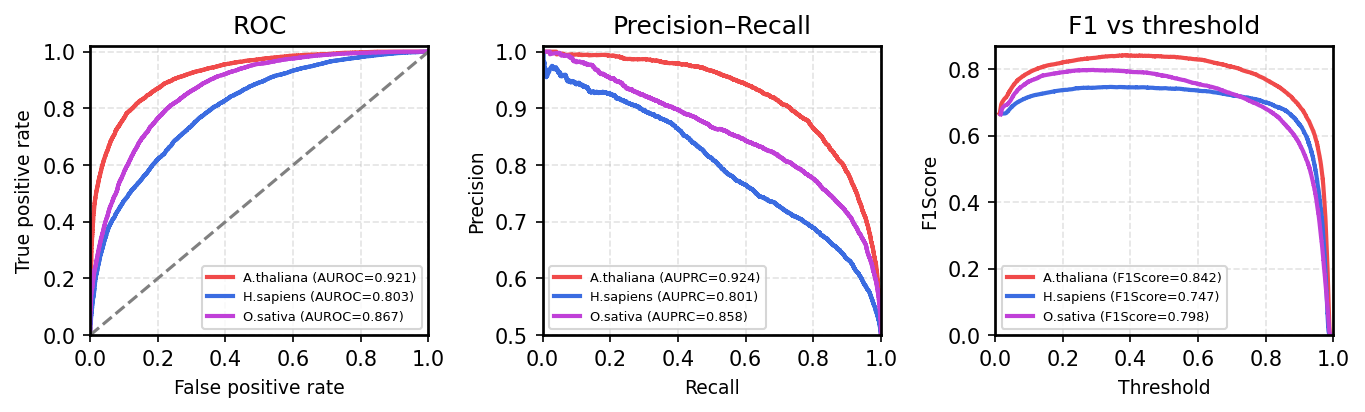

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib as mpl

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['figure.dpi'] = 150

# =======================
# 1) 文件路径
# =======================
files = {
    'A.thaliana': r'C:\Users\Administrator\Desktop\720_based\MethyNano-v5\result\cross-species\test_predictions_methynano_ninanjie.csv',
    'H.sapiens':  r'C:\Users\Administrator\Desktop\720_based\MethyNano-v5\result\cross-species\test_predictions_methynano_people.csv',
    'O.sativa':   r'C:\Users\Administrator\Desktop\720_based\MethyNano-v5\result\cross-species\test_predictions_methynano_rice.csv'
}

# 颜色（高饱和论文风）
colors = {
    'A.thaliana': '#F04A4A',  # 红
    'H.sapiens':  '#3B6CE1',  # 蓝
    'O.sativa':   '#C040D8',  # 紫
}

# =======================
# 2) 画布：1×3
# =======================
fig, (ax_roc, ax_pr, ax_f1) = plt.subplots(1, 3, figsize=(9.2, 3.0))

# ✅ 大标题：MethyNano
# fig.suptitle("MethyNano", fontsize=12,  y=0.90)

# =======================
# 3) 循环画 ROC / PR / F1(threshold curve)
# =======================
for name, filepath in files.items():
    color = colors.get(name, None)

    try:
        df = pd.read_csv(filepath)

        # 自动适配两种列名
        if 'label_true' in df.columns and 'prob_pos' in df.columns:
            y_true = df['label_true'].to_numpy().astype(int)
            y_scores = df['prob_pos'].to_numpy().astype(float)
        else:
            y_true = df.iloc[:, 1].to_numpy().astype(int)
            y_scores = df.iloc[:, 3].to_numpy().astype(float)

        # ===== ROC =====
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, color=color, lw=2,
                    label=f'{name} (AUROC={roc_auc:.3f})')

        # ===== PR / AUPRC =====
        precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
        auprc = average_precision_score(y_true, y_scores)
        ax_pr.plot(recall, precision, color=color, lw=2,
                   label=f'{name} (AUPRC={auprc:.3f})')

        # ===== F1 vs threshold =====
        if thresholds is not None and len(thresholds) > 0:
            p = precision[:-1]
            r = recall[:-1]
            f1 = 2 * p * r / (p + r + 1e-12)

            best_idx = int(np.nanargmax(f1))
            best_thr = float(thresholds[best_idx])
            best_f1 = float(f1[best_idx])

            # ✅ 修正：补上右括号
            ax_f1.plot(thresholds, f1, color=color, lw=2,
                       label=f'{name} (F1Score={best_f1:.3f})')

        print(f"[{name}] AUROC={roc_auc:.4f}, AUPRC={auprc:.4f}")

    except Exception as e:
        print(f"Error processing {name} at {filepath}: {e}")

# =======================
# 4) 子图美化
# =======================

# --- ROC ---
ax_roc.plot([0, 1], [0, 1], color='grey', lw=1.5, linestyle='--')
ax_roc.set_xlim(0.0, 1.0)
ax_roc.set_ylim(0.0, 1.02)
ax_roc.set_xlabel('False positive rate', fontsize=9)
ax_roc.set_ylabel('True positive rate', fontsize=9)
ax_roc.set_title('ROC', fontsize=12)
ax_roc.legend(loc="lower right", fontsize=6.2)
ax_roc.grid(True, linestyle='--', alpha=0.35)

# --- PR ---
ax_pr.set_xlim(0.0, 1.0)
ax_pr.set_ylim(0.5, 1.01)
ax_pr.set_xlabel('Recall', fontsize=9)
ax_pr.set_ylabel('Precision', fontsize=9)
ax_pr.set_title('Precision–Recall', fontsize=12)
ax_pr.legend(loc="lower left", fontsize=6.2)
ax_pr.grid(True, linestyle='--', alpha=0.35)

# --- F1 vs threshold ---
ax_f1.set_xlim(0.0, 1.0)
ax_f1.set_ylim(0.0, 0.87)
ax_f1.set_xlabel('Threshold', fontsize=9)
ax_f1.set_ylabel('F1Score', fontsize=9)
ax_f1.set_title('F1 vs threshold', fontsize=12)
ax_f1.legend(loc="best", fontsize=6.2)
ax_f1.grid(True, linestyle='--', alpha=0.35)

# --- 统一黑色边框 ---
for ax in (ax_roc, ax_pr, ax_f1):
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.3)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # ✅ 给 suptitle 留空间
plt.savefig('comparison_curves_auroc_auprc_f1curve.png', dpi=300, bbox_inches='tight')
plt.show()


[A.thaliana] AUROC=0.8243, AUPRC=0.8285
[H.sapiens] AUROC=0.7254, AUPRC=0.7261
[O.sativa] AUROC=0.7102, AUPRC=0.7067


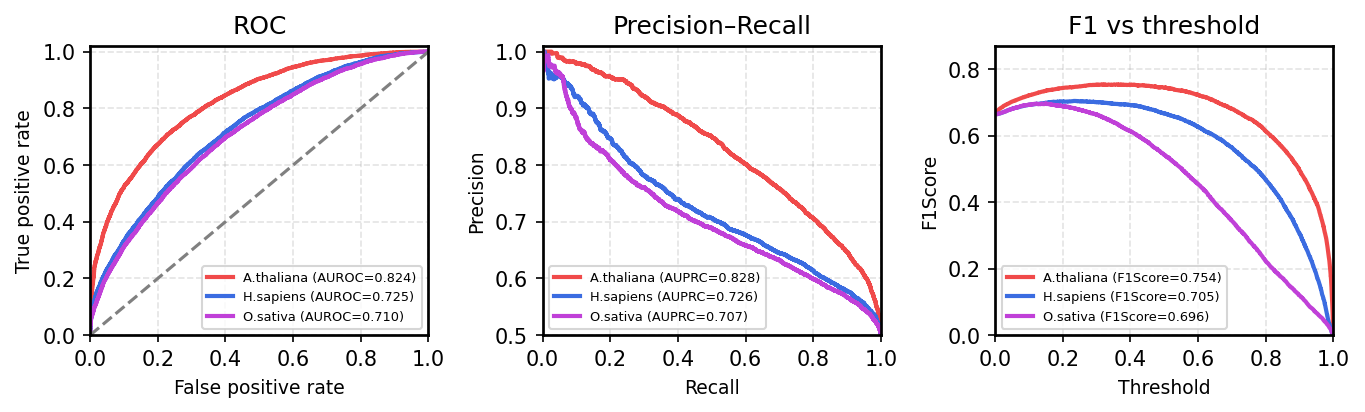

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib as mpl

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['figure.dpi'] = 150

# =======================
# 1) 文件路径
# =======================
files = {
    'A.thaliana': r'C:\Users\Administrator\Desktop\720_based\MethyNano-v5\result\cross-species\test_predictions_NanoCon_ninanjie.csv',
    'H.sapiens':  r'C:\Users\Administrator\Desktop\720_based\MethyNano-v5\result\cross-species\test_predictions_NanoCon_people.csv',
    'O.sativa':   r'C:\Users\Administrator\Desktop\720_based\MethyNano-v5\result\cross-species\test_predictions_NanoCon_rice.csv'
}

# 颜色（高饱和论文风）
colors = {
    'A.thaliana': '#F04A4A',  # 红
    'H.sapiens':  '#3B6CE1',  # 蓝
    'O.sativa':   '#C040D8',  # 紫
}

# =======================
# 2) 画布：1×3
# =======================
fig, (ax_roc, ax_pr, ax_f1) = plt.subplots(1, 3, figsize=(9.2, 3.0))

# ✅ 大标题：MethyNano
# fig.suptitle("MethyNano", fontsize=12,  y=0.90)

# =======================
# 3) 循环画 ROC / PR / F1(threshold curve)
# =======================
for name, filepath in files.items():
    color = colors.get(name, None)

    try:
        df = pd.read_csv(filepath)

        # 自动适配两种列名
        if 'label_true' in df.columns and 'prob_pos' in df.columns:
            y_true = df['label_true'].to_numpy().astype(int)
            y_scores = df['prob_pos'].to_numpy().astype(float)
        else:
            y_true = df.iloc[:, 1].to_numpy().astype(int)
            y_scores = df.iloc[:, 3].to_numpy().astype(float)

        # ===== ROC =====
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, color=color, lw=2,
                    label=f'{name} (AUROC={roc_auc:.3f})')

        # ===== PR / AUPRC =====
        precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
        auprc = average_precision_score(y_true, y_scores)
        ax_pr.plot(recall, precision, color=color, lw=2,
                   label=f'{name} (AUPRC={auprc:.3f})')

        # ===== F1 vs threshold =====
        if thresholds is not None and len(thresholds) > 0:
            p = precision[:-1]
            r = recall[:-1]
            f1 = 2 * p * r / (p + r + 1e-12)

            best_idx = int(np.nanargmax(f1))
            best_thr = float(thresholds[best_idx])
            best_f1 = float(f1[best_idx])

            # ✅ 修正：补上右括号
            ax_f1.plot(thresholds, f1, color=color, lw=2,
                       label=f'{name} (F1Score={best_f1:.3f})')

        print(f"[{name}] AUROC={roc_auc:.4f}, AUPRC={auprc:.4f}")

    except Exception as e:
        print(f"Error processing {name} at {filepath}: {e}")

# =======================
# 4) 子图美化
# =======================

# --- ROC ---
ax_roc.plot([0, 1], [0, 1], color='grey', lw=1.5, linestyle='--')
ax_roc.set_xlim(0.0, 1.0)
ax_roc.set_ylim(0.0, 1.02)
ax_roc.set_xlabel('False positive rate', fontsize=9)
ax_roc.set_ylabel('True positive rate', fontsize=9)
ax_roc.set_title('ROC', fontsize=12)
ax_roc.legend(loc="lower right", fontsize=6.2)
ax_roc.grid(True, linestyle='--', alpha=0.35)

# --- PR ---
ax_pr.set_xlim(0.0, 1.0)
ax_pr.set_ylim(0.5, 1.01)
ax_pr.set_xlabel('Recall', fontsize=9)
ax_pr.set_ylabel('Precision', fontsize=9)
ax_pr.set_title('Precision–Recall', fontsize=12)
ax_pr.legend(loc="lower left", fontsize=6.2)
ax_pr.grid(True, linestyle='--', alpha=0.35)

# --- F1 vs threshold ---
ax_f1.set_xlim(0.0, 1.0)
ax_f1.set_ylim(0.0, 0.87)
ax_f1.set_xlabel('Threshold', fontsize=9)
ax_f1.set_ylabel('F1Score', fontsize=9)
ax_f1.set_title('F1 vs threshold', fontsize=12)
ax_f1.legend(loc="best", fontsize=6.2)
ax_f1.grid(True, linestyle='--', alpha=0.35)

# --- 统一黑色边框 ---
for ax in (ax_roc, ax_pr, ax_f1):
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.3)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # ✅ 给 suptitle 留空间
plt.savefig('comparison_curves_auroc_auprc_f1curve.png', dpi=300, bbox_inches='tight')
plt.show()


[A.thaliana] AUROC=0.8446, AUPRC=0.8457
[H.sapiens] AUROC=0.6974, AUPRC=0.7080
[O.sativa] AUROC=0.7578, AUPRC=0.7494


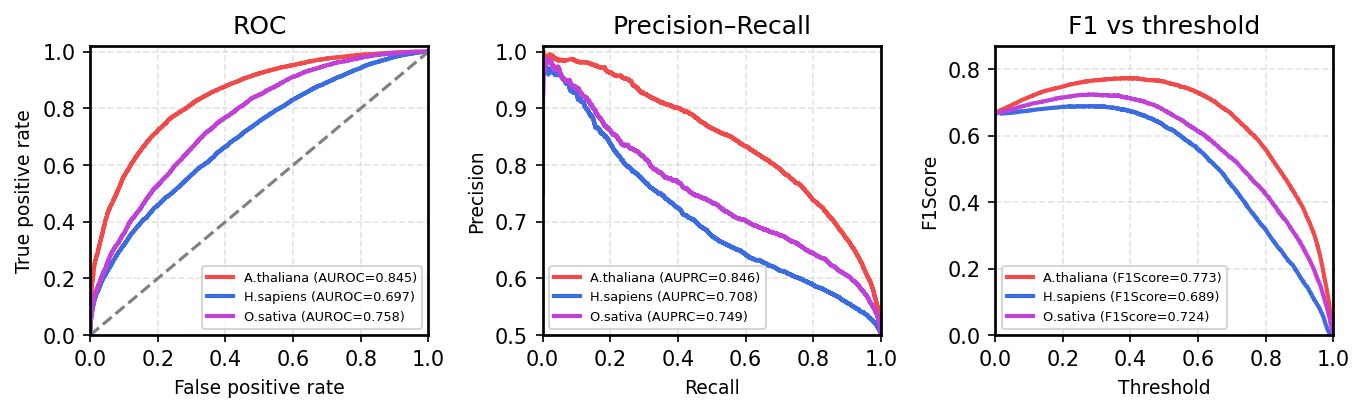

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib as mpl

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['figure.dpi'] = 150

# =======================
# 1) 文件路径
# =======================
files = {
    'A.thaliana': r'C:\Users\Administrator\Desktop\720_based\MethyNano-v5\result\cross-species\test_predictions_remora_ninanjie.csv',
    'H.sapiens':  r'C:\Users\Administrator\Desktop\720_based\MethyNano-v5\result\cross-species\test_predictions_remora_people.csv',
    'O.sativa':   r'C:\Users\Administrator\Desktop\720_based\MethyNano-v5\result\cross-species\test_predictions_remora_rice.csv'
}

# 颜色（高饱和论文风）
colors = {
    'A.thaliana': '#F04A4A',  # 红
    'H.sapiens':  '#3B6CE1',  # 蓝
    'O.sativa':   '#C040D8',  # 紫
}

# =======================
# 2) 画布：1×3
# =======================
fig, (ax_roc, ax_pr, ax_f1) = plt.subplots(1, 3, figsize=(9.2, 3.0))

# ✅ 大标题：MethyNano
# fig.suptitle("MethyNano", fontsize=12,  y=0.90)

# =======================
# 3) 循环画 ROC / PR / F1(threshold curve)
# =======================
for name, filepath in files.items():
    color = colors.get(name, None)

    try:
        df = pd.read_csv(filepath)

        # 自动适配两种列名
        if 'label_true' in df.columns and 'prob_pos' in df.columns:
            y_true = df['label_true'].to_numpy().astype(int)
            y_scores = df['prob_pos'].to_numpy().astype(float)
        else:
            y_true = df.iloc[:, 1].to_numpy().astype(int)
            y_scores = df.iloc[:, 3].to_numpy().astype(float)

        # ===== ROC =====
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, color=color, lw=2,
                    label=f'{name} (AUROC={roc_auc:.3f})')

        # ===== PR / AUPRC =====
        precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
        auprc = average_precision_score(y_true, y_scores)
        ax_pr.plot(recall, precision, color=color, lw=2,
                   label=f'{name} (AUPRC={auprc:.3f})')

        # ===== F1 vs threshold =====
        if thresholds is not None and len(thresholds) > 0:
            p = precision[:-1]
            r = recall[:-1]
            f1 = 2 * p * r / (p + r + 1e-12)

            best_idx = int(np.nanargmax(f1))
            best_thr = float(thresholds[best_idx])
            best_f1 = float(f1[best_idx])

            # ✅ 修正：补上右括号
            ax_f1.plot(thresholds, f1, color=color, lw=2,
                       label=f'{name} (F1Score={best_f1:.3f})')

        print(f"[{name}] AUROC={roc_auc:.4f}, AUPRC={auprc:.4f}")

    except Exception as e:
        print(f"Error processing {name} at {filepath}: {e}")

# =======================
# 4) 子图美化
# =======================

# --- ROC ---
ax_roc.plot([0, 1], [0, 1], color='grey', lw=1.5, linestyle='--')
ax_roc.set_xlim(0.0, 1.0)
ax_roc.set_ylim(0.0, 1.02)
ax_roc.set_xlabel('False positive rate', fontsize=9)
ax_roc.set_ylabel('True positive rate', fontsize=9)
ax_roc.set_title('ROC', fontsize=12)
ax_roc.legend(loc="lower right", fontsize=6.2)
ax_roc.grid(True, linestyle='--', alpha=0.35)

# --- PR ---
ax_pr.set_xlim(0.0, 1.0)
ax_pr.set_ylim(0.5, 1.01)
ax_pr.set_xlabel('Recall', fontsize=9)
ax_pr.set_ylabel('Precision', fontsize=9)
ax_pr.set_title('Precision–Recall', fontsize=12)
ax_pr.legend(loc="lower left", fontsize=6.2)
ax_pr.grid(True, linestyle='--', alpha=0.35)

# --- F1 vs threshold ---
ax_f1.set_xlim(0.0, 1.0)
ax_f1.set_ylim(0.0, 0.87)
ax_f1.set_xlabel('Threshold', fontsize=9)
ax_f1.set_ylabel('F1Score', fontsize=9)
ax_f1.set_title('F1 vs threshold', fontsize=12)
ax_f1.legend(loc="best", fontsize=6.2)
ax_f1.grid(True, linestyle='--', alpha=0.35)

# --- 统一黑色边框 ---
for ax in (ax_roc, ax_pr, ax_f1):
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.3)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # ✅ 给 suptitle 留空间
plt.savefig('comparison_curves_auroc_auprc_f1curve.png', dpi=300, bbox_inches='tight')
plt.show()


[A.thaliana] AUROC=0.8875, AUPRC=0.8867
[H.sapiens] AUROC=0.7633, AUPRC=0.7664
[O.sativa] AUROC=0.8129, AUPRC=0.8007


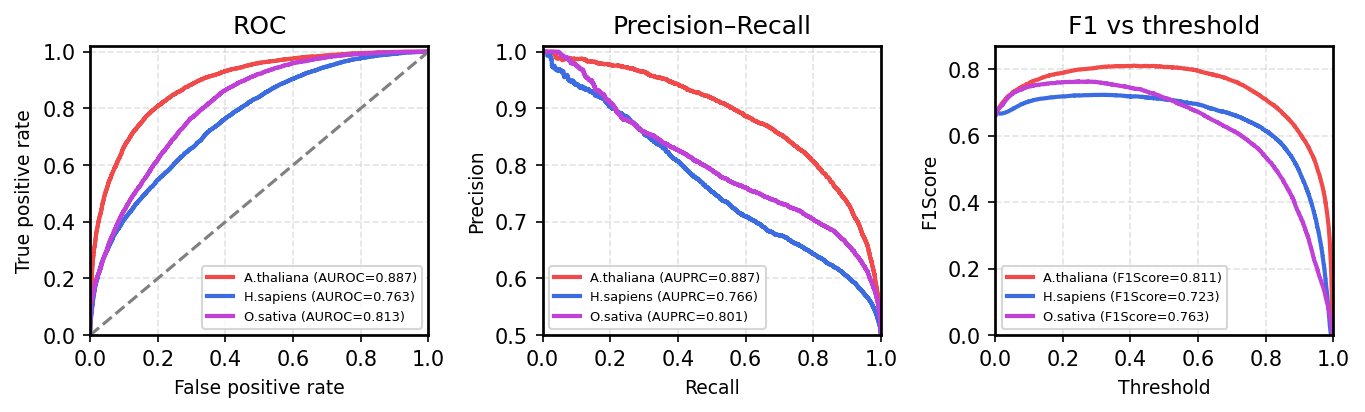

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib as mpl

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['figure.dpi'] = 150


files = {
    'A.thaliana': r'result\cross-species\test_predictions_rockfish_ninanjie.csv',
    'H.sapiens':  r'result\cross-species\test_predictions_rockfish_people.csv',
    'O.sativa':   r'result\cross-species\test_predictions_rockfish_rice.csv'
}

colors = {
    'A.thaliana': '#F04A4A',  
    'H.sapiens':  '#3B6CE1',  
    'O.sativa':   '#C040D8',  
}


fig, (ax_roc, ax_pr, ax_f1) = plt.subplots(1, 3, figsize=(9.2, 3.0))


for name, filepath in files.items():
    color = colors.get(name, None)

    try:
        df = pd.read_csv(filepath)

      
        if 'label_true' in df.columns and 'prob_pos' in df.columns:
            y_true = df['label_true'].to_numpy().astype(int)
            y_scores = df['prob_pos'].to_numpy().astype(float)
        else:
            y_true = df.iloc[:, 1].to_numpy().astype(int)
            y_scores = df.iloc[:, 3].to_numpy().astype(float)

        # ===== ROC =====
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, color=color, lw=2,
                    label=f'{name} (AUROC={roc_auc:.3f})')

        # ===== PR / AUPRC =====
        precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
        auprc = average_precision_score(y_true, y_scores)
        ax_pr.plot(recall, precision, color=color, lw=2,
                   label=f'{name} (AUPRC={auprc:.3f})')

        # ===== F1 vs threshold =====
        if thresholds is not None and len(thresholds) > 0:
            p = precision[:-1]
            r = recall[:-1]
            f1 = 2 * p * r / (p + r + 1e-12)

            best_idx = int(np.nanargmax(f1))
            best_thr = float(thresholds[best_idx])
            best_f1 = float(f1[best_idx])

            ax_f1.plot(thresholds, f1, color=color, lw=2,
                       label=f'{name} (F1Score={best_f1:.3f})')

        print(f"[{name}] AUROC={roc_auc:.4f}, AUPRC={auprc:.4f}")

    except Exception as e:
        print(f"Error processing {name} at {filepath}: {e}")


# --- ROC ---
ax_roc.plot([0, 1], [0, 1], color='grey', lw=1.5, linestyle='--')
ax_roc.set_xlim(0.0, 1.0)
ax_roc.set_ylim(0.0, 1.02)
ax_roc.set_xlabel('False positive rate', fontsize=9)
ax_roc.set_ylabel('True positive rate', fontsize=9)
ax_roc.set_title('ROC', fontsize=12)
ax_roc.legend(loc="lower right", fontsize=6.2)
ax_roc.grid(True, linestyle='--', alpha=0.35)

# --- PR ---
ax_pr.set_xlim(0.0, 1.0)
ax_pr.set_ylim(0.5, 1.01)
ax_pr.set_xlabel('Recall', fontsize=9)
ax_pr.set_ylabel('Precision', fontsize=9)
ax_pr.set_title('Precision–Recall', fontsize=12)
ax_pr.legend(loc="lower left", fontsize=6.2)
ax_pr.grid(True, linestyle='--', alpha=0.35)

# --- F1 vs threshold ---
ax_f1.set_xlim(0.0, 1.0)
ax_f1.set_ylim(0.0, 0.87)
ax_f1.set_xlabel('Threshold', fontsize=9)
ax_f1.set_ylabel('F1Score', fontsize=9)
ax_f1.set_title('F1 vs threshold', fontsize=12)
ax_f1.legend(loc="best", fontsize=6.2)
ax_f1.grid(True, linestyle='--', alpha=0.35)

for ax in (ax_roc, ax_pr, ax_f1):
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.3)

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.savefig('comparison_curves_auroc_auprc_f1curve.png', dpi=300, bbox_inches='tight')
plt.show()


[A.thaliana] AUROC=0.9163, AUPRC=0.9198
[H.sapiens] AUROC=0.7829, AUPRC=0.7764
[O.sativa] AUROC=0.8547, AUPRC=0.8494


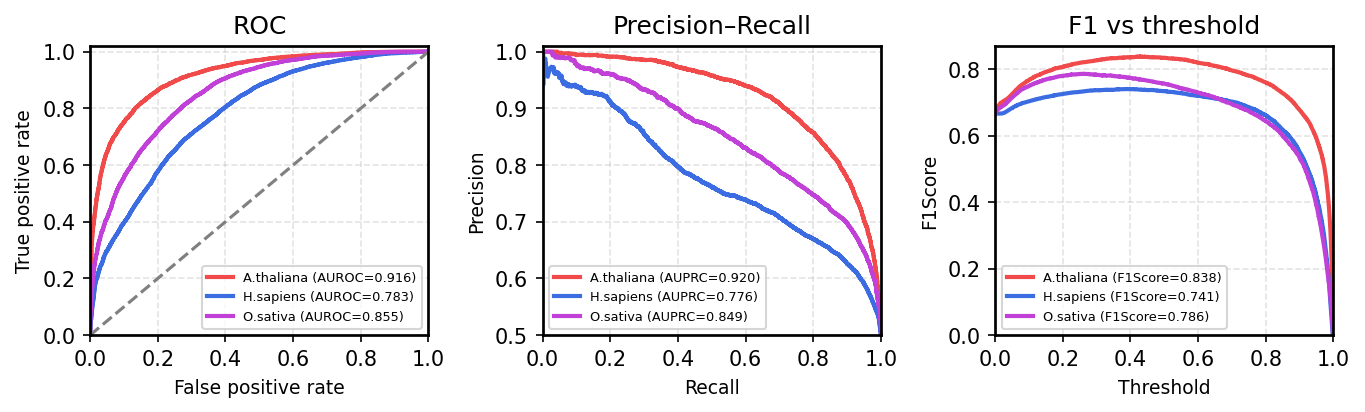

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib as mpl

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['figure.dpi'] = 150


files = {
    'A.thaliana': r'result\cross-species\test_predictions_bilstm_ninanjie.csv',
    'H.sapiens':  r'result\cross-species\test_predictions_bilstm_people.csv',
    'O.sativa':   r'result\cross-species\test_predictions_bilstm_rice.csv'
}

colors = {
    'A.thaliana': '#F04A4A',  
    'H.sapiens':  '#3B6CE1',  
    'O.sativa':   '#C040D8',  
}

fig, (ax_roc, ax_pr, ax_f1) = plt.subplots(1, 3, figsize=(9.2, 3.0))


for name, filepath in files.items():
    color = colors.get(name, None)

    try:
        df = pd.read_csv(filepath)


        if 'label_true' in df.columns and 'prob_pos' in df.columns:
            y_true = df['label_true'].to_numpy().astype(int)
            y_scores = df['prob_pos'].to_numpy().astype(float)
        else:
            y_true = df.iloc[:, 1].to_numpy().astype(int)
            y_scores = df.iloc[:, 3].to_numpy().astype(float)

        # ===== ROC =====
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, color=color, lw=2,
                    label=f'{name} (AUROC={roc_auc:.3f})')

        # ===== PR / AUPRC =====
        precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
        auprc = average_precision_score(y_true, y_scores)
        ax_pr.plot(recall, precision, color=color, lw=2,
                   label=f'{name} (AUPRC={auprc:.3f})')

        # ===== F1 vs threshold =====
        if thresholds is not None and len(thresholds) > 0:
            p = precision[:-1]
            r = recall[:-1]
            f1 = 2 * p * r / (p + r + 1e-12)

            best_idx = int(np.nanargmax(f1))
            best_thr = float(thresholds[best_idx])
            best_f1 = float(f1[best_idx])

    
            ax_f1.plot(thresholds, f1, color=color, lw=2,
                       label=f'{name} (F1Score={best_f1:.3f})')

        print(f"[{name}] AUROC={roc_auc:.4f}, AUPRC={auprc:.4f}")

    except Exception as e:
        print(f"Error processing {name} at {filepath}: {e}")


# --- ROC ---
ax_roc.plot([0, 1], [0, 1], color='grey', lw=1.5, linestyle='--')
ax_roc.set_xlim(0.0, 1.0)
ax_roc.set_ylim(0.0, 1.02)
ax_roc.set_xlabel('False positive rate', fontsize=9)
ax_roc.set_ylabel('True positive rate', fontsize=9)
ax_roc.set_title('ROC', fontsize=12)
ax_roc.legend(loc="lower right", fontsize=6.2)
ax_roc.grid(True, linestyle='--', alpha=0.35)

# --- PR ---
ax_pr.set_xlim(0.0, 1.0)
ax_pr.set_ylim(0.5, 1.01)
ax_pr.set_xlabel('Recall', fontsize=9)
ax_pr.set_ylabel('Precision', fontsize=9)
ax_pr.set_title('Precision–Recall', fontsize=12)
ax_pr.legend(loc="lower left", fontsize=6.2)
ax_pr.grid(True, linestyle='--', alpha=0.35)

# --- F1 vs threshold ---
ax_f1.set_xlim(0.0, 1.0)
ax_f1.set_ylim(0.0, 0.87)
ax_f1.set_xlabel('Threshold', fontsize=9)
ax_f1.set_ylabel('F1Score', fontsize=9)
ax_f1.set_title('F1 vs threshold', fontsize=12)
ax_f1.legend(loc="best", fontsize=6.2)
ax_f1.grid(True, linestyle='--', alpha=0.35)


for ax in (ax_roc, ax_pr, ax_f1):
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.3)

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.savefig('comparison_curves_auroc_auprc_f1curve.png', dpi=300, bbox_inches='tight')
plt.show()


✅ 成功加载 20000 个样本
📊 数据形状: nano=torch.Size([20000, 13, 103]), label=torch.Size([20000])


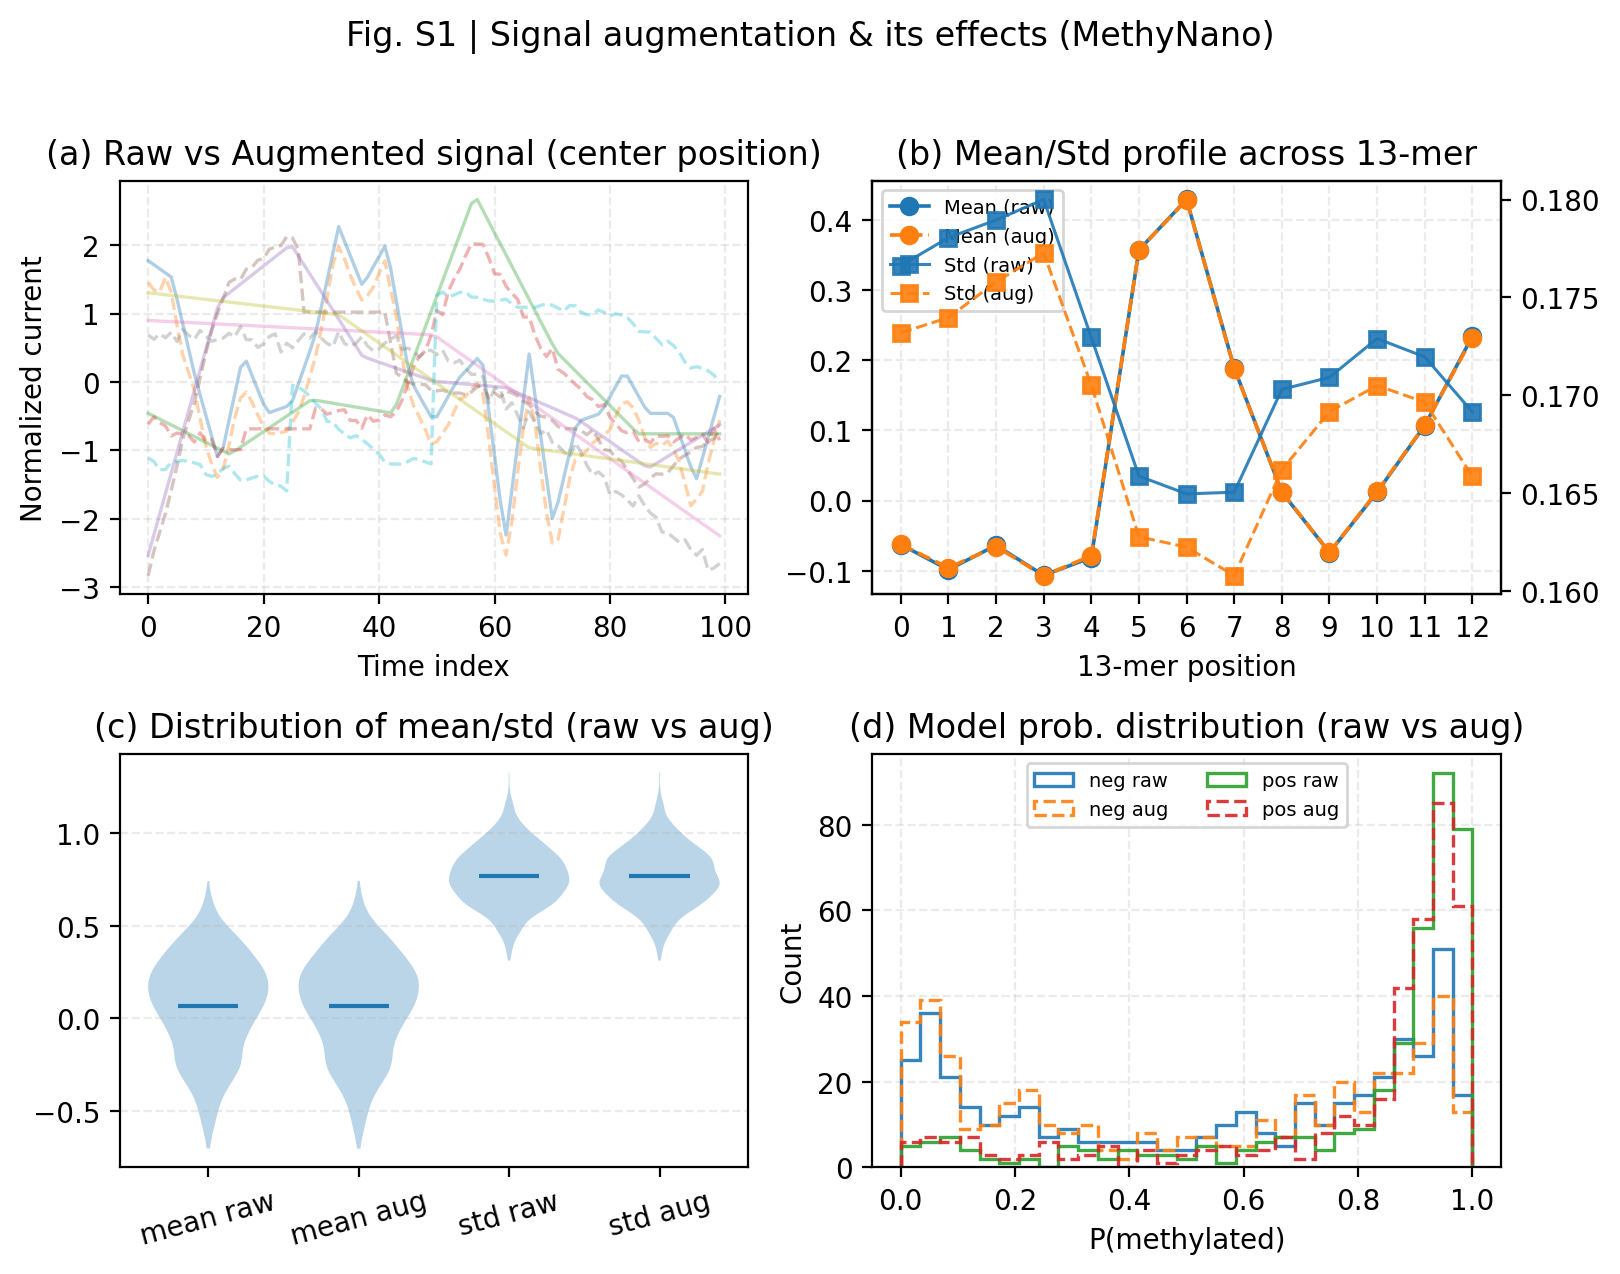

In [136]:
# plot_fig_S1_augment.py
import os, random
import numpy as np
import torch
import matplotlib.pyplot as plt

from scripts.dataLoader import (
    load_dataset, make_data, MyDataSet,
    SignalAugmenter, recompute_stats_from_sig, encode_seq_13mer
)
from moduls import MethyNano


CSV_PATH  = r"data\test_ninanjie.csv"
CKPT_PATH = r"models\ninanjie\cls_best_ep019_f1=0.8352_acc=0.8363_auc=0.9215.pth"  
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

SEED = 13
N_STATS = 800    
N_OVERLAY = 5   
CENTER_POS = 6    

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

seqs, nano, labels = make_data(load_dataset(CSV_PATH, feature_mode="both", mask=-1))
ds = MyDataSet(seqs, nano, labels)

idx_all = np.random.choice(len(ds), size=min(N_STATS, len(ds)), replace=False)
overlay_idx = idx_all[:N_OVERLAY]

strong_aug = SignalAugmenter(level="strong", T=100)


model = MethyNano(
    with_projection=False,    
    with_classification=True,
    dimension=256,
    n_heads=8,
    dropout=0.1,
    base_sig=160
).to(DEVICE)

ckpt = torch.load(CKPT_PATH, map_location="cpu")
state = ckpt.get("model", ckpt)
model.load_state_dict(state, strict=False)
model.eval()

@torch.no_grad()
def prob_pos(sig_13x100, seq_str, stats_13x3):
    seq_ids = torch.tensor(encode_seq_13mer(seq_str), dtype=torch.long).unsqueeze(0).to(DEVICE)   
    sig = sig_13x100.unsqueeze(0).to(DEVICE)   
    sta = stats_13x3.unsqueeze(0).to(DEVICE)  
    out = model(sig, seq_ids, sta)
    p = out["probs"][:, 1].detach().cpu().item()
    return p


mean_prof_raw_list, std_prof_raw_list = [], []
mean_prof_aug_list, std_prof_aug_list = [], []

global_mean_raw, global_std_raw = [], []
global_mean_aug, global_std_aug = [], []

p_raw_pos, p_aug_pos = [], []
p_raw_neg, p_aug_neg = [], []

for k, i in enumerate(idx_all):
    seq_str, n, y = ds[i]     
    n = n.clone().float()

    st_csv = n[:, :3]         
    sg_norm = n[:, 3:]      

    
    sg_aug_norm = strong_aug(sg_norm)
    sg_aug_norm = torch.nan_to_num(sg_aug_norm, nan=0.0, posinf=0.0, neginf=0.0)
    sg_norm = torch.nan_to_num(sg_norm, nan=0.0, posinf=0.0, neginf=0.0)


    mu = st_csv[:, 0:1]      # [13,1]
    sd = st_csv[:, 1:1+1]    # [13,1] 
    sd = torch.clamp(sd, min=1e-6)

    sg_raw = sg_norm * sd + mu
    sg_aug_raw = sg_aug_norm * sd + mu

    mean_raw = sg_raw.mean(dim=-1)                          # [13]
    std_raw  = sg_raw.std(dim=-1, unbiased=False)           # [13]
    mean_aug = sg_aug_raw.mean(dim=-1)
    std_aug  = sg_aug_raw.std(dim=-1, unbiased=False)

    mean_prof_raw_list.append(mean_raw)
    std_prof_raw_list.append(std_raw)
    mean_prof_aug_list.append(mean_aug)
    std_prof_aug_list.append(std_aug)

    global_mean_raw.append(float(sg_raw.mean().item()))
    global_std_raw.append(float(sg_raw.std(unbiased=False).item()))
    global_mean_aug.append(float(sg_aug_raw.mean().item()))
    global_std_aug.append(float(sg_aug_raw.std(unbiased=False).item()))

   
    L = st_csv[:, 2]  # [13]
    sta_raw = recompute_stats_from_sig(sg_norm, L)    
    sta_aug = recompute_stats_from_sig(sg_aug_norm, L)

    pr = prob_pos(sg_norm, seq_str, sta_raw)
    pa = prob_pos(sg_aug_norm, seq_str, sta_aug)

    if int(y.item()) == 1:
        p_raw_pos.append(pr); p_aug_pos.append(pa)
    else:
        p_raw_neg.append(pr); p_aug_neg.append(pa)

mean_prof_raw = torch.stack(mean_prof_raw_list, 0).mean(0).numpy()
std_prof_raw  = torch.stack(std_prof_raw_list,  0).mean(0).numpy()
mean_prof_aug = torch.stack(mean_prof_aug_list, 0).mean(0).numpy()
std_prof_aug  = torch.stack(std_prof_aug_list,  0).mean(0).numpy()

fig, axes = plt.subplots(2, 2, figsize=(8.2, 6.2), dpi=200)
(ax_a, ax_b), (ax_c, ax_d) = axes


for j, i in enumerate(overlay_idx):
    seq_str, n, y = ds[i]
    n = n.clone().float()
    sg_norm = torch.nan_to_num(n[:, 3:], nan=0.0, posinf=0.0, neginf=0.0)
    sg_aug  = torch.nan_to_num(strong_aug(sg_norm), nan=0.0, posinf=0.0, neginf=0.0)

    ax_a.plot(sg_norm[CENTER_POS].numpy(), alpha=0.35, linewidth=1.2)
    ax_a.plot(sg_aug[CENTER_POS].numpy(),  alpha=0.35, linewidth=1.2, linestyle="--")

ax_a.set_title("(a) Raw vs Augmented signal (center position)")
ax_a.set_xlabel("Time index")
ax_a.set_ylabel("Normalized current")
ax_a.grid(True, linestyle="--", alpha=0.25)


xpos = np.arange(13)
ax_b.plot(xpos, mean_prof_raw, marker="o", linewidth=1.3, label="Mean (raw)")
ax_b.plot(xpos, mean_prof_aug, marker="o", linewidth=1.3, linestyle="--", label="Mean (aug)")
ax_b2 = ax_b.twinx()
ax_b2.plot(xpos, std_prof_raw, marker="s", linewidth=1.1, alpha=0.9, label="Std (raw)")
ax_b2.plot(xpos, std_prof_aug, marker="s", linewidth=1.1, alpha=0.9, linestyle="--", label="Std (aug)")

ax_b.set_title("(b) Mean/Std profile across 13-mer")
ax_b.set_xlabel("13-mer position")
ax_b.set_xticks(xpos)
ax_b.grid(True, linestyle="--", alpha=0.25)

h1, l1 = ax_b.get_legend_handles_labels()
h2, l2 = ax_b2.get_legend_handles_labels()
ax_b.legend(h1+h2, l1+l2, fontsize=7, loc="upper left")


data_c = [global_mean_raw, global_mean_aug, global_std_raw, global_std_aug]
labels_c = ["mean raw", "mean aug", "std raw", "std aug"]
vp = ax_c.violinplot(data_c, showmeans=True, showextrema=False, widths=0.8)
ax_c.set_xticks([1,2,3,4])
ax_c.set_xticklabels(labels_c, rotation=15)
ax_c.set_title("(c) Distribution of mean/std (raw vs aug)")
ax_c.grid(True, axis="y", linestyle="--", alpha=0.25)


bins = np.linspace(0, 1, 30)
ax_d.hist(p_raw_neg, bins=bins, histtype="step", linewidth=1.2, label="neg raw", alpha=0.9)
ax_d.hist(p_aug_neg, bins=bins, histtype="step", linewidth=1.2, linestyle="--", label="neg aug", alpha=0.9)
ax_d.hist(p_raw_pos, bins=bins, histtype="step", linewidth=1.2, label="pos raw", alpha=0.9)
ax_d.hist(p_aug_pos, bins=bins, histtype="step", linewidth=1.2, linestyle="--", label="pos aug", alpha=0.9)

ax_d.set_title("(d) Model prob. distribution (raw vs aug)")
ax_d.set_xlabel("P(methylated)")
ax_d.set_ylabel("Count")
ax_d.grid(True, linestyle="--", alpha=0.25)
ax_d.legend(fontsize=7, loc="upper center", ncol=2)

fig.suptitle("Fig. S1 | Signal augmentation & its effects (MethyNano)", y=1.02, fontsize=12)
plt.tight_layout()
plt.savefig("Fig_S1_augment_stats_prob.png", dpi=300, bbox_inches="tight")
plt.show()


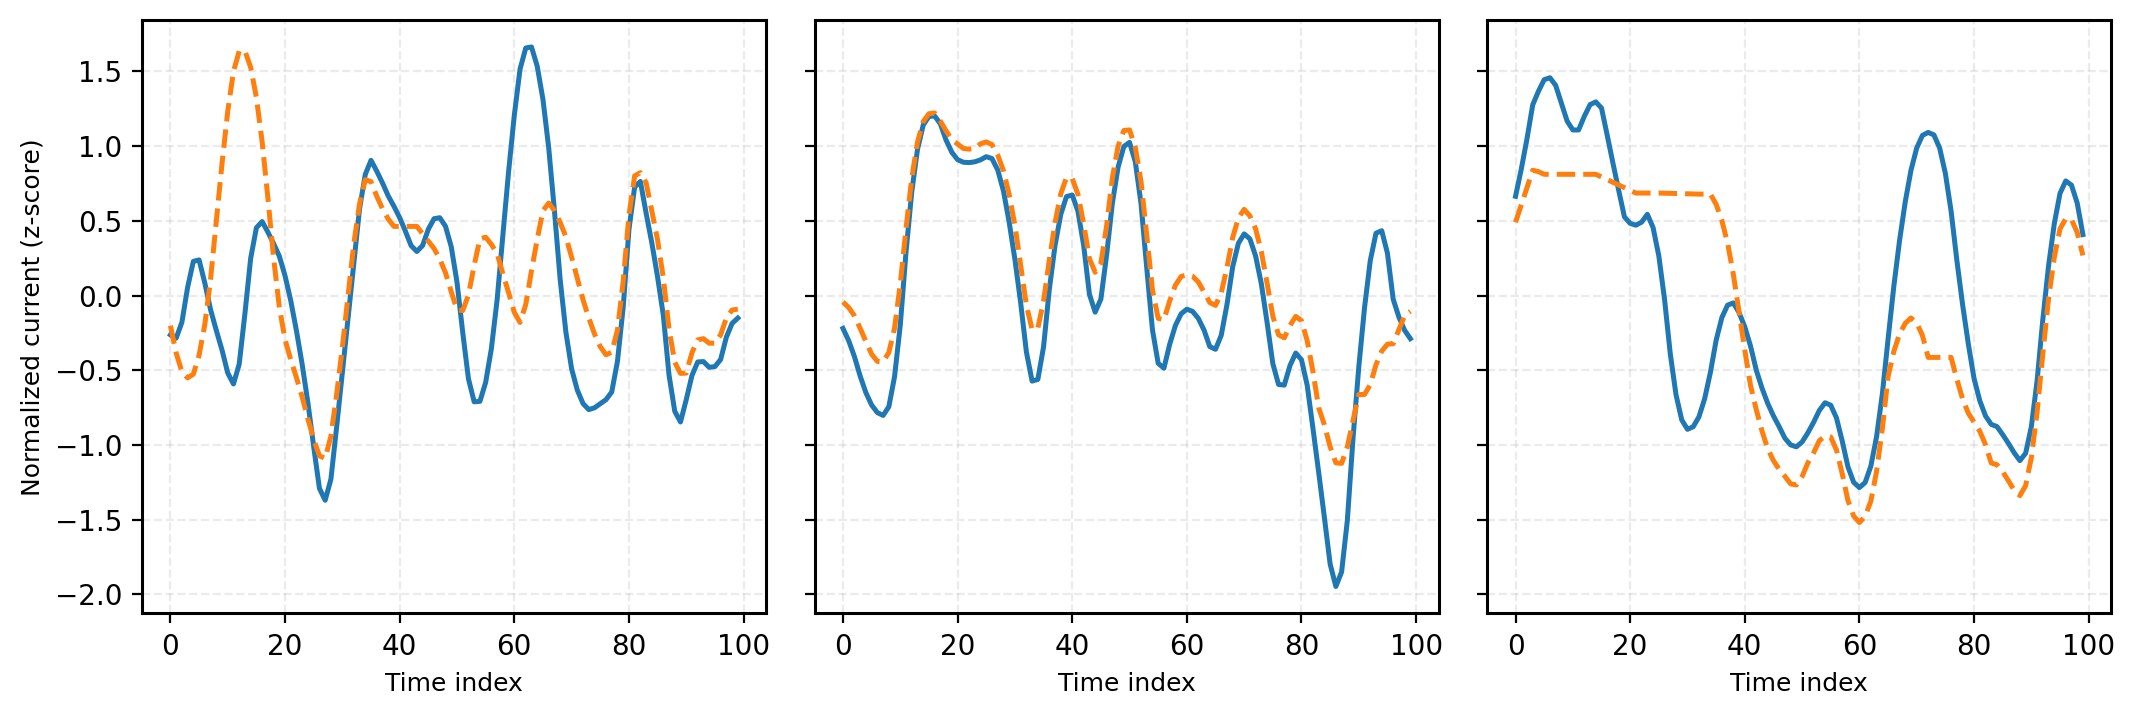

In [157]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import random

from scripts.dataLoader import SignalAugmenter  

CSV_PATH = r"data\test_rice.csv"  
ROW_IDX  = None         
POS      = 6            
T        = 100
AUG_LEVEL = "strong"  
SEED = 42
N_TRY = 200              
SMOOTH_WIN = 7         

def parse_signal_cell(cell, T=100):
    arr = [float(x) for x in str(cell).split(",") if str(x).strip() != ""] if not pd.isna(cell) else []
    if len(arr) < T: arr = arr + [0.0] * (T - len(arr))
    else: arr = arr[:T]
    return np.asarray(arr, dtype=np.float32)

def zscore(x):
    x = np.asarray(x, dtype=np.float32)
    return (x - x.mean()) / (x.std() + 1e-8)

def smooth_ma(x, win=7):
    if win is None or win <= 1:
        return x
    win = int(win)
    if win % 2 == 0:
        win += 1
    k = np.ones(win, dtype=np.float32) / win
    return np.convolve(x, k, mode="same")

def find_signal_columns(df):
    cols = []
    for c in df.columns:
        lc = str(c).lower()
        if lc.startswith("signal") or lc.startswith("current_signal"):
            cols.append(c)
    def _key(c):
        s = str(c)
        digits = "".join(ch for ch in s if ch.isdigit())
        return int(digits) if digits else 10**9
    return sorted(cols, key=_key)

def load_sig13(df, idx, sig_cols, T=100):

    sigs = []
    if len(sig_cols) >= 13:
        for p in range(13):
            sigs.append(parse_signal_cell(df.loc[idx, sig_cols[p]], T=T))
    else:
        for p in range(13):
            sigs.append(parse_signal_cell(df.iloc[idx, 4 + p], T=T))
    sig13 = np.stack(sigs, axis=0)         # [13,T]
    sig13 = np.stack([zscore(sig13[p]) for p in range(13)], axis=0) 
    return sig13

def prettiness_score(x):

    d = np.diff(x)
    sign_changes = np.sum(np.diff(np.sign(d + 1e-12)) != 0)
    tv = np.sum(np.abs(d))
    std = float(np.std(x))
    return 2.0 * sign_changes + 0.5 * tv + 3.0 * std

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

df = pd.read_csv(CSV_PATH)
sig_cols = find_signal_columns(df)


N_PANELS = 3
rows_to_plot = []

if ROW_IDX is not None:
    rows_to_plot = [int(ROW_IDX)]

    cand = []
    for _ in range(N_TRY):
        ridx = random.randrange(len(df))
        if ridx in rows_to_plot:
            continue
        sig13 = load_sig13(df, ridx, sig_cols, T=T)
        cand.append((prettiness_score(sig13[POS]), ridx))
    cand.sort(reverse=True)
    rows_to_plot += [r for _, r in cand[:(N_PANELS - 1)]]
else:
    cand = []
    for _ in range(N_TRY):
        ridx = random.randrange(len(df))
        sig13 = load_sig13(df, ridx, sig_cols, T=T)
        cand.append((prettiness_score(sig13[POS]), ridx))
    cand.sort(reverse=True)

    used = set()
    for _, r in cand:
        if r not in used:
            rows_to_plot.append(r)
            used.add(r)
        if len(rows_to_plot) == N_PANELS:
            break


aug = SignalAugmenter(level=AUG_LEVEL, T=T)

fig, axes = plt.subplots(1, 3, figsize=(10.8, 4), dpi=200, sharey=True)

for ax, ridx in zip(axes, rows_to_plot):
    sig13_raw = load_sig13(df, ridx, sig_cols, T=T)
    sig13_aug = aug(torch.tensor(sig13_raw, dtype=torch.float32)).cpu().numpy()

    raw = sig13_raw[POS]
    aug_sig = sig13_aug[POS]

    raw_plot = smooth_ma(raw, SMOOTH_WIN)
    aug_plot = smooth_ma(aug_sig, SMOOTH_WIN)

    ax.plot(raw_plot, lw=1.8, label="Raw")
    ax.plot(aug_plot, lw=1.8, ls="--", label="Augmentation")


    ax.set_xlabel("Time index", fontsize=9)

    ax.set_axisbelow(True)
    ax.grid(True, linestyle="--", alpha=0.25)

    for sp in ax.spines.values():
        sp.set_edgecolor("black")
        sp.set_linewidth(1.1)

axes[0].set_ylabel("Normalized current (z-score)", fontsize=9)

handles, labels = axes[0].get_legend_handles_labels()


plt.tight_layout(rect=[0, 0.10, 1, 1])
plt.subplots_adjust(wspace=0.25) 
plt.show()

plt.show()


C:\Users\Administrator\AppData\Local\Temp\ipykernel_29608\1988211478.py:175: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


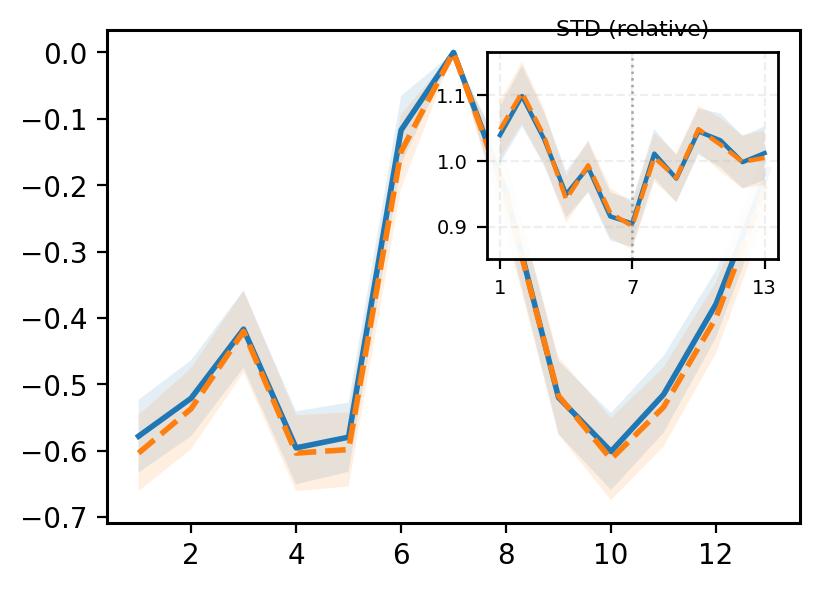

Selected rows: [4723, 8668, 13488]


C:\Users\Administrator\AppData\Local\Temp\ipykernel_29608\3619957880.py:226: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.10, 1, 1])


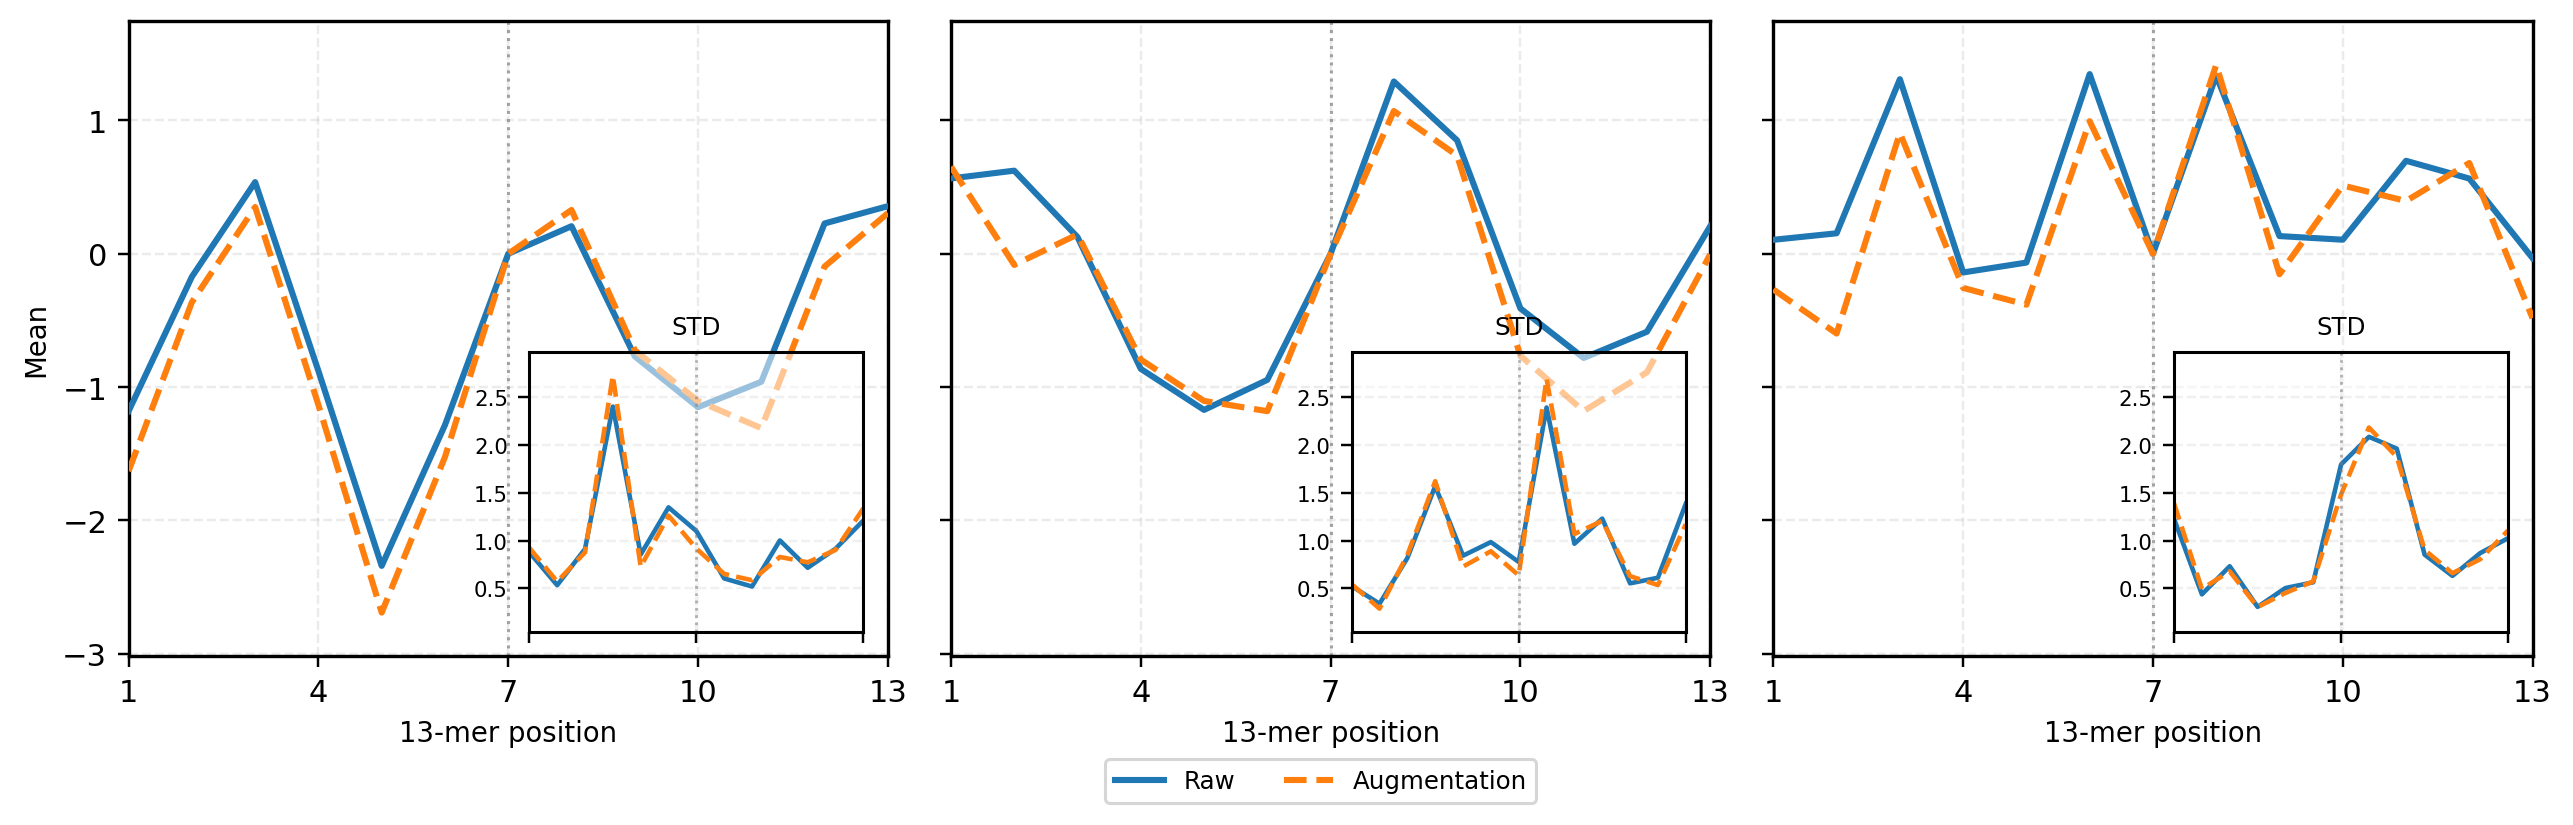

In [202]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import random
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scripts.dataLoader import SignalAugmenter

CSV_PATH   = r"data\test_rice.csv"
T          = 100
AUG_LEVEL  = "strong"
SEED       = 42
LABEL_FILTER = None    

CENTER_POS = 6         
USE_ZSCORE = False    

TOPK       = 3
TOPK_TRY   = 1200      
SMOOTH_WIN = 5      

def parse_signal_cell(cell, T=100):
    arr = [float(x) for x in str(cell).split(",") if str(x).strip() != ""] if not pd.isna(cell) else []
    if len(arr) < T: arr = arr + [0.0] * (T - len(arr))
    else: arr = arr[:T]
    return np.asarray(arr, dtype=np.float32)

def zscore(x):
    x = np.asarray(x, dtype=np.float32)
    return (x - x.mean()) / (x.std() + 1e-8)

def smooth_ma(x, win=5):
    if win is None or win <= 1:
        return x
    win = int(win)
    if win % 2 == 0:
        win += 1
    k = np.ones(win, dtype=np.float32) / win
    return np.convolve(x, k, mode="same")

def find_signal_columns(df):
    cols = []
    for c in df.columns:
        lc = str(c).lower()
        if lc.startswith("signal") or lc.startswith("current_signal"):
            cols.append(c)

    def _key(c):
        s = str(c)
        digits = "".join(ch for ch in s if ch.isdigit())
        return int(digits) if digits else 10**9
    return sorted(cols, key=_key)

def pick_label_series(df):
    for c in df.columns:
        if str(c).lower() in ["label", "labels", "y", "label_true", "target"]:
            return df[c]
    if df.shape[1] > 17:
        return df.iloc[:, 17]
    return None

def load_sig13(df, idx, sig_cols, T=100, do_zscore=False):
    sigs = []
    if len(sig_cols) >= 13:
        for p in range(13):
            sigs.append(parse_signal_cell(df.loc[idx, sig_cols[p]], T=T))
    else:
        for p in range(13):
            sigs.append(parse_signal_cell(df.iloc[idx, 4 + p], T=T))
    sig13 = np.stack(sigs, axis=0)  # [13,T]
    if do_zscore:
        sig13 = np.stack([zscore(sig13[p]) for p in range(13)], axis=0)
    return sig13

def is_good(sig13):
    if not np.isfinite(sig13).all():
        return False

    zero_ratio = np.mean(np.abs(sig13) < 1e-6)
    if zero_ratio > 0.15:
        return False
    if np.median(sig13.std(axis=1)) < 1e-3:
        return False
    return True

def prettiness_score(sig1d):

    x = smooth_ma(sig1d, SMOOTH_WIN)
    d = np.diff(x)
    sign_changes = np.sum(np.diff(np.sign(d + 1e-12)) != 0)
    tv = np.sum(np.abs(d))
    std = float(np.std(x))
    return 2.0 * sign_changes + 0.5 * tv + 3.0 * std


random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

df = pd.read_csv(CSV_PATH)
sig_cols = find_signal_columns(df)
lbls = pick_label_series(df)
y_all = None
if lbls is not None:
    y_all = lbls.to_numpy().astype(int)

idxs = list(range(len(df)))
if LABEL_FILTER is not None and y_all is not None:
    idxs = [i for i in idxs if y_all[i] == int(LABEL_FILTER)]

aug = SignalAugmenter(level=AUG_LEVEL, T=T)

picked = []  # list of (score, idx)
seen = set()

for _ in range(TOPK_TRY):
    ridx = random.choice(idxs)
    if ridx in seen:
        continue
    sig_raw = load_sig13(df, ridx, sig_cols, T=T, do_zscore=USE_ZSCORE)
    if not is_good(sig_raw):
        continue
    score = prettiness_score(sig_raw[CENTER_POS])
    picked.append((score, ridx))
    seen.add(ridx)

picked = sorted(picked, key=lambda x: x[0], reverse=True)[:TOPK]
sel_idxs = [r for _, r in picked]
print("Selected rows:", sel_idxs)


profiles = []
for ridx in sel_idxs:
    sig_raw = load_sig13(df, ridx, sig_cols, T=T, do_zscore=USE_ZSCORE)
    sig_aug = aug(torch.tensor(sig_raw, dtype=torch.float32)).cpu().numpy()

    m_raw = sig_raw.mean(axis=1)            # [13]
    m_aug = sig_aug.mean(axis=1)
    s_raw = sig_raw.std(axis=1, ddof=0)     # [13]
    s_aug = sig_aug.std(axis=1, ddof=0)


    m_raw = m_raw - m_raw[CENTER_POS]
    m_aug = m_aug - m_aug[CENTER_POS]

    denom = float(np.mean(s_raw) + 1e-8)
    s_raw = s_raw / denom
    s_aug = s_aug / denom

    ylbl = int(y_all[ridx]) if y_all is not None else None
    profiles.append((ridx, ylbl, m_raw, m_aug, s_raw, s_aug))

all_mean = np.concatenate([p[2] for p in profiles] + [p[3] for p in profiles])
all_std  = np.concatenate([p[4] for p in profiles] + [p[5] for p in profiles])
m_min, m_max = float(all_mean.min()), float(all_mean.max())
s_min, s_max = float(all_std.min()),  float(all_std.max())
m_pad = 0.08 * (m_max - m_min + 1e-6)
s_pad = 0.10 * (s_max - s_min + 1e-6)

x = np.arange(1, 14)

fig, axes = plt.subplots(1, 3, figsize=(11.8, 4), dpi=220, sharey=True)

for ax, (ridx, ylbl, m_raw, m_aug, s_raw, s_aug) in zip(axes, profiles):
    ax.plot(x, m_raw, lw=2.0, label="Raw", zorder=3)
    ax.plot(x, m_aug, lw=2.0, ls="--", label="Augmentation", zorder=3)

    ax.axvline(CENTER_POS + 1, color="grey", lw=1.0, ls=":", alpha=0.7, zorder=2)

    ax.set_xlim(1, 13)
    ax.set_ylim(m_min - m_pad, m_max + m_pad)
    ax.set_xticks([1, 4, 7, 10, 13])
    ax.grid(True, linestyle="--", alpha=0.25)
    ax.set_xlabel("13-mer position", fontsize=9)


    ax_in = inset_axes(ax, width="44%", height="44%", loc="lower right", borderpad=0.8)
    ax_in.plot(x, s_raw, lw=1.5, zorder=2)
    ax_in.plot(x, s_aug, lw=1.5, ls="--", zorder=2)
    ax_in.axvline(CENTER_POS + 1, color="grey", lw=0.9, ls=":", alpha=0.6)
    ax_in.set_xlim(1, 13)
    ax_in.set_ylim(s_min - s_pad, s_max + s_pad)

    ax_in.set_xticks([1, 7, 13])               
    ax_in.tick_params(axis="x", labelbottom=False)  
    ax_in.set_xlabel("")                         

    ax_in.tick_params(labelsize=7)
    ax_in.grid(True, linestyle="--", alpha=0.18)
    ax_in.set_title("STD", fontsize=8)

    ax_in.set_facecolor("white")
    ax_in.patch.set_alpha(0.55)


    # 黑色边框
    for sp in ax.spines.values():
        sp.set_edgecolor("black")
        sp.set_linewidth(1.1)
    for sp in ax_in.spines.values():
        sp.set_edgecolor("black")
        sp.set_linewidth(1.0)

axes[0].set_ylabel("Mean", fontsize=9)

# 只放一个公共 legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=2, fontsize=8, frameon=True,bbox_to_anchor=(0.513, 0.06))


plt.tight_layout(rect=[0, 0.10, 1, 1])

plt.show()


✅ 成功加载 20000 个样本
📊 数据形状: nano=torch.Size([20000, 13, 103]), label=torch.Size([20000])


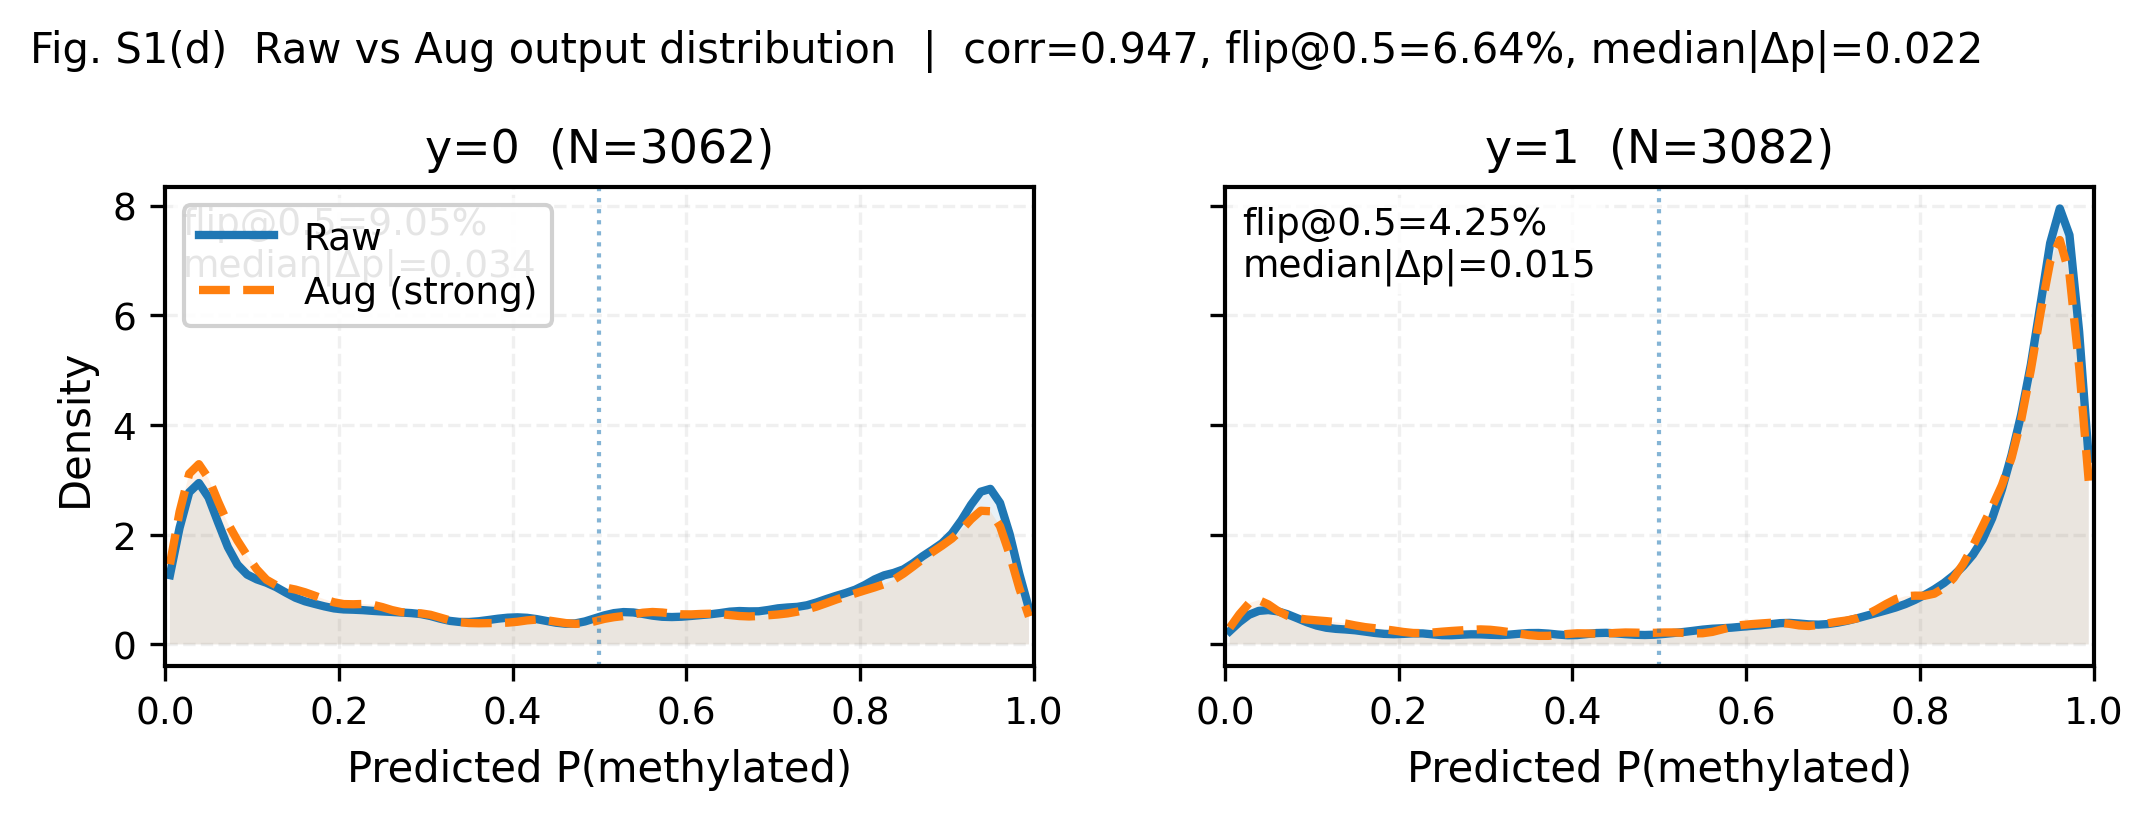

C:\Users\Administrator\AppData\Local\Temp\ipykernel_29608\2345999495.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.93])


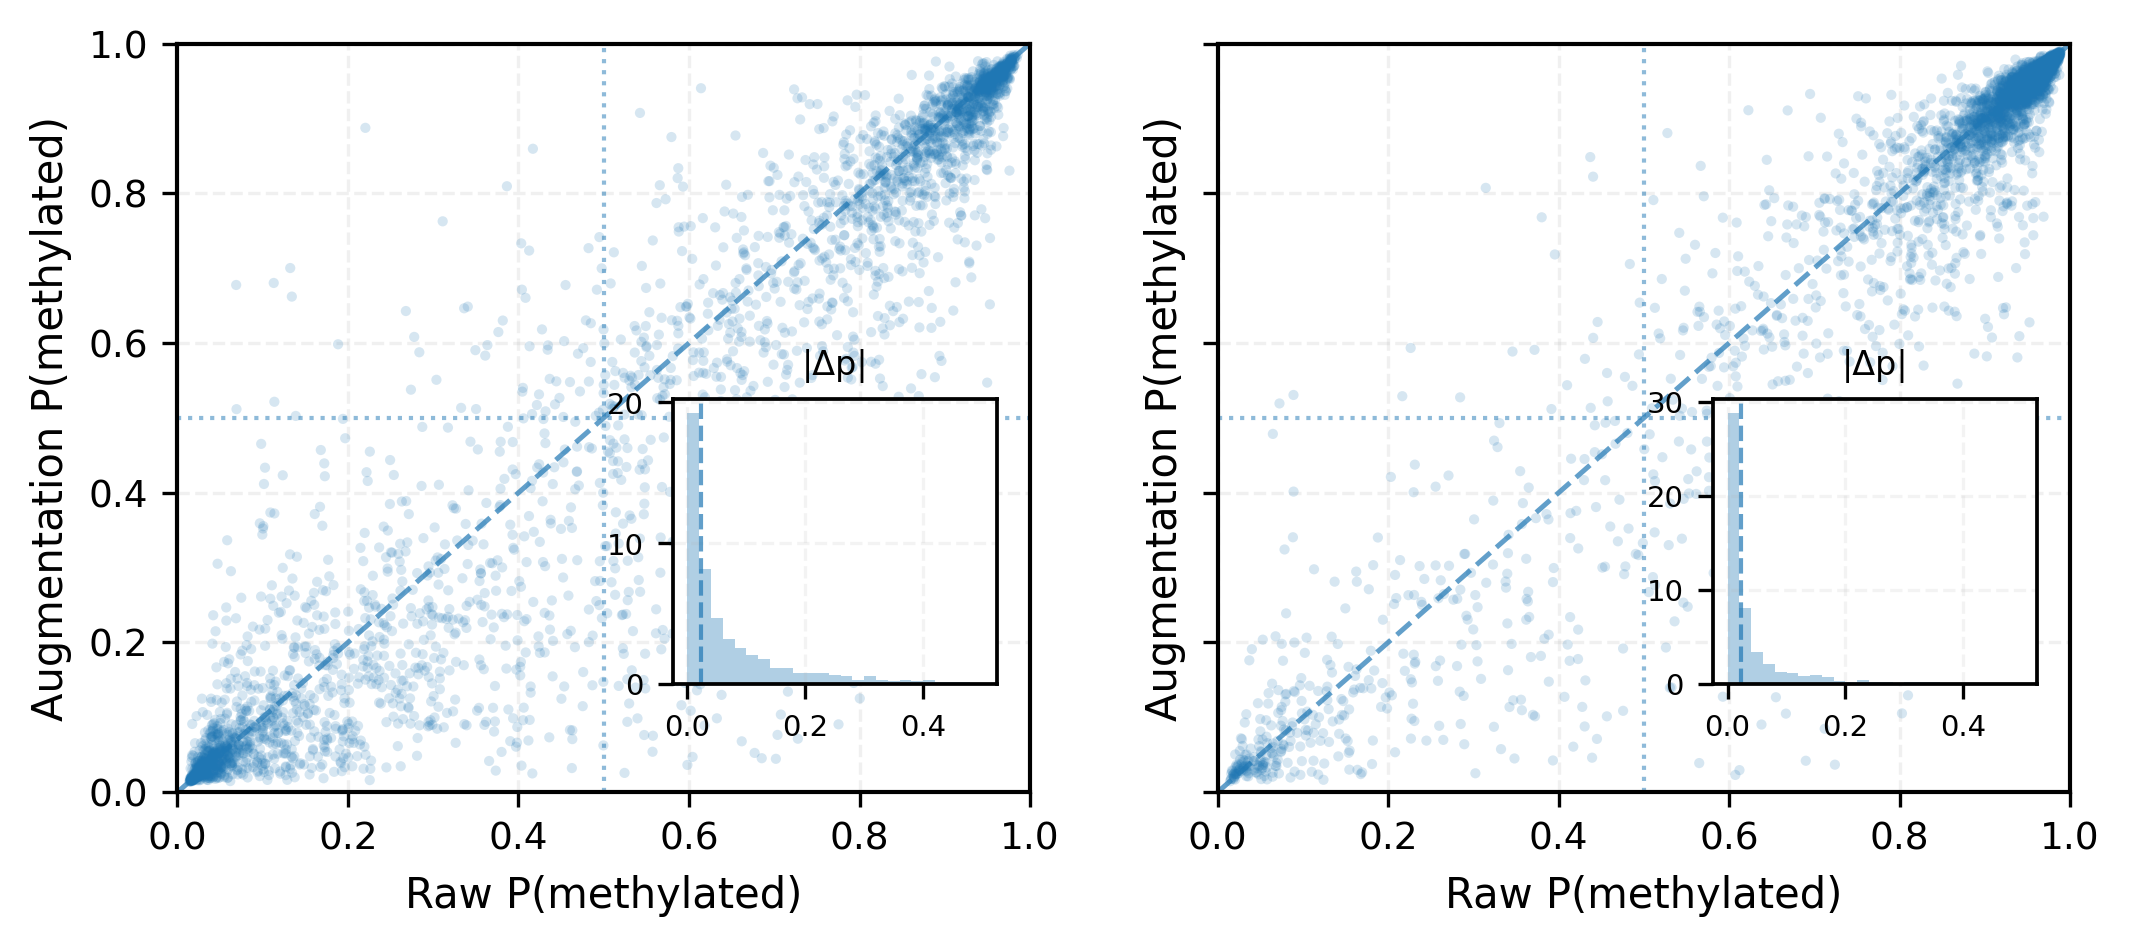

In [203]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def nice_ax(ax):
    ax.grid(True, linestyle="--", alpha=0.18)
    ax.set_axisbelow(True)
    for sp in ax.spines.values():
        sp.set_linewidth(1.0)
        sp.set_edgecolor("black")
    ax.tick_params(labelsize=9)

def plot_pair(ax, p0, p1):

    ax.scatter(p0, p1, s=6, alpha=0.18, edgecolors="none")
    ax.plot([0, 1], [0, 1], ls="--", lw=1.2, alpha=0.7)     # y=x
    ax.axvline(0.5, ls=":", lw=1.0, alpha=0.5)
    ax.axhline(0.5, ls=":", lw=1.0, alpha=0.5)

    ax.set_xlim(0, 1); ax.set_ylim(0, 1)
    ax.set_xlabel("Raw P(methylated)", fontsize=10)
    ax.set_ylabel("Augmentation P(methylated)", fontsize=10)  


    r = float(np.corrcoef(p0, p1)[0, 1])
    flip = float(np.mean((p0 >= 0.5) != (p1 >= 0.5)))        # 0~1
     
    dp = np.abs(p1 - p0)

    ax_in = inset_axes(
        ax, width="38%", height="38%", loc="lower right", borderpad=0.8,
        bbox_to_anchor=(0, 0.10, 1, 1),   
        bbox_transform=ax.transAxes
    )

    bins = np.linspace(0, 0.5, 26)
    ax_in.hist(dp, bins=bins, density=True, histtype="stepfilled", alpha=0.35)
    ax_in.axvline(mad, ls="--", lw=1.0, alpha=0.7)

    ax_in.set_title("|Δp|", fontsize=8)

    ax_in.tick_params(axis="x", labelbottom=True)
    ax_in.set_xlabel("")

    ax_in.tick_params(labelsize=7)
    ax_in.grid(True, linestyle="--", alpha=0.15)
    for sp in ax_in.spines.values():
        sp.set_linewidth(0.9)
        sp.set_edgecolor("black")


    nice_ax(ax)


fig, axes = plt.subplots(1, 2, figsize=(7.2, 3.5), dpi=300, sharey=True)

for ax, cls in zip(axes, [0, 1]):
    m = (y_true == cls)
    plot_pair(ax, p_raw[m], p_aug[m])



plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.subplots_adjust(wspace=0.22)

plt.show()


Device: cuda
✅ 成功加载 20000 个样本
📊 数据形状: nano=torch.Size([20000, 13, 103]), label=torch.Size([20000])
Total N=20000 | wrong=3239 | FP=1610 | FN=1629
Selected FP: [16108, 19410, 4487, 13301, 16057, 5955]
Selected FN: [19232, 19719, 6396, 2585, 19908, 7156]
Saved: Fig_Sx_error_case_analysis_cases.csv


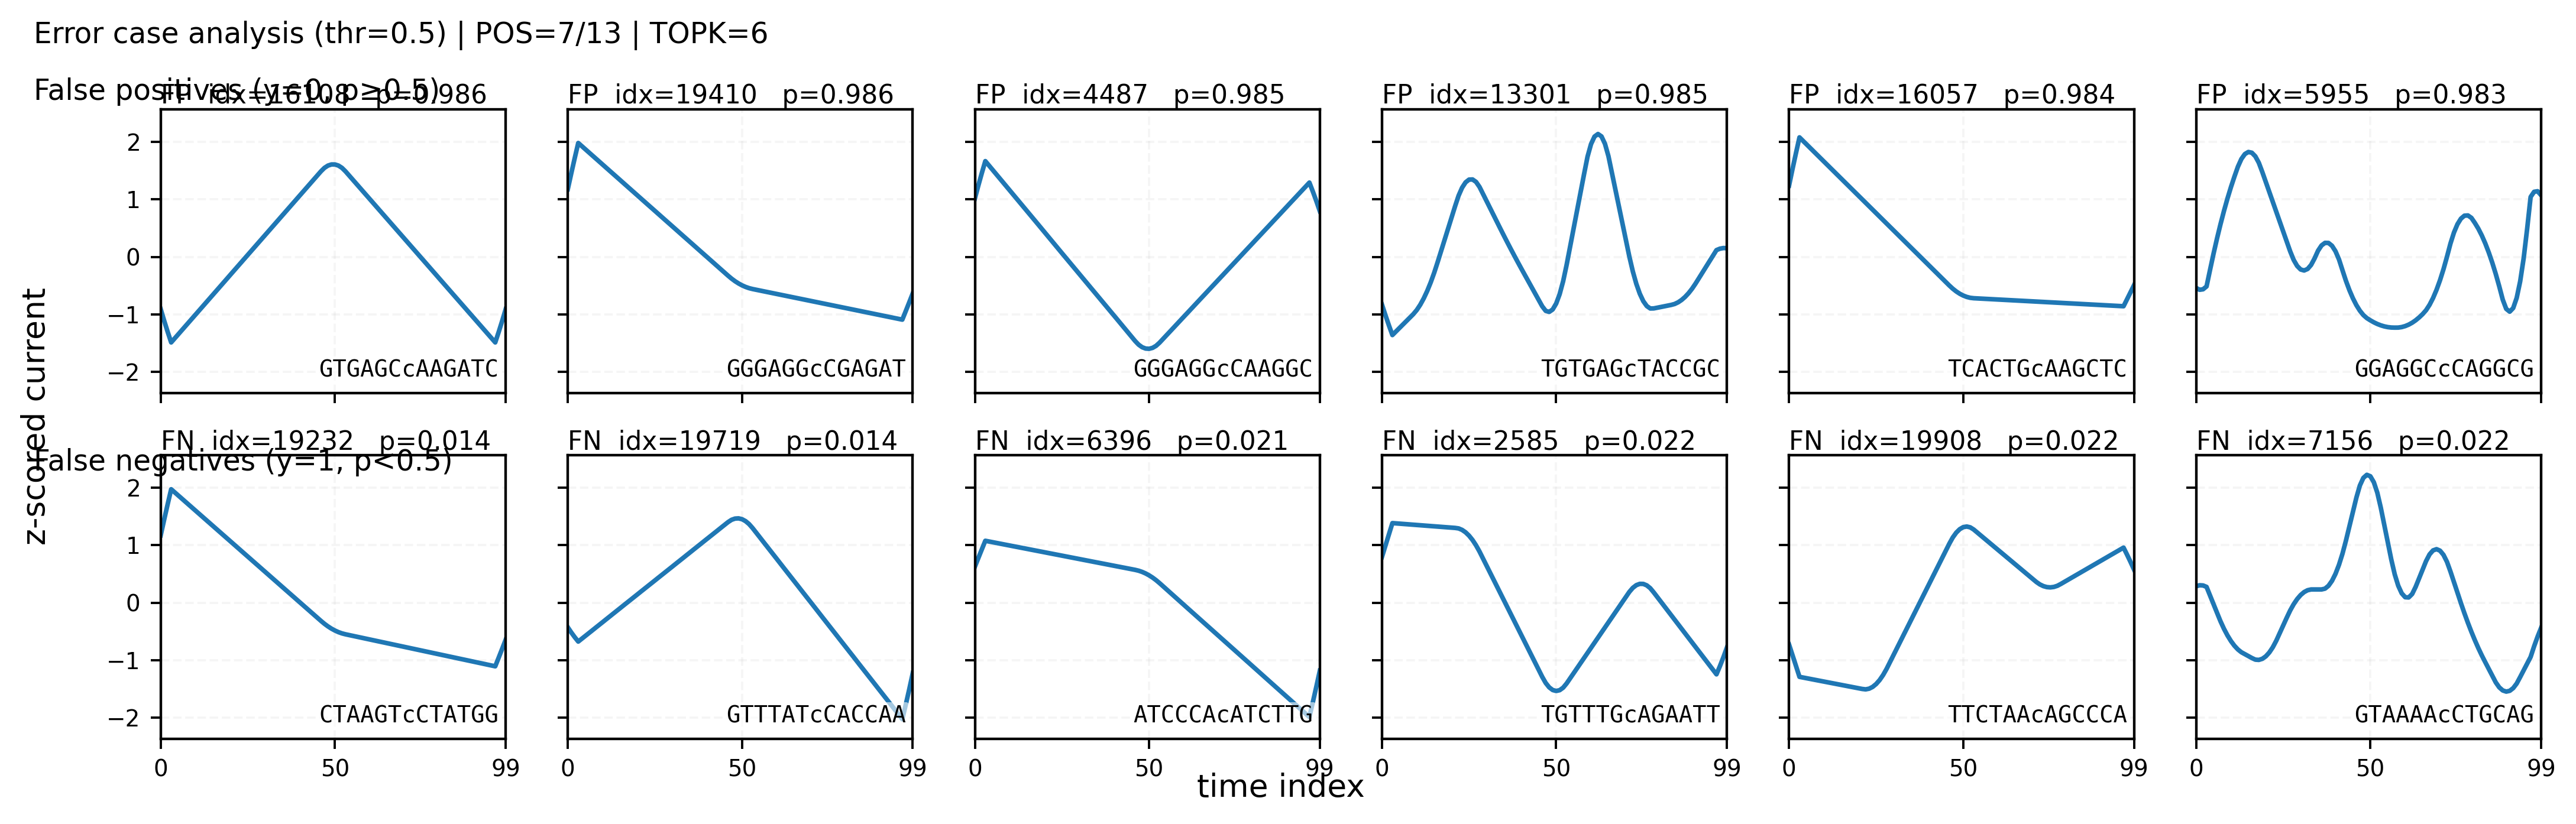

In [205]:
import os, random
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset
from scripts.dataLoader import load_dataset, make_data, MyDataSet, encode_seq_13mer
from moduls import MethyNano


TEST_CSV   = r"data\test_ninanjie.csv"
CKPT_PATH  = r"models\ninanjie\cls_best_ep019_f1=0.8352_acc=0.8363_auc=0.9215.pth"

OUT_PNG    = "Fig_Sx_error_case_analysis.png"
OUT_CSV    = "Fig_Sx_error_case_analysis_cases.csv"

THRESH     = 0.5
TOPK       = 6                
POS        = 6                 
T          = 100
BATCH_SIZE = 512
NUM_WORKERS = 0              
SEED       = 42

SHOW_NEIGHBORS = False        
SMOOTH_WIN = 7               

MODEL_DIM  = 256
N_HEADS    = 8
BASE_SIG   = 160
DROPOUT    = 0.1


def smooth_ma(x, win=7):
    if win is None or win <= 1:
        return x
    win = int(win)
    if win % 2 == 0:
        win += 1
    k = np.ones(win, dtype=np.float32) / win
    return np.convolve(x, k, mode="same")

def format_kmer_center(seq, center=6):
    s = str(seq)[:13]
    if len(s) < 13:
        s = s + ("N" * (13 - len(s)))

    return s[:center] + s[center].lower() + s[center+1:]

class WithIndex(Dataset):
    def __init__(self, base_ds):
        self.ds = base_ds
    def __len__(self):
        return len(self.ds)
    def __getitem__(self, idx):
        s, n, y = self.ds[idx]
        return idx, s, n, y

@torch.no_grad()
def collate_cls_with_idx(batch):
    idxs, seq_ids, sig, stats, labels, seq_strs = [], [], [], [], [], []
    for idx, s, n, y in batch:
        n = torch.as_tensor(n, dtype=torch.float32)   # [13,103]
        st = n[:, :3]                                 # [13,3]
        sg = n[:, 3:]                                 # [13,100]

        idxs.append(torch.tensor(idx, dtype=torch.long))
        seq_ids.append(torch.tensor(encode_seq_13mer(s), dtype=torch.long))
        sig.append(torch.nan_to_num(sg))
        stats.append(torch.nan_to_num(st))
        labels.append(torch.tensor(int(y), dtype=torch.long))
        seq_strs.append(str(s))

    return (
        torch.stack(idxs, 0),        # [B]
        seq_strs,                    # list[str], len=B
        torch.stack(seq_ids, 0),     # [B,13]
        torch.stack(sig, 0),         # [B,13,100]
        torch.stack(stats, 0),       # [B,13,3]
        torch.stack(labels, 0),      # [B]
    )

def nice_ax(ax):
    ax.grid(True, linestyle="--", alpha=0.18)
    ax.set_axisbelow(True)
    for sp in ax.spines.values():
        sp.set_linewidth(1.0)
        sp.set_edgecolor("black")
    ax.tick_params(labelsize=8)

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

seq, nano, lab = load_dataset(TEST_CSV, feature_mode="both", mask=-1)
seq, nano, lab = make_data((seq, nano, lab))   # nano: [N,13,103], lab: [N]
base_ds = MyDataSet(seq, nano, lab)
ds = WithIndex(base_ds)

N = len(ds)
y_true = lab.detach().cpu().numpy().astype(int)

loader = DataLoader(
    ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True,
    collate_fn=collate_cls_with_idx, drop_last=False
)

model = MethyNano(
    with_projection=False, with_classification=True,
    dimension=MODEL_DIM, n_heads=N_HEADS, dropout=DROPOUT, base_sig=BASE_SIG
).to(device)

ckpt = torch.load(CKPT_PATH, map_location="cpu")
state = ckpt.get("model", ckpt)
model.load_state_dict(state, strict=False)
model.eval()

p = np.full((N,), np.nan, dtype=np.float32)

with torch.no_grad():
    for idxs, seq_strs, seq_ids, sig, stats, labels in loader:
        seq_ids = seq_ids.to(device)
        sig     = sig.to(device)
        stats   = stats.to(device)

        out = model(sig, seq_ids, stats)
        p_batch = out["probs"][:, 1].detach().cpu().numpy()
        p[idxs.numpy()] = p_batch

assert np.isfinite(p).all(), "Some probabilities are NaN/Inf. Check data."

pred = (p >= THRESH).astype(int)
wrong = (pred != y_true)

fp_idx = np.where((y_true == 0) & (pred == 1))[0]
fn_idx = np.where((y_true == 1) & (pred == 0))[0]

fp_idx = fp_idx[np.argsort(-p[fp_idx])]
fn_idx = fn_idx[np.argsort(p[fn_idx])]

fp_sel = fp_idx[:TOPK].tolist()
fn_sel = fn_idx[:TOPK].tolist()

print(f"Total N={N} | wrong={wrong.sum()} | FP={len(fp_idx)} | FN={len(fn_idx)}")
print("Selected FP:", fp_sel)
print("Selected FN:", fn_sel)

def quality_metrics(sig13):
    # sig13: [13,100] numpy
    cen = sig13[POS]
    return dict(
        center_std=float(np.std(cen)),
        center_ptp=float(np.max(cen) - np.min(cen)),
        zero_ratio=float(np.mean(np.abs(sig13) < 1e-6)),
    )

rows = []
for typ, idx_list in [("FP", fp_sel), ("FN", fn_sel)]:
    for idx in idx_list:
        s, n, y = base_ds[idx]
        n = n.detach().cpu().numpy()
        sig13 = n[:, 3:]  # [13,100]
        km = quality_metrics(sig13)
        rows.append(dict(
            type=typ,
            idx=idx,
            y=int(y_true[idx]),
            p=float(p[idx]),
            margin=float(abs(p[idx] - THRESH)),
            kmer_13mer=str(s)[:13],
            kmer_center_marked=format_kmer_center(s, center=POS),
            **km
        ))

pd.DataFrame(rows).to_csv(OUT_CSV, index=False, encoding="utf-8-sig")
print("Saved:", OUT_CSV)





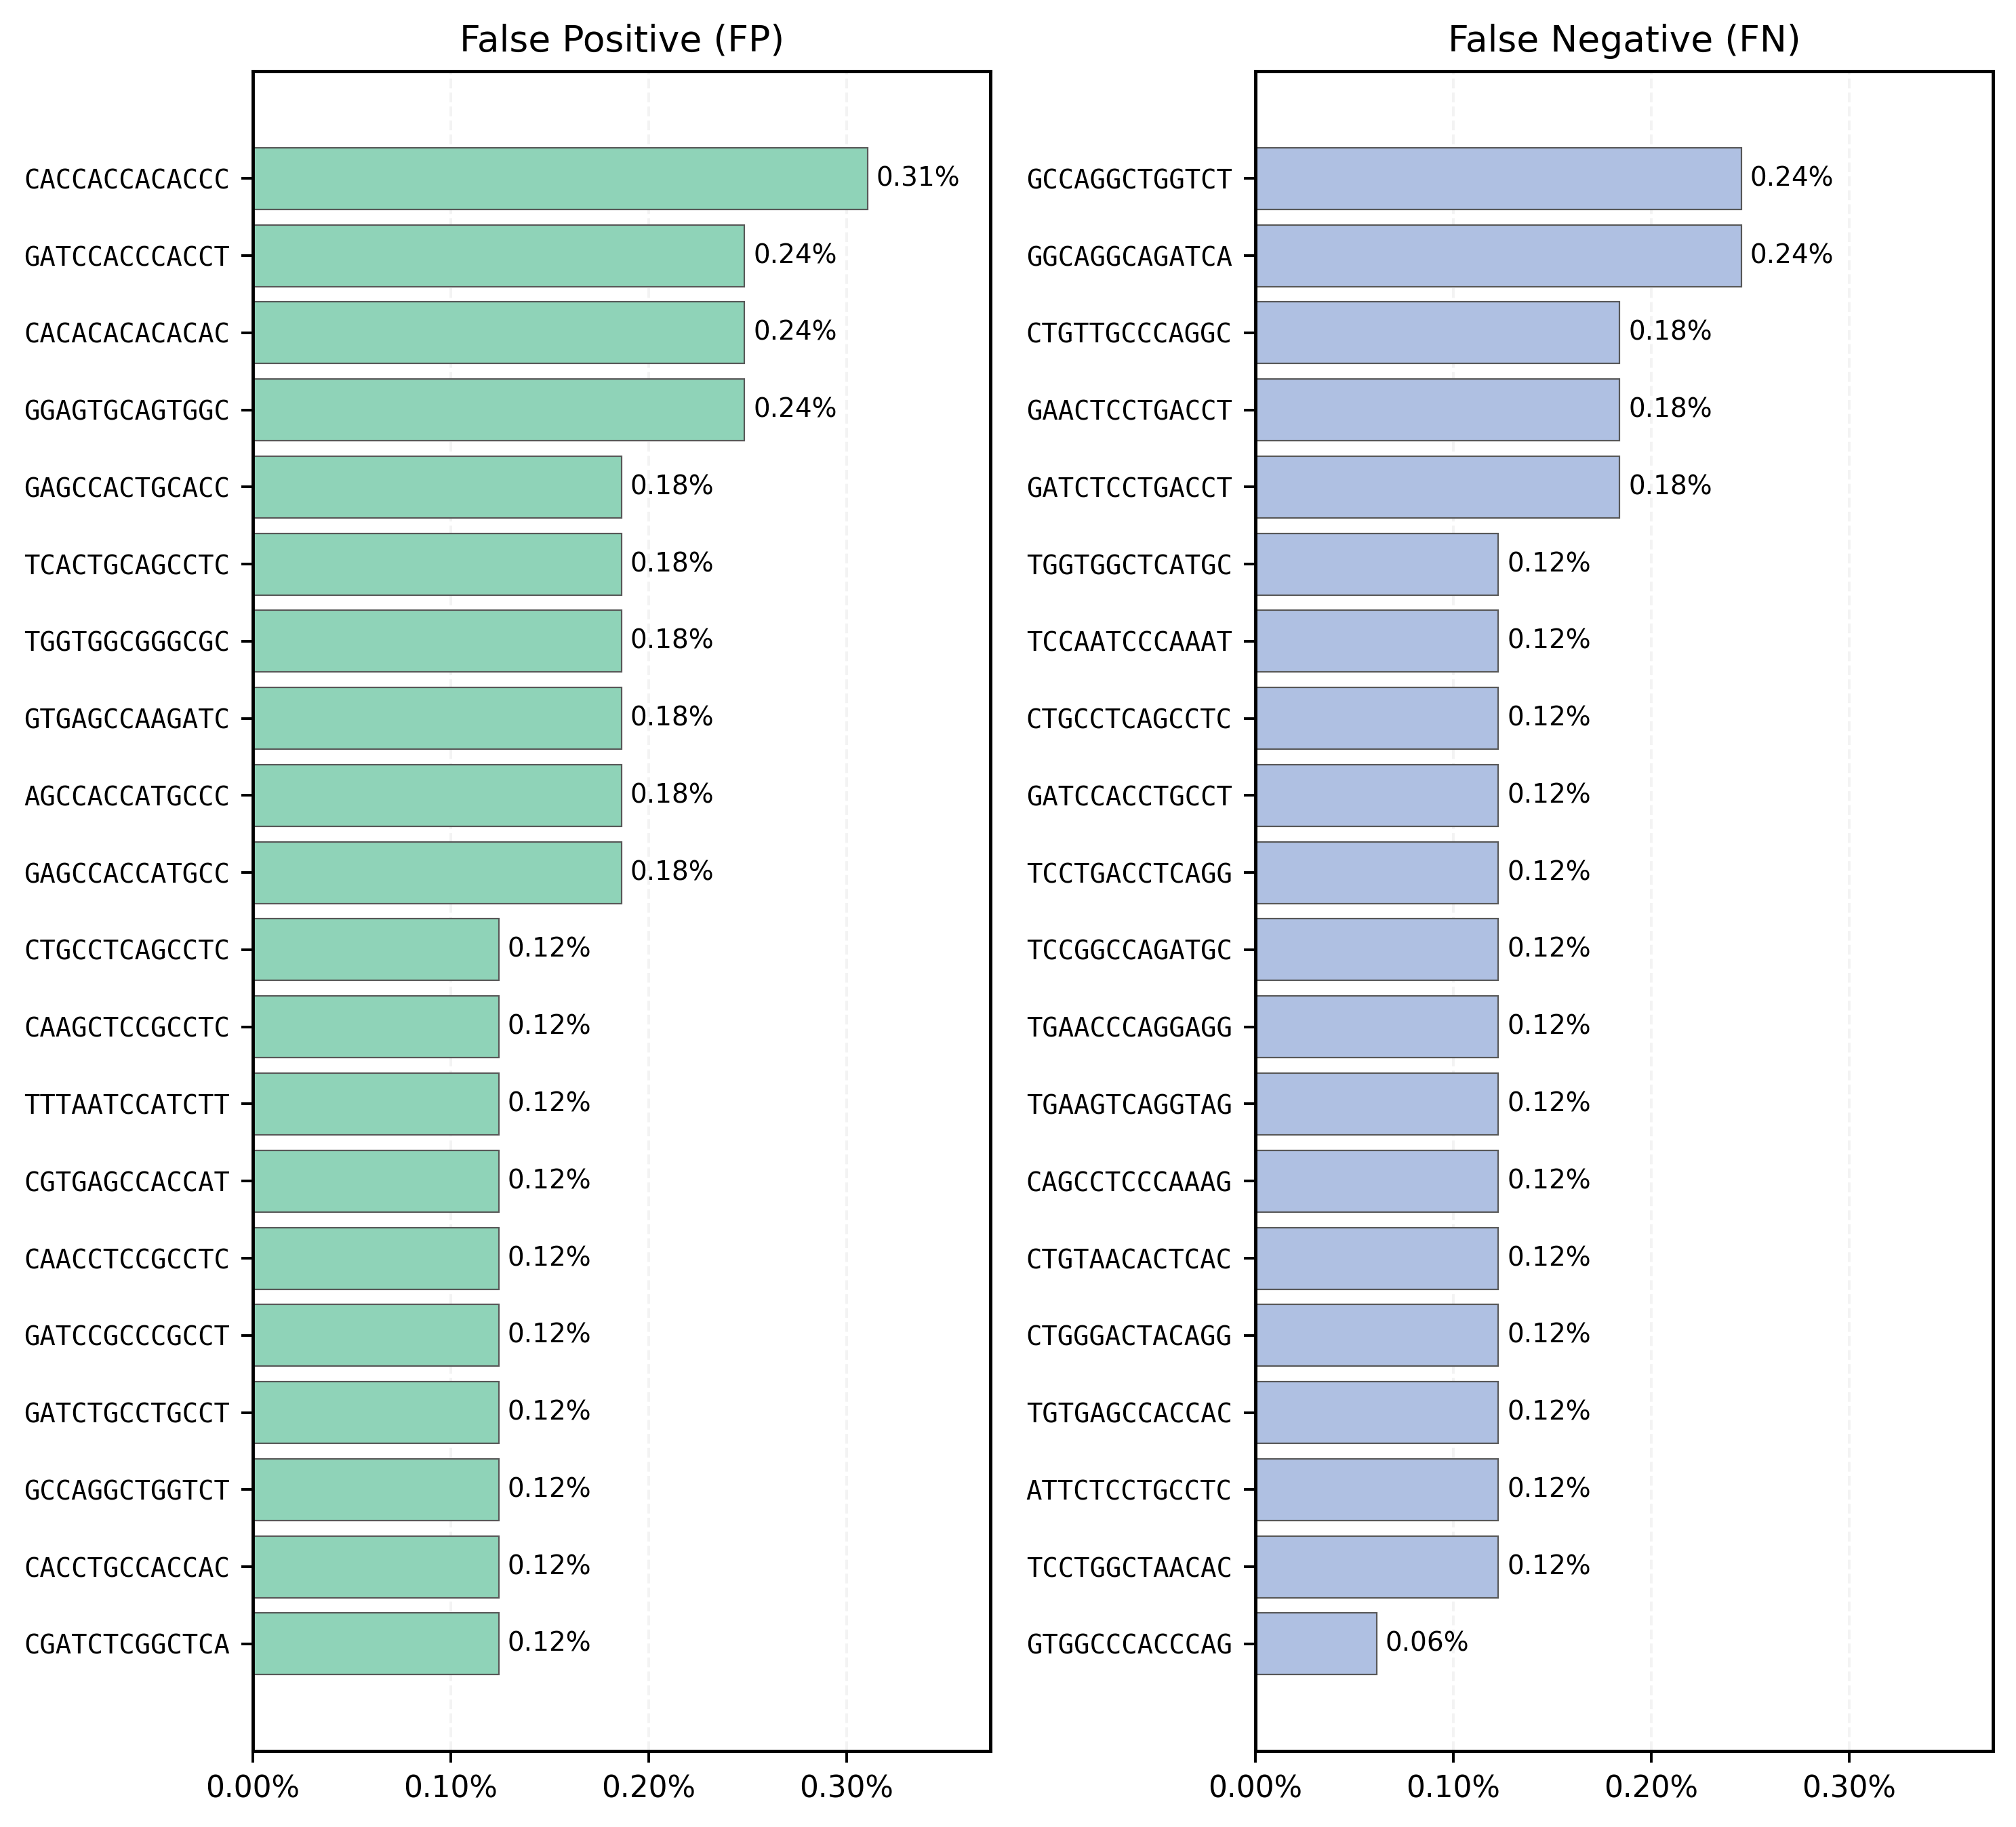

In [238]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



TOP_MOTIFS = 20
SAVE_PNG   = "Fig_Sx_error_13mer_barh.png"

COLOR_FP = "#4C72B0"   # muted blue
COLOR_FN = "#C44E52"   # muted red

def norm_13mer(seq):
    s = str(seq).upper().replace("U", "T")
    s = s[:13]
    if len(s) < 13:
        s = s + "N" * (13 - len(s))
    return s

def mark_center_13mer(s, center=POS):

    return norm_13mer(s)

fp_13 = [mark_center_13mer(base_ds[i][0]) for i in fp_idx]
fn_13 = [mark_center_13mer(base_ds[i][0]) for i in fn_idx]

# ---- TOP motifs (counts) ----
fp_ct = pd.Series(fp_13).value_counts().head(TOP_MOTIFS)
fn_ct = pd.Series(fn_13).value_counts().head(TOP_MOTIFS)


shared = set(fp_ct.index) & set(fn_ct.index)

N_FP = max(1, len(fp_idx))
N_FN = max(1, len(fn_idx))
fp_fr = (fp_ct / N_FP).astype(float)
fn_fr = (fn_ct / N_FN).astype(float)


COLOR_FP_ONLY = "#8FD3B8"  
COLOR_FN_ONLY = "#AFC0E2"   
COLOR_SHARED  = "#DDE3E8"  
EDGE_COLOR    = "#585858"

fig_h = 0.32 * max(len(fp_fr), len(fn_fr)) + 1.4
fig, axes = plt.subplots(1, 2, figsize=(8.6, fig_h), dpi=350)

from matplotlib.ticker import FuncFormatter, MaxNLocator


def _pct_str_floor(x, dec=2):
  
    scale = 10 ** dec
    pct = x * 100.0
    pct = np.floor(pct * scale + 1e-12) / scale
    return f"{pct:.{dec}f}%"
import matplotlib.colors as mcolors
def barh_panel(ax, fr, title, base_color, shared_set, xlim_max):
    labels = fr.index.tolist()[::-1]
    freqs  = fr.values.tolist()[::-1]
    y = np.arange(len(freqs))
    
    colors = []
    for lab in labels:
            colors.append(mcolors.to_rgba(base_color, 1))      
    
    ax.barh(
        y, freqs,
        color=colors,
        edgecolor=EDGE_COLOR, linewidth=0.45
    )

    ax.set_yticks(y)
    ax.set_yticklabels(labels, fontfamily="monospace", fontsize=8)
    ax.set_title(title, fontsize=11, pad=6, loc="center")

    ax.set_xlim(0, xlim_max)

    ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: _pct_str_floor(x, dec=2)))

    ax.grid(True, axis="x", linestyle="--", alpha=0.15)
    ax.set_axisbelow(True)

    pad_out = 0.012 * xlim_max
    pad_in  = 0.010 * xlim_max
    for yi, f in enumerate(freqs):
        txt = _pct_str_floor(f, dec=2)
        if f >= 0.88 * xlim_max:
            ax.text(f - pad_in, yi, txt, va="center", ha="right", fontsize=8, clip_on=True)
        else:
            ax.text(f + pad_out, yi, txt, va="center", ha="left", fontsize=8, clip_on=True)

    for sp in ax.spines.values():
        sp.set_linewidth(1.0)
        sp.set_edgecolor("black")
xmax = max(fp_fr.max() if len(fp_fr) else 0, fn_fr.max() if len(fn_fr) else 0)
xlim_max = xmax * 1.20 + 1e-6

barh_panel(axes[0], fp_fr, "False Positive (FP)", COLOR_FP_ONLY, shared, xlim_max)
barh_panel(axes[1], fn_fr, "False Negative (FN)", COLOR_FN_ONLY, shared, xlim_max)

plt.tight_layout()
plt.show()



[Match] FP: covered 64/1610 by motif;  TN matched n=64
[Match] FN: covered 92/1629 by motif;  TP matched n=92


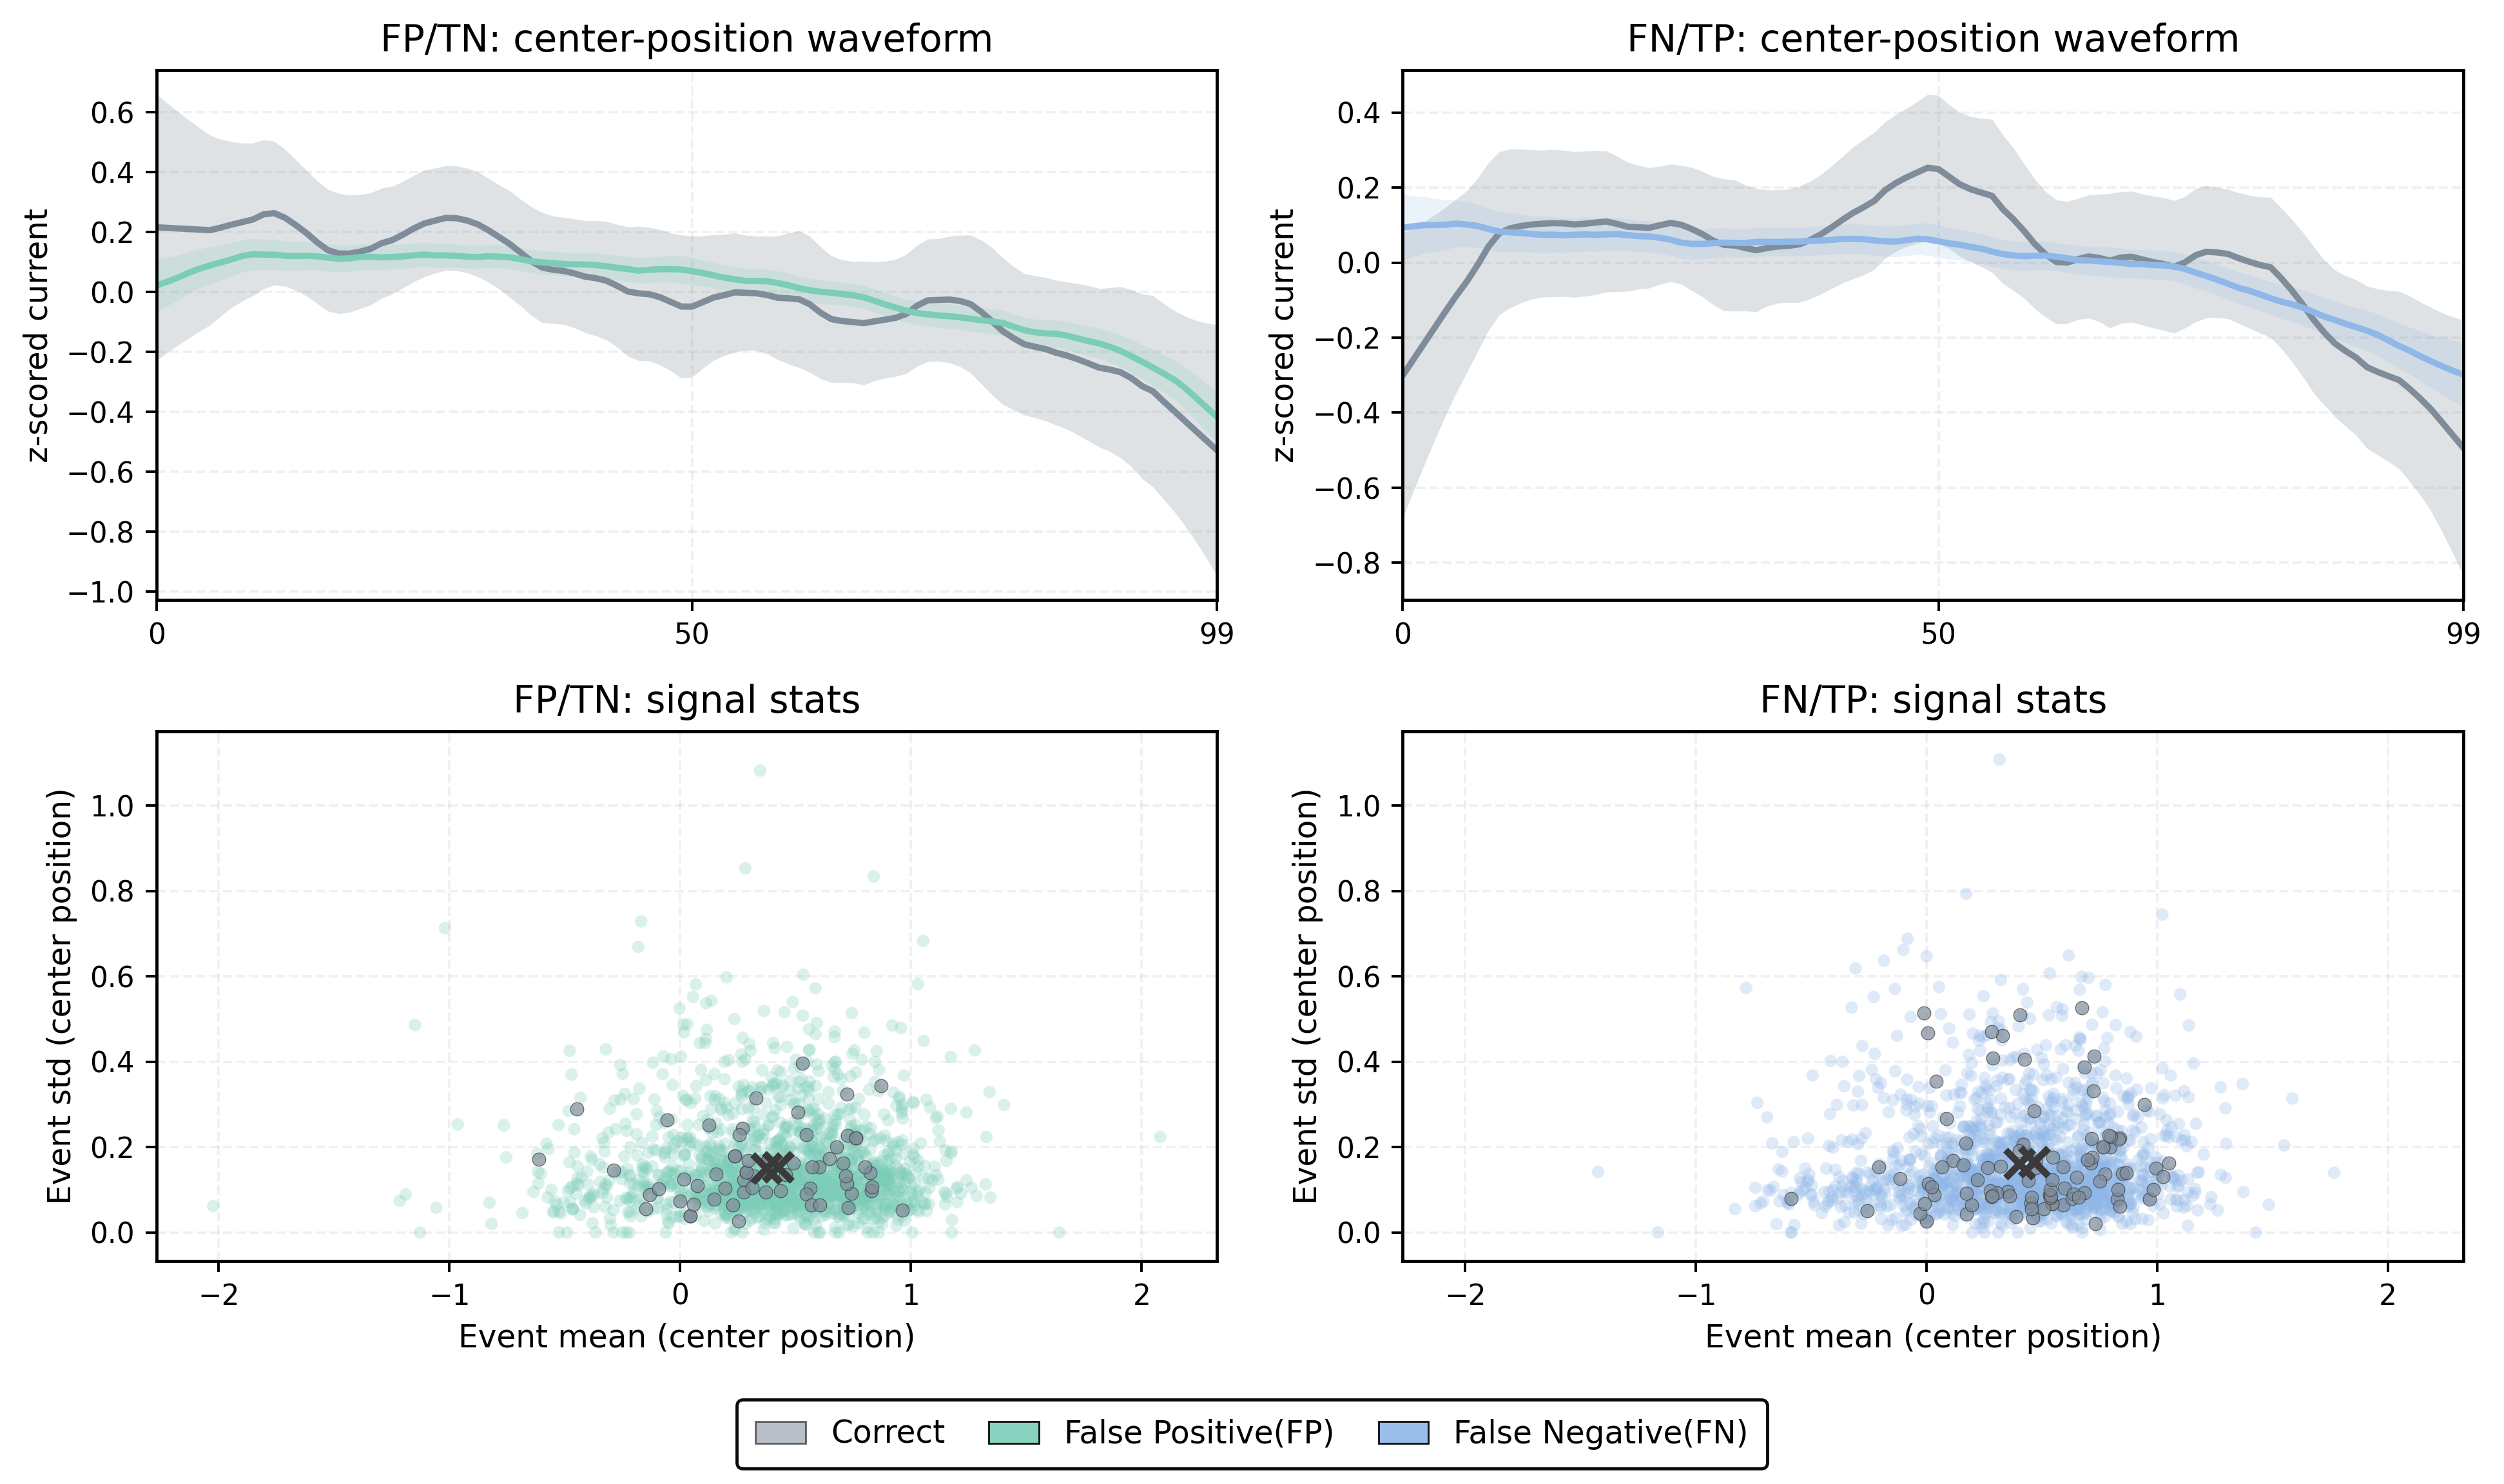

In [246]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib as mpl


COLOR_FP = "#7BCDB8"  
COLOR_FN = "#8FB7E8"   
COLOR_OK = "#7F8C99"   
EDGE     = "#3A3A3A"

mpl.rcParams.update({
    "font.size": 10,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
})

def nice_ax(ax):
    ax.grid(True, linestyle="--", alpha=0.18)
    ax.set_axisbelow(True)
    for sp in ax.spines.values():
        sp.set_linewidth(1.0)
        sp.set_edgecolor("black")

def norm_13mer(seq):
    s = str(seq).upper().replace("U", "T")
    s = s[:13]
    if len(s) < 13:
        s = s + "N" * (13 - len(s))
    return s


tp_idx = np.where((y_true == 1) & (pred == 1))[0].tolist()
tn_idx = np.where((y_true == 0) & (pred == 0))[0].tolist()

def match_by_motif(err_idxs, ok_pool, seed=42):
    rng = np.random.default_rng(seed)

    err_by_m = defaultdict(list)
    ok_by_m  = defaultdict(list)

    for i in err_idxs:
        err_by_m[norm_13mer(base_ds[i][0])].append(i)
    for i in ok_pool:
        ok_by_m[norm_13mer(base_ds[i][0])].append(i)

    matched_ok = []
    covered_err = 0
    for m, errs in err_by_m.items():
        pool = ok_by_m.get(m, [])
        if len(pool) == 0:
            continue
        k = len(errs)
        covered_err += k
        if len(pool) >= k:
            chosen = rng.choice(pool, size=k, replace=False)
        else:
            chosen = rng.choice(pool, size=k, replace=True)
        matched_ok.extend(chosen.tolist())

    return matched_ok, covered_err, len(err_idxs)

fp_ok, fp_cov, fp_tot = match_by_motif(fp_idx, tn_idx, seed=SEED)
fn_ok, fn_cov, fn_tot = match_by_motif(fn_idx, tp_idx, seed=SEED)

print(f"[Match] FP: covered {fp_cov}/{fp_tot} by motif;  TN matched n={len(fp_ok)}")
print(f"[Match] FN: covered {fn_cov}/{fn_tot} by motif;  TP matched n={len(fn_ok)}")


def get_wave_and_stats(idxs):
    waves = []
    means = []
    stds  = []
    for i in idxs:
        s, n, y = base_ds[i]
        n = n.detach().cpu().numpy()  # [13,103]
        st = n[:, :3]                 # [13,3]  (mean, std, len)
        sg = n[:, 3:]                 # [13,100] (z-scored waveform)
        waves.append(sg[POS])         # [T]
        means.append(st[POS, 0])
        stds.append(st[POS, 1])
    return np.asarray(waves, np.float32), np.asarray(means, np.float32), np.asarray(stds, np.float32)

fp_wave, fp_mean, fp_std = get_wave_and_stats(fp_idx)
tn_wave, tn_mean, tn_std = get_wave_and_stats(fp_ok)

fn_wave, fn_mean, fn_std = get_wave_and_stats(fn_idx)
tp_wave, tp_mean, tp_std = get_wave_and_stats(fn_ok)

t = np.arange(T)

def plot_wave_panel(ax, w_err, w_ok, title, c_err):
    # mean ± 1.96*SEM
    mu_e = w_err.mean(0); se_e = w_err.std(0, ddof=1) / np.sqrt(max(1, len(w_err)))
    mu_o = w_ok.mean(0);  se_o = w_ok.std(0, ddof=1) / np.sqrt(max(1, len(w_ok)))

    ax.plot(t, mu_o, lw=2.0, color=COLOR_OK, label="Correct")
    ax.fill_between(t, mu_o - 1.96*se_o, mu_o + 1.96*se_o, color=COLOR_OK, alpha=0.25, linewidth=0)

    ax.plot(t, mu_e, lw=2.0, color=c_err, label="Error")
    ax.fill_between(t, mu_e - 1.96*se_e, mu_e + 1.96*se_e, color=c_err, alpha=0.18, linewidth=0)

    ax.set_title(title)
    ax.set_xlim(0, T-1)
    ax.set_xticks([0, 50, 99])
    nice_ax(ax)

def plot_scatter_panel(ax, m_err, s_err, m_ok, s_ok, title, c_err):

    ax.scatter(m_err, s_err,
               s=16, alpha=0.28, color=c_err,
               edgecolors="none", label="Error",
               zorder=2, rasterized=True)


    ax.scatter(m_ok, s_ok,
               s=18,
               color=COLOR_OK, alpha=0.70,          
               edgecolors=EDGE, linewidths=0.25,    
               label="Correct",
               zorder=3, rasterized=True)

    # 质心（最上层）
    ax.scatter([m_ok.mean()],  [s_ok.mean()],  s=80, marker="x", color=EDGE, linewidths=2.2, zorder=4)
    ax.scatter([m_err.mean()], [s_err.mean()], s=80, marker="x", color=EDGE, linewidths=2.2, zorder=4)

    ax.set_title(title)
    ax.set_xlabel("Event mean (center position)")
    ax.set_ylabel("Event std (center position)")
    nice_ax(ax)



m_all = np.concatenate([fp_mean, tn_mean, fn_mean, tp_mean])
s_all = np.concatenate([fp_std,  tn_std,  fn_std,  tp_std])
m_pad = 0.06 * (m_all.max() - m_all.min() + 1e-6)
s_pad = 0.06 * (s_all.max() - s_all.min() + 1e-6)
m_lim = (float(m_all.min()-m_pad), float(m_all.max()+m_pad))
s_lim = (float(s_all.min()-s_pad), float(s_all.max()+s_pad))

fig, axes = plt.subplots(2, 2, figsize=(11.2, 6.6), dpi=350)

plot_wave_panel(axes[0,0], fp_wave, tn_wave, "FP/TN: center-position waveform", COLOR_FP)
plot_wave_panel(axes[0,1], fn_wave, tp_wave, "FN/TP: center-position waveform", COLOR_FN)
axes[0,0].set_ylabel("z-scored current")
axes[0,1].set_ylabel("z-scored current")

plot_scatter_panel(axes[1,0], fp_mean, fp_std, tn_mean, tn_std, "FP/TN: signal stats", COLOR_FP)
plot_scatter_panel(axes[1,1], fn_mean, fn_std, tp_mean, tp_std, "FN/TP: signal stats", COLOR_FN)

for ax in [axes[1,0], axes[1,1]]:
    ax.set_xlim(*m_lim)
    ax.set_ylim(*s_lim)

from matplotlib.patches import Patch

legend_handles = [
    Patch(facecolor=COLOR_OK,  edgecolor="black", linewidth=0.6, alpha=0.55, label="Correct"),
    Patch(facecolor=COLOR_FP,  edgecolor="black", linewidth=0.6, alpha=0.90, label="False Positive(FP)"),
    Patch(facecolor=COLOR_FN,  edgecolor="black", linewidth=0.6, alpha=0.90, label="False Negative(FN)"),
]

leg = fig.legend(
    handles=legend_handles,
    loc="lower center",
    ncol=3,
    frameon=True,
    fancybox=True,
    framealpha=0.96,         
    borderpad=0.6,
    columnspacing=1.4,
    handlelength=1.6,
    fontsize=10
)

frame = leg.get_frame()
frame.set_edgecolor("black")
frame.set_linewidth(1.0)
frame.set_facecolor("white")

plt.tight_layout(rect=[0, 0.06, 1, 1])
plt.show()


In [6]:
import torch
import torch.nn as nn
from torchview import draw_graph

from moduls import MethyNano

class Wrap(nn.Module):
  
    def __init__(self, model: nn.Module):
        super().__init__()
        self.model = model

    def forward(self, sig, seq_ids, stats):
        out = self.model(sig, seq_ids, stats)
        return out["logits"]  # [B,2]

def main():

    model = MethyNano(
        use_stats=False,
        with_projection=False,
        with_classification=True,
        dimension=256,
        n_heads=8,
        dropout=0.1,
        base_sig=160,
    ).eval()

    wrapped = Wrap(model)

    B, T, L = 2, 100, 13
    sig = torch.randn(B, 13, T)
    seq_ids = torch.zeros(B, L, dtype=torch.long)
    stats = torch.randn(B, 13, 3)

    g = draw_graph(
        wrapped,
        input_data=(sig, seq_ids, stats),
        expand_nested=True,     
        depth=6,              
        graph_name="MethyNano",
        device="cpu",
    )

    g.visual_graph.render("methynano_torchview", format="png", cleanup=True)
    print("Saved: methynano_torchview.png")

if __name__ == "__main__":
    main()



(process:35540): Pango-WARNING **: 21:17:29.850: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


Saved: methynano_torchview.png


flowchart TB
  Sig[Signal\n(B,13,T)] --> SE[SignalEncoder\nDWConv(k=5)+Res\n3-branch Conv2d(k=3/5/7)\nPool+Merge\nProj+Pos]
  Seq[Sequence\n(B,L)] --> QE[SequenceEncoder\nEmbedding(5->128)\nBiLSTM(192x2)\nProj+MaskPool]

  SE --> Tsig[tokens_sig\n(B,13,D)]
  QE --> Tseq[tokens_seq\n(B,L,D)]

  Tsig --> F[CrossModalFuser\nSymmetric Cross-Attn\nGatedResidual\nCenterPool\nConcat+Fuse]
  Tseq --> F

  F --> H[h_fused\n(B,D)]
  H --> C[Classifier\nMLP -> logits (B,2)]
